In [1]:
# from community import community_louvain
import gc
import logging
import os
import matplotlib.pyplot as plt
import multiprocessing as mp
from multiprocessing.pool import ThreadPool as Pool
import networkx as nx
import networkx.algorithms.community as nx_comm
import numpy as np
import random
import scipy
from scipy.optimize import differential_evolution, basinhopping, linprog
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow_constrained_optimization as tfco
import time
import warnings
logger = tf.get_logger()
print(scipy.__version__) # 1.9.3
os.environ['KMP_DUPLICATE_LIB_OK']='True'

1.9.3


In [2]:
import math

In [3]:
import json

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        if isinstance(obj, DnnResult) or isinstance(obj, AlgoResult):
            return json.dumps(obj.__dict__, cls = NpEncoder)
        if isinstance(obj, set):
            return list(obj)
        return json.JSONEncoder.default(self, obj)

In [4]:
logging.basicConfig(encoding='utf-8', level=logging.INFO,
                    force = True)

In [5]:
seed = 0
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
threads_count = 1
pool = Pool(threads_count)
mp.cpu_count()

use_parallelizing = False

In [6]:
# tf.compat.v1.disable_eager_execution()
# tf.compat.v1.enable_eager_execution()

In [7]:
class DnnParams():
    def __init__(self, alpha, clipnorm, max_epochs = 1000):
        self.alpha = alpha
        self.clipnorm = clipnorm
        self.max_epochs = max_epochs

In [8]:
class DnnResult():
    def __init__(self, G, theta, stuck, loss_arr, mis_size_arr, gradient_arr):
        self.G = G
        self.theta = theta
        self.stuck = stuck
        self.loss_arr = loss_arr
        self.mis_size_arr = mis_size_arr
        self.local_improvement = None
        self.mis = None
        self.gradient_arr = gradient_arr

In [9]:
class AlgoResult():
    def __init__(self):
        self.communities_result = []
        self.simplicial_result = None
        self.local_improvement_result = None
        self.simp_nodes_len = 0
        self.forbiden_edges = None
        self.mis = None
        self.mis_after_forbidden_edges_processed_len = 0
        self.mis_in_left_nodes = None

In [10]:
class ValidationResult():
    def __init__(self, valid, can_add_nodes, contains_extra_nodes):
        self.valid = valid
        self.can_add_nodes = can_add_nodes
        self.contains_extra_nodes = contains_extra_nodes        

In [11]:
def graph1_adjacency_matrix():
    return np.array([
        [0, 1, 1, 0, 0, 0, 1, 0, ],
        [1, 0, 0, 1, 0, 0, 0, 1, ],
        [1, 0, 0, 1, 1, 0, 0, 0, ],
        [0, 1, 1, 0, 0, 1, 0, 0, ],
        [0, 0, 1, 0, 0, 1, 1, 0, ],
        [0, 0, 0, 1, 1, 0, 0, 1, ],
        [1, 0, 0, 0, 1, 0, 0, 1, ],
        [0, 1, 0, 0, 0, 1, 1, 0, ],
    ])


In [12]:
def build_test_graph1():
    adj_mat = graph1_adjacency_matrix()
    N = len(adj_mat)

    G = nx.Graph()
    for i in range(N):
        G.add_node(i)

    for i in range(N):
        for j in range(N):
            if adj_mat[i][j] == 1:
                G.add_edge(i, j)
                G.add_edge(j, i)
    return G

In [65]:
def clip(l,r,x):
    return max(l,min(r,x))

def calc_W(G, C):
    n = len(G.nodes())
    m = len(G.edges())
    m_c = len(C.edges())
    W = np.zeros((n,n+m+m_c),dtype= 'float32')
    for i in range(n):
        W[i][i] = 1
    l = n
    for edge in G.edges():
        i = int(edge[0])
        j = int(edge[1])
        W[i][l] = 1
        W[j][l] = 1
        l+=1
    for edge in C.edges():
        i = int(edge[0])
        j = int(edge[1])
        W[i][l] = 1
        W[j][l] = 1
        l+=1
    return W

def calc_b(G, C):
    n = len(G.nodes())
    m = len(G.edges())
    m_c = len(C.edges())
    b = np.array([-0.5 for i in range(n)])
    b_m = np.array([-1 for i in range(m+m_c)])
    return np.concatenate((b,b_m))

def calc_w(G, C):
    n = len(G.nodes())
    m = len(G.edges())
    m_c = len(C.edges())
    w = np.array([-1 for i in range(n)])
    w_n = np.array([n for i in range(m)])
    w_c = np.array([-1 for i in range(m_c)])
    return np.concatenate((w,w_n,w_c))

def build_theta(G):
    n = len(G.nodes())
    max_degree = max([G.degree(i) for i in range(n)])
#     logging.debug("Max degree = {}".format(max_degree))
    if max_degree == 0:
        return np.array([1 for i in range(n)])
#     return np.array([1 for i in range(n)])
    theta = np.array([1 - G.degree(i)/max_degree + random.random()/100000 for i in range(n)]).astype(np.float32) 
    max_theta = max(theta)
    for i in range(n):
        theta[i] = theta[i] / max_theta
    return theta
#     return np.array([random.random() for i in range(n)])

def build_network(G):
    logging.debug("Build network on graph G:{}.".format(str(G)))
    C = nx.complement(G)
    W = calc_W(G, C)
    b = calc_b(G, C)
    w = calc_w(G, C)
    theta = build_theta(G)
#     logging.debug("Initial theta = {}".format(theta))
    return (W,b,w, theta, C)


In [70]:
def get_result_nodes(theta, dnn_params):
    return set(np.argwhere(theta > dnn_params.alpha).reshape(-1))

def not_connected_nodes_exist_in_G(G, result_nodes):
    for v in G.nodes():
        if v not in result_nodes:
            node_not_connected_to_G = True
            for edge in G.neighbors(v):
                if edge in result_nodes:
                    node_not_connected_to_G = False
                    break
            if node_not_connected_to_G:
                return True
    return False
            
def graph_has_no_edges(G, result_nodes):
    for v in result_nodes:
        for edge in G.neighbors(v):
            if edge in result_nodes:
                return False
    return True

def mis_is_valid(G, mis):
    has_extra_nodes = not graph_has_no_edges(G, mis)
    not_connected_nodes_exist = not_connected_nodes_exist_in_G(G, mis)
    return ValidationResult(not has_extra_nodes and not not_connected_nodes_exist,
                            not_connected_nodes_exist, has_extra_nodes)
               
def result_is_valid(G, dnn_params, theta):
    result_nodes = get_result_nodes(theta, dnn_params)
    return mis_is_valid(G, result_nodes).valid

def network(theta,e_n,W_t,b,w_t):
    h = tf.math.multiply(e_n,theta)
    h = tf.linalg.matvec(W_t,h)
    h = tf.add(h,b)
    h = tf.nn.relu(h)
    h = tf.tensordot(w_t,h, 1)
    return h
    
def network_evol(theta,e_n,W_t,b,w_t):
    return network(theta,e_n,W_t,b,w_t).numpy()


def loss(theta,e_n,W_t,b,w_t,h_d):
#     with tf.GradientTape() as tape:
        h1 = tf.math.multiply(e_n,theta)
        h2 = tf.linalg.matvec(W_t,h1)
        h3 = tf.add(h2,b)
#         h4 = tf.math.sigmoid(h3)
        h4 = tf.nn.relu(h3)
#         h4 = tf.nn.leaky_relu(h3)
        h5 = tf.tensordot(w_t,h4, 1)
        diff = (h5-h_d)**2
#         diff = abs(h5-h_d) / abs(h_d)
#         diff = np.sqrt(abs(h5-h_d))
#         diff = abs(h5-h_d)
#         logging.info("Gradient norm = {}".format(np.linalg.norm(tape.gradient(diff, theta))))
#         logging.debug("Loss = {}".format(diff))
        return diff

def loss_evol(theta,e_n,W_t,b,w_t,h_d):
    h = network_evol(theta,e_n,W_t,b,w_t)
    return (h-h_d)**2 

def evolutionary_train(n,theta,e_n,W_t,b,w_t,h_d):
    bounds = [(0,1) for i in range(n)]
    theta = differential_evolution(loss_evol, bounds, x0 = theta, args = (e_n,W_t,b,w_t,h_d))
    theta = theta.x
    return DnnResult(theta, False)

def vectors_are_close(a,b):
    norm_diff = np.linalg.norm(a-b)
    return norm_diff < 1e-6 

class MinimizationProblem(tfco.ConstrainedMinimizationProblem):
    def __init__(self, loss_fn, weights):
        self._loss_fn = loss_fn
        self._weights = weights
    
    @property
    def num_constraints(self):
        return len(self._weights.numpy()) * 2
   
    def objective(self):
        return self._loss_fn()
   
    def constraints(self):
        theta = self._weights
        lt_or_eq_one = theta - 1
        gt_or_eq_zero = -theta
        constraints = tf.stack([lt_or_eq_one, gt_or_eq_zero])
        return constraints

def gradient_train(G, dnn_params, theta,e_n,W_t,b,w_t,h_d):
    epoch = 0

    grad = None
    grad_norm = None
    
    def local_loss():
        nonlocal grad, grad_norm
        with tf.GradientTape() as tape:    
            l = loss(theta,e_n,W_t,b,w_t,h_d)
            grad = tape.gradient(l, theta)
            grad_norm = np.linalg.norm(grad)
            return l
        
    initial_learning_rate = 0.1
#     print("initial learn rate:{}".format(initial_learning_rate))
    learning_rate = initial_learning_rate
    
    def local_learning_rate():
        return learning_rate
    
#     learning_rate_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
#         initial_learning_rate, dnn_params.max_epochs, decay_rate = 0.95
#     )
    
#     def step_decay_schedule(initial_lr=0.1, decay_factor=0.75, step_size=20):
#         def schedule(epoch):
#             return initial_lr * (decay_factor ** np.floor(epoch/step_size))
#         return LearningRateScheduler(schedule)
    
    N = len(G.nodes())
    clipnorm = dnn_params.clipnorm
    
    optimizer=tf.optimizers.Adam(learning_rate=local_learning_rate, global_clipnorm = clipnorm)

#     problem = MinimizationProblem(local_loss, theta)
#     optimizer = tfco.ProxyLagrangianOptimizerV2(
#       optimizer=tf.optimizers.Adam(learning_rate=0.1,),
#       constraint_optimizer=tf.optimizers.Adam(learning_rate=0.1,),
#       num_constraints=problem.num_constraints)
    
    
    solver_stuck = False
    loss_arr = list()
    loss_arr.append(local_loss().numpy())
    mis_size_arr = list()
    mis_size_arr.append(len(get_result_nodes(theta.numpy(), dnn_params)))
    gradient_arr = list()
    theta_arr = list()
    initial_grad_not_0_count = np.count_nonzero(grad)
    gradient_arr.append(grad_norm)
    theta_arr.append(theta.numpy())
    last_decay = 0
#     prev_gradients_not_0_count = initial_grad_not_0_count
    while not result_is_valid(G, dnn_params, theta) and epoch < dnn_params.max_epochs and not solver_stuck:
#         var_list = ([theta] + list(problem.trainable_variables) + optimizer.trainable_variables())
#         optimizer.minimize(problem, var_list=var_list)
        optimizer.minimize(local_loss, var_list=theta)
        l = local_loss()
        theta_arr.append(theta.numpy())
        loss_arr.append(l.numpy())
        mis_size_arr.append(len(get_result_nodes(theta, dnn_params)))
        epoch+=1
#         logging.info("Gradient: {}".format(grad))
#         logging.info("Gradient normalized: {}".format(grad / grad_norm))
#         if epoch % 10 == 0:
#             if loss_arr[-10] < loss_arr[-1]:
#                 logging.info("Decreasing clipnorm...")
#                 clipnorm *= 0.6
#                 optimizer=tf.optimizers.Adam(learning_rate=local_learning_rate, global_clipnorm = clipnorm)
#         if epoch > 2 and grad_norm == 0:
#             theta.assign(theta_arr[-2])
#             clipnorm/= 10
#             optimizer=tf.optimizers.Adam(learning_rate=local_learning_rate, global_clipnorm = clipnorm)
            
        if epoch % 10 == 0:
#             logging.info(optimizer.__dict__)       
            logging.info("Epoch: {}. Loss: {}. Gradient norm: {}. Clipnorm: {}. Learning rate:{}. Mis size: {}"
                         .format(epoch, l, grad_norm, clipnorm, learning_rate, len(get_result_nodes(theta, dnn_params))))
#         if loss_arr[-2] < loss_arr[-1]:
#             clipnorm *= 0.5
#             prev_gradients_not_0_count = gradients_not_0_count
#             learning_rate*= 0.1
#             optimizer=tf.optimizers.Adam(learning_rate=local_learning_rate, global_clipnorm = clipnorm)
#         
#             logging.info("Epoch: {}. Clipnorm: {}. Learning rate: {}".format(epoch, clipnorm, learning_rate))
#         
#         if epoch % 10 == 0:
#             if gradient_arr[-1] > gradient_arr[-10] and loss_arr[-1] > loss_arr[-10]:
#                 logging.info("Decreasing learning rate")
#                 learning_rate*=0.5
#         gradients_not_0_count = np.count_nonzero(grad)
#         if prev_gradients_not_0_count > gradients_not_0_count:
#             clipnorm = initial_clipnorm * gradients_not_0_count / initial_grad_not_0_count
#             prev_gradients_not_0_count = gradients_not_0_count
#             logging.info("Epoch: {}. Clipnorm: {}. Learning rate: {}".format(epoch, clipnorm, learning_rate))
#             optimizer=tf.optimizers.Adam(learning_rate=local_learning_rate, global_clipnorm = clipnorm)
          
#         if epoch % 50 == 0 and loss_arr[-1] > loss_arr[-50]:
#                 logging.info("Epoch: {}. Clipnorm: {}. Learning rate: {}".format(epoch, clipnorm, local_learning_rate()))
#                 learning_rate *= 0.1
#         if epoch - last_decay > 10 and local_loss() > loss_arr[-10] and grad > gradient_arr[-10]:
#         if epoch - last_decay > 10 and grad > gradient_arr[-10]:
#         if local_loss() > loss_arr[-1]:
#                 learning_rate *= 0.1
#                 learning_rate = (1/(1+decay*epoch))*initial_learning_rate
#                 learning_rate*=0.5
                
        
                
#                 last_decay = epoch
        
        gradient_arr.append(grad_norm)
#         if False:
#         if grad_norm == 0:
        if np.allclose(theta_arr[-2], theta_arr[-1], atol=1e-15):
            logging.warning("Solver stuck.")
#             loss_min = loss_arr[0]
#             index = 0
#             for i in range(epoch):
#                 if loss_arr[i] < loss_min and gradient_arr[i] != 0:
#                     loss_min = loss_arr[i]
#                     index = i
#             theta.assign(theta_arr[index])
#             learning_rate *= 0.1
#             optimizer=tf.optimizers.Adam(learning_rate=local_learning_rate, global_clipnorm = clipnorm)
            
#                     theta.assign(theta_arr[-2])
#                     clipnorm *= 0.1
#                     optimizer=tf.optimizers.Adam(learning_rate=local_learning_rate, global_clipnorm = clipnorm)
#                     possible_adjustment_index = 0
#                     max_theta = -1
#                     theta_np = theta.numpy()
#                     new_theta = []
#                     for i in range(N):
#                         if theta_np[i] > max_theta and theta_np[i] < alpha:
#                             possible_adjustment_index = i
#                             max_theta = theta_np[i]
#                     for i in range(N):
#                         if i == possible_adjustment_index:
#                             new_theta.append(1)
#                         else:
#                             new_theta.append(theta_np[i])
#                     new_theta[possible_adjustment_index] = 1
#                     theta.assign(new_theta)
            solver_stuck = True
            
    if result_is_valid(G, dnn_params, theta):
        logging.info("Optimal solution found. Cardinality = {}. Epoch = {}"
                     .format(len(get_result_nodes(theta, dnn_params)),epoch))
        logging.debug("dNN solution is correct")
    else:
        logging.info("dNN solution is not correct. Epoch = {}".format(epoch))
        if not_connected_nodes_exist_in_G(G, get_result_nodes(theta, dnn_params)):
            logging.debug("Can add more nodes to IS")
        else:
            logging.debug("There are extra nodes in IS")
    if epoch == dnn_params.max_epochs:
        logging.info("Epochs exceeded maximum")
    loss_arr.append(local_loss().numpy())
    mis_size_arr.append(len(get_result_nodes(theta, dnn_params)))  
    
    gradient_arr.append(grad_norm)    
    logging.debug("Total epochs = {}".format(epoch))
    logging.debug("dNN solution lenghth = {}".format(len(get_result_nodes(theta, dnn_params))))
    return DnnResult(G, theta.numpy(), solver_stuck or epoch == dnn_params.max_epochs, loss_arr, mis_size_arr, gradient_arr)

In [15]:
def train_network(G, dnn_params, method="gradient"):
    (W,b,w, theta, C) = build_network(G)
    n = len(G.nodes())
    W_t = tf.constant(W.T, dtype = 'float32')
    b = tf.constant(b, dtype = 'float32')
    w_t = tf.constant(w.T, dtype = 'float32')
    theta = tf.Variable(theta,
                        trainable=True,
                        constraint = lambda x: tf.clip_by_value(theta,0,1),
                        dtype = 'float32')
    e_n = tf.constant(np.ones((n)),dtype = 'float32')
    h_d = tf.constant((n*n)/(-2),dtype = 'float32') 

    if method == "evolutionary":
        result = evolutionary_train(n,theta, e_n,W_t,b,w_t,h_d)
    elif method == "gradient":
        result = gradient_train(G, dnn_params,theta, e_n,W_t,b,w_t,h_d)
    elif method == "mixed":
        result = gradient_train(G, dnn_params,theta, e_n,W_t,b,w_t,h_d)
        if not result_is_valid(G, result.theta):
            logging.debug("Gradient method did not find solution. Trying evolutionary method...")
            theta = tf.Variable(build_theta(G),
                        trainable=True,
                        dtype = 'float32')
            result = evolutionary_train(n,theta, e_n,W_t,b,w_t,h_d)
    return result

In [16]:
def graphSets(graph): # Determinative algorithm to check correctness of the solution. Works too long for graphs >= 30 nodes.
    # Base Case - Given Graph 
    # has no nodes
    if(len(graph) == 0):
        return []
     
    # Base Case - Given Graph
    # has 1 node
    if(len(graph) == 1):
        return [list(graph.keys())[0]]
      
    # Select a vertex from the graph
    vCurrent = list(graph.keys())[0]
      
    # Case 1 - Proceed removing
    # the selected vertex
    # from the Maximal Set
    graph2 = dict(graph)
      
    # Delete current vertex 
    # from the Graph
    del graph2[vCurrent]
      
    # Recursive call - Gets 
    # Maximal Set,
    # assuming current Vertex 
    # not selected
    res1 = graphSets(graph2)
      
    # Case 2 - Proceed considering
    # the selected vertex as part
    # of the Maximal Set
  
    # Loop through its neighbours
    for v in graph[vCurrent]:
          
        # Delete neighbor from 
        # the current subgraph
        if(v in graph2):
            del graph2[v]
      
    # This result set contains VFirst,
    # and the result of recursive
    # call assuming neighbors of vFirst
    # are not selected
    res2 = [vCurrent] + graphSets(graph2)
      
    # Our final result is the one 
    # which is bigger, return it
    if(len(res1) > len(res2)):
        return res1
    return res2

def calculate_recursive_broot_force_result(G, draw_graph = True):
    dict_G = nx.to_dict_of_lists(G)
    print("Recursive approach")
    MIS = graphSets(dict_G)
    print(MIS)
    print("Length = "+str(len(MIS)))
    if draw_graph:
        color_map = ['red' if node in MIS else 'blue' for node in G]
        graph = nx.draw(G, node_color=color_map) # node lables
        plt.show()

In [17]:
def calculate_determenistic_result(G, draw_graph = True):
    print("Deterministic built-in approach")
    MIS = nx.maximal_independent_set(G)
    print(MIS)
    print("Length = "+str(len(MIS)))
    if draw_graph:
        color_map = ['yellow' if node in MIS else 'blue' for node in G]
        graph = nx.draw(G, node_color=color_map,with_labels = True) # node lables
        plt.show()

In [18]:
def output_info(algo_result):
    pass

In [19]:
def draw_plot(ax, iter_first, iter_last, com_index, com_res):
    #loss plot
    x_axis = [i for i in range(iter_first, iter_last)]
    y_loss = [com_res.loss_arr[i] for i in x_axis]
    y_mis_size = [com_res.mis_size_arr[i] for i in x_axis]
    ax.plot(x_axis, y_loss, color="red")
    ax.set_title("Community {com}. Nodes:{nodes_count}. Edges:{edges_count} Density: {density}"
                 .format(com = com_index, 
                         nodes_count = len(com_res.G.nodes()),
                         edges_count = len(com_res.G.edges()),
                         density = nx.density(com_res.G)
                        ))
    ax.set_xlabel("dNN iterations", )
    ax.set_ylabel("loss", color="red")

    #MIS size plot
    ax2 = ax.twinx()
    ax2.plot(x_axis, y_mis_size, color="blue")
    ax2.set_ylabel("MIS size", color = "blue")

In [20]:
def draw_gradient_plot(ax, iter_first, iter_last, com_index, com_res):
    #loss plot
    x_axis = [i for i in range(iter_first, iter_last)]
    y_grad = [com_res.gradient_arr[i] for i in x_axis]
    ax.plot(x_axis, y_grad, color="green")
    ax.set_title("Community {com}. Nodes:{nodes_count}. Edges:{edges_count} Density: {density}"
                 .format(com = com_index, 
                         nodes_count = len(com_res.G.nodes()),
                         edges_count = len(com_res.G.edges()),
                         density = nx.density(com_res.G)
                        ))
    ax.set_xlabel("dNN iterations", )
    ax.set_ylabel("gradient", color="green")

In [21]:
def draw_plots(algo_result, plot_folder):
    if not os.path.exists(plot_folder):
        os.makedirs(plot_folder)
    
    com_index = 0
    for com_res in algo_result.communities_result:
        iterations = len(com_res.loss_arr)
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
        draw_plot(ax[0],
                  iter_first = 0,
                  iter_last = iterations,
                  com_index = com_index,
                  com_res = com_res)
        draw_plot(ax[1],
                  iter_first = iterations//2,
                  iter_last = iterations,
                  com_index = com_index,
                  com_res = com_res)
        plt.savefig(plot_folder + "/Community_{}.jpg".format(com_index))
        plt.show()
        
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
        draw_gradient_plot(ax[0],
                  iter_first = 0,
                  iter_last = iterations,
                  com_index = com_index,
                  com_res = com_res)
        draw_gradient_plot(ax[1],
                  iter_first = iterations//2,
                  iter_last = iterations,
                  com_index = com_index,
                  com_res = com_res)
        plt.savefig(plot_folder + "/Community_{}_gradient.jpg".format(com_index))
        plt.show()
        
        com_index+=1

In [22]:
def calculate_DNN_result(G, theta, dnn_params, threshold = 0.95, draw_graph = True):
    print("DNN approach")
    result_nodes = get_result_nodes(theta, dnn_params)
    print(result_nodes)
    print("Length = "+str(len(result_nodes)))
    if draw_graph:
        color_map = ['green' if node in result_nodes else 'blue' for node in G]        
        graph = nx.draw(G, node_color=color_map,with_labels = True) # node lables
        plt.show()
        
def calculate_DNN_result(G, result, plot_folder, draw_graph = True, plot_name = "default.png"):
    MIS = result.mis
    print(MIS)
    print("Length = "+str(len(MIS)))
    if draw_graph:
        color_map = ['green' if node in MIS else 'blue' for node in G]        
        graph = nx.draw(G, node_color=color_map,with_labels = True, font_color="white") # node lables
        plt.savefig(plot_name)
        plt.show()
        
        draw_plots(result, plot_folder)

In [23]:
def draw_DNN_result(G, dnn_params):
    MIS = calculate_large_G(G)
    calculate_DNN_result(G,dnn_params, MIS, draw_graph=True)

In [24]:
def read_G_from_file(filepath):
    return nx.read_edgelist(filepath)

In [25]:
# compareResults(nx.complete_graph(10), draw_graph=False) # Expected result = 1

In [26]:
# compareResults(nx.graph_atlas(1000),draw_graph=True)

In [27]:
# compareResults(nx.gnp_random_graph(20, 0.1), 200, True) #Expected result around 12-14

In [28]:
# compareResults(nx.gnp_random_graph(50, 0.075), max_epochs = 1000)

In [29]:
# compareResults(nx.gnp_random_graph(100, 0.1), max_epochs = 1000, draw_graph=False)

In [30]:
def find_inter_cluster_edges(G, communities):
    edges = dict()
    for com in communities:
        for node_i in communities[com]:
            for neighbour_i in G.neighbors(node_i):
                if neighbour_i not in communities[com]:
                    if edges.get(node_i) is not None:
                        edges[node_i].add(neighbour_i)
                    else:
                        edges[node_i] = {neighbour_i}
                    if edges.get(neighbour_i) is not None:
                        edges[neighbour_i].add(node_i)
                    else:
                        edges[neighbour_i] = {node_i}
    return edges

In [31]:
def find_forbidden_edges(G, R, independent_sets):
#     logging.depug("independent_sets={}".format(independent_sets))
    forbidden = []
    for u, edges in R.items():
        if u in independent_sets:
            for v in edges:
                if v in independent_sets:
                    forbidden.append((u, v))
#     logging.debug("F={}".format(forbidden))
    return forbidden

In [32]:
def collect_list_by_dicts_key(partitions):
    communities = {}
    for key, val in partitions.items():
        if communities.get(val) == None:
            communities[val] = [key]
        else:
            communities[val].append(key)
    return communities

In [33]:
def collect_communities_to_map(communities):
    new_com = {}
    index = 0
    for com in communities:
        new_com[index] = com
        index+=1
    return new_com

In [34]:
def build_G_from_nodes(G, nodes):
    communities = {}
    N = len(nodes)
    new_G = nx.Graph()
    index_map = dict()
    node_map = dict()
    index = 0
    for node in nodes:
        index_map[index] = node
        node_map[node] = index
        new_G.add_node(index)
        index+=1
    for i in nodes:
        for j in nodes:
            if G.has_edge(i,j):
                new_G.add_edge(node_map[i], node_map[j])
                new_G.add_edge(node_map[j], node_map[i])
    return (new_G, index_map, node_map)

In [35]:
def node_is_new_candidate(G, node, mis):
    for w in G.neighbors(node):
        neighbors_in_mis_count = 0
        if w not in mis:
            for n_w in G.neighbors(w):
                if n_w in mis:
                    neighbors_in_mis_count += 1
                    if neighbors_in_mis_count == 2:
                        break
            if neighbors_in_mis_count == 1:
                return (True, w)
    return (False, -1) 

In [36]:
def get_node_with_most_occurences(F):
    count_dict = dict()
    for edge in F:
        for node in edge:
            if node in count_dict:
                count_dict[node]+=1
            else:
                count_dict[node]=0
    maximum = 0
    max_node = None
    for node in count_dict:
        if count_dict[node] > maximum:
            max_node = node
    return node

In [37]:
def replace_node_if_possible(G,F,mis,node):
    (can_be_replaced, new_node) = node_is_new_candidate(G,node,mis)
    if can_be_replaced:
        logging.debug("mis = {}".format(mis))
        logging.debug("Node {} can be replaced with {}".format(node, new_node))
        mis.remove(node)
        mis.add(new_node)
        return True
    return False 

In [38]:
def replace_forbiden_nodes(G,R,F,mis):
    logging.debug("Replacing forbiden nodes")
    while len(F) > 0:
#         logging.debug("F = {}".format(F))
        replaced = False
        for edge in F:
            for node in edge:
                replaced = replace_node_if_possible(G,F,mis,node)
                if replaced:
                    break
            if replaced:
                break
        if not replaced:
            node_to_be_removed = get_node_with_most_occurences(F)
            logging.debug("Removing node {}.".format(node_to_be_removed))
            mis.remove(node_to_be_removed)
        F = find_forbidden_edges(G, R, mis)
    return mis

In [39]:
def build_G_from_left_nodes(G, nodes):
    mis_with_neighbours = set()
    for node in nodes:
        mis_with_neighbours.add(node)
        for neighbour in G.neighbors(node):
            mis_with_neighbours.add(neighbour)
    nodes_left_to_process = set(G.nodes()).difference(mis_with_neighbours)
    return build_G_from_nodes(G,nodes_left_to_process)

In [40]:
def calculate_mis_with_left_nodes(G, mis_list, dnn_params,method):
    (left_G, left_index_map, left_node_map)  = build_G_from_left_nodes(G, mis_list)
    logging.debug("Left nodes = {}".format([left_index_map[node] for node in left_G.nodes()]))
    logging.debug("Left nodes length = {}".format(len(left_G.nodes())))
    if len(left_G.nodes()) > 100:
        mis = calculate_large_G(left_G, dnn_params)
    elif len(left_G.nodes()) > 0:
        logging.debug("In left_G.nodes()) > 0")
        mis = validate_dnn_result(train_network(left_G, dnn_params,method),left_G, dnn_params)
    else:
        mis = {}
    mis_correct = [left_index_map[node] for node in mis]
    logging.debug("mis of left nodes = {}".format(mis_correct))
    mis_final = mis_list.union(mis_correct)
    return mis_final

In [41]:
def build_U_from_IS(_lambda, IS,G,):
    if len(IS) == 0:
        return []
    degree_list_ascending = [(G.degree(node),node) for node in IS]
    degree_list_ascending.sort(key=lambda pair: pair[0])
    return [pair[1] for pair in degree_list_ascending[:min(_lambda, len(IS))]]

In [79]:
def get_communities(G, resolution = 0.8):
#     com = nx_comm.louvain_communities(G, resolution, seed=seed)
    com = []
    com.append(set(G.nodes()))
#     print("Com = {com}".format(com = com))
    return com

In [43]:
def validate_dnn_result(dnn_result, G, dnn_params):
    if dnn_result.stuck:
        if len(G.edges()) < 50:
            logging.debug("Solver stuck. Using local search...")
#             dict_G = nx.to_dict_of_lists(G)
#             mis = graphSets(dict_G)
            mis = local_improvement(G,[0])
#             logging.debug("Local search mis length = {}".format(len(mis)))
            logging.debug("Local search mis length = {}".format(len(mis)))
#             
        else:
            communities = collect_communities_to_map(get_communities(G))
            if len(communities) > 1:
                logging.debug("Solver stuck. Too many edges to process for local search. Trying split graph to communities...")
                new_result = calculate_large_G(G, dnn_params, resolution = 1.3)
                mis = new_result.mis
            else:
                logging.warning("Solver stuck. Too many edges to process for local search in 1 community. Picking any MIS...")
                mis = nx.maximal_independent_set(G)
            logging.debug("validate_dnn_result:IS length = {}".format(len(mis)))
        dnn_result_nodes = get_result_nodes(dnn_result.theta, dnn_params)
        if len(dnn_result_nodes) > len(mis) and result_is_valid(G, dnn_params, dnn_result.theta):
            return dnn_result_nodes
        else:
            return mis
    else:
        theta_for_small_G = dnn_result.theta
        mis = get_result_nodes(theta_for_small_G, dnn_params)
        return mis

In [44]:
def try_remove_nodes_with_small_degree(I, G, dnn_params, method):
    _lambda = 5
    I_star = I
    logging.debug("In try_remove_nodes_with_small_degree. I = {}".format(I))
    index = 0
    while True:
        U = build_U_from_IS(_lambda, I_star,G)
        (reduced_G,index_map, node_map) = build_G_from_left_nodes(G, U)
        if len(reduced_G.nodes()) < 20:
            break
        if index == 0:
            logging.debug("Trying to calculate G removing nodes with small degress")
        index+=1
        logging.debug("Removed nodes = {}".format(U))
        logging.debug("G_nodes={}".format(G.nodes()))
        logging.debug("new_small_G_nodes={}".format({index_map[node] for node in reduced_G.nodes()}))
        dnn_result = train_network(reduced_G, dnn_params,method)
        mis_correct = {index_map[node] for node in validate_dnn_result(dnn_result, reduced_G, dnn_params)}
        I = set(I).union(U)
        if(len(I)>len(I_star)):
            I_star = I
        else:
            I = I_star
        _lambda+=1
    logging.debug("Returning IS with length = {}".format(len(I_star)))
    return I_star

In [45]:
def log_error_if_mis_is_wrong(G,mis):
    validation = mis_is_valid(G, mis)
    if not validation.valid:
        logger.error("Calculated mis is not correct!")
        logger.debug("mis = {}".format(mis))
        logger.debug("nodes = {}".format(G.nodes()))
        logger.debug("edges = {}".format(G.edges()))
        
        if validation.can_add_nodes:
            logger.error("Can add more nodes!")
        if validation.contains_extra_nodes:
            logger.error("Has edges between nodes!")
    else:
        logger.debug("Calculated mis is correct!")

In [46]:
#"KaMIS/deploy/out.graph"
def write_G_to_file_in_metis_format(G, path):
    fh = open(path, "w")
    fh.write(str(len(G.nodes()))+" "+ str(len(G.edges())) + "\n")
    for node in G.nodes():
        neighbors = []
        for n in G.neighbors(node):
            neighbors.append(n+1)
        neighbors.sort()
        fh.write(" ".join(map(str, neighbors)) + "\n")
    fh.close()
    
def read_redumis_result(path):
    fh = open(path, "r")
    lines = fh.readlines()
    nodes = []
    index = 1
    for line in lines:
        if "1" in line:
            nodes.append(index)
        index+=1
    fh.close()
    return nodes

In [47]:
def nodes_must_be_in_mis(G):
    n = len(G.nodes())
    m = len(G.edges())
    x_bound = [(0, 1) for i in range(n)]
    c = [-1 for i in range(n)]
    A = []
    b=[]
    for (u,v) in G.edges():
        u = int(u)
        v = int(v)
        if u < v:
            con = [0 for i in range(n)]
            con[u] = 1
            con[v] = 1
            A.append(con)
            b.append(1)
    res = linprog(c, A_ub=A, b_ub=b, bounds=x_bound,method='highs',
#                  integrality = [1 for i in range(n)]
                 )
    nodes_that_must_be_in_mis = set()
    logging.debug("LP result = {}".format(res.x))
    for i in range(n):
        if abs(res.x[i]-1)<0.001:
            nodes_that_must_be_in_mis.add(i)
    return nodes_that_must_be_in_mis

In [48]:
def nodes_that_are_clique(G):
    cliques = set()
    clique_neighbors = set()
    for node in G.nodes():
        if node not in clique_neighbors:
            is_clique = True
            neighbors = set(G.neighbors(node))
            for n1 in neighbors:
                for n2 in neighbors:
                    if n1!=n2 and not G.has_edge(n1,n2):
                        is_clique = False
            if is_clique:
                clique_neighbors.update(neighbors)
                cliques.add(node)
    return cliques

In [49]:
def process_community(G, dnn_params, method, resolution, file_suffix):
    dnn_result = train_network(G, dnn_params,method)
    dnn_result.mis = validate_dnn_result(dnn_result, G, dnn_params)
    mis = dnn_result.mis
    logging.debug("MIS length = {}".format(len(mis)))
#     log_error_if_mis_is_wrong(G, mis)
    mis = local_improvement(G, mis)
    dnn_result.local_improvement = len(mis) - dnn_result.mis_size_arr[-1]
    logging.debug("MIS after removing nodes with small degrees length = {}".format(len(mis)))
    logging.debug("MIS after removing nodes with small degrees in community = {}".format(mis))
    logging.debug("Checking community result is correct...")
#     log_error_if_mis_is_wrong(G, mis)
    return dnn_result

In [50]:
def multithread_communities(G, communities, com, file_suffix, dnn_params, method, resolution):
    (G_com,index_map, node_map) = build_G_from_nodes(G, communities[com])
#     logging.debug("Community {} processing...".format(community_index))
    write_G_to_file_in_metis_format(G_com,  "KaMIS/deploy/"+file_suffix+"community_" + str(com) )
    result = process_community(G_com, dnn_params, method, resolution, file_suffix)
#     result.mis = try_remove_nodes_with_small_degree(result.mis, G_com, max_epochs, method)
    mis_com = result.mis
    
    mis_correct = {index_map[node] for node in mis_com}
    result.mis = mis_correct
    logging.debug("MIS in community = {}".format(mis_correct))
    return result

In [51]:
def process_main_algo(G, dnn_params, method, resolution, file_suffix):
    logging.debug("Trying find communities solution on graph with {} nodes and {} edges".format(len(G.nodes()), len(G.edges())))
    communities = collect_communities_to_map(get_communities(G, resolution))
    logging.debug("Total communities {}".format(len(communities)))
    algo_result = AlgoResult()
    mis_list = set()
    write_G_to_file_in_metis_format(G,  "KaMIS/deploy/"+file_suffix)
    if use_parallelizing:
        for result in pool.starmap(multithread_communities, 
                                         [(G, communities, com, file_suffix, dnn_params, method, resolution) for com in communities]):
            mis_list = mis_list.union(result.mis)
            algo_result.communities_result.append(result)
    else:
        for com in communities:
            result = multithread_communities(G, communities, com, file_suffix, dnn_params, method, resolution)
            mis_list = mis_list.union(result.mis)
            algo_result.communities_result.append(result)
            
    logging.debug("MIS after all communitites processed length = {}".format(len(mis_list)))
    R = find_inter_cluster_edges(G, communities)
    F = find_forbidden_edges(G, R, mis_list)
    algo_result.forbidden_edges = F
    replace_forbiden_nodes(G,R,F,mis_list)
    logging.debug("MIS after forbidden nodes processed length = {}".format(len(mis_list)))
    algo_result.mis_after_forbidden_edges_processed_len = len(mis_list)
    logging.debug("MIS={}".format(mis_list))
    mis_list = calculate_mis_with_left_nodes(G, mis_list, dnn_params,method)
    algo_result.mis_in_left_nodes = len(mis_list) - algo_result.mis_after_forbidden_edges_processed_len
    algo_result.mis = mis_list
    logging.debug("MIS after left nodes processed={}".format(mis_list))
    logging.debug("MIS after left nodes processed length = {}".format(len(mis_list)))
    logging.debug("Checking main algo result is correct...")
#     log_error_if_mis_is_wrong(G, mis_list)
    return algo_result

In [52]:
def process_lp(G, dnn_params, method, resolution, file_suffix):
    logging.debug("Trying find LP solution on graph with {} nodes and {} edges".format(len(G.nodes()), len(G.edges())))
    density = nx.density(G)
    logging.debug("Density of G = {}".format(density))
    should_use_lp = density < 0.1
    G_before_LP = G
    if should_use_lp:
        logging.debug("Removing nodes that must be in G according to LP solution")
        nodes_from_lp_solver = nodes_must_be_in_mis(G)
        (G, index_map,_) = build_G_from_left_nodes(G, nodes_from_lp_solver)
        logging.debug("Total nodes removed = {}".format(len(nodes_from_lp_solver)))
        if len(G.nodes()) == 0:
            logging.debug("LP found MIS.")
#             log_error_if_mis_is_wrong(G_before_LP, nodes_from_lp_solver)
            logging.debug("Total nodes in MIS = {}".format(len(nodes_from_lp_solver)))
            result = AlgoResult()
            result.mis = nodes_from_lp_solver
            return result
    algo_result = process_main_algo(G, dnn_params, method, resolution, file_suffix)
    if should_use_lp:
        mis_list = {index_map[node] for node in algo_result.mis}
        mis_list = mis_list.union(nodes_from_lp_solver)
        algo_result.mis = mis_list
        algo_result.nodes_from_lp_solver_len = len(nodes_from_lp_solver)
    logging.debug("MIS after LP nodes processed={}".format(algo_result.mis))
    logging.debug("Checking lp result is correct...")
#     log_error_if_mis_is_wrong(G_before_LP, mis_list)
    return algo_result

In [53]:
def process_cliques(G, dnn_params, method, resolution, file_suffix):
    logging.debug("Trying find cliques on graph with {} nodes and {} edges".format(len(G.nodes()), len(G.edges())))
    G_before_cliques = G
    cliques = nodes_that_are_clique(G)
    (G, cliques_index_map,_) = build_G_from_left_nodes(G, cliques)
    logging.debug("Total cliques found = {}".format(len(cliques)))
    logging.debug("cliques = {}".format(cliques))
    if len(G.nodes()) == 0:
        logging.debug("Cliques found MIS.")
        log_error_if_mis_is_wrong(G, cliques)
        logging.debug("Total nodes in MIS = {}".format(len(cliques)))
        result = AlgoResult()
        result.simp_nodes_len = len(cliques)
        result.mis = cliques
        return result
    result = process_lp(G, dnn_params, method, resolution, file_suffix)
    mis_list = result.mis
    mis_list = {cliques_index_map[node] for node in mis_list}
    result.mis = mis_list.union(cliques)
    result.cliques_len = len(cliques)
    logging.debug("MIS after cliques processed = {}".format(mis_list))
    logging.debug("Checking cliques result is correct...")
#     log_error_if_mis_is_wrong(G_before_cliques, mis_list)
    return result

In [54]:
def local_improvement(G, mis):
    logging.debug("Trying to use local improvement...")
    should_recalculate = True
    mis_flags = [0 for node in G.nodes()]
    for node in G.nodes():
        if node in mis:
            mis_flags[node] = 1
    while should_recalculate:
        L = [[] for i in range(len(mis_flags))]
        for node in G.nodes():
            if mis_flags[node] == 1:
                for n in G.neighbors(node):
                    tight = 0
                    for k in G.neighbors(n):
                        if mis_flags[k] == 1:
                            tight+=1
                    if tight == 1:
                        L[node].append(n)
                L[node].sort()
#         logging.debug("L={}".format(L))
        
        for x in range(len(mis_flags)):
            if mis_flags[x] == 1:
                replaced = False
                if len(L[x]) > 1:
                    for v in L[x]:
                        for w in L[x]:
                            if v < w and not G.has_edge(v,w):
                                logging.debug("Replacing {} with {} and {}".format(x,v,w))
                                mis_flags[x] = 0
                                mis_flags[v] = 1
                                mis_flags[w] = 1
                                replaced = True
                                break
                        if replaced:
                            break
                    if replaced:
                            break
        if not replaced:
            for node in G.nodes():
                if mis_flags[node] == 0:
                    node_is_free = True
                    for neigh in G.neighbors(node):
                        if mis_flags[neigh] == 1:
                            node_is_free = False
                    if node_is_free:
                        replaced = True
                        logging.debug("Adding {}".format(node))
                        mis_flags[node] = 1
                        break
        should_recalculate = replaced
    new_mis = set()
    for i in range(len(mis_flags)):
        if mis_flags[i]==1:
            new_mis.add(i)
    return new_mis

In [55]:
def calculate_large_G(G, dnn_params, method='gradient', resolution = 0.8, file_suffix = "graph"):
    logging.debug("Calculating G with nodes = {} edges = {}".format(len(G.nodes()), len(G.edges())))
    result = process_cliques(G, dnn_params, method, resolution, file_suffix)
    mis_list = result.mis
    logging.debug("Total nodes in MIS={}".format(mis_list))
#     log_error_if_mis_is_wrong(G, mis_list)
#     logging.debug("Trying local improvement...")
    improved = local_improvement(G,mis_list)
    result.final_local_improvement = len(improved) - len(mis_list)
    if len(improved) > len(mis_list):
        logging.debug("Local improvement increased MIS by {}".format(len(improved)-len(mis_list)))
    result.mis = improved
    logging.debug("Nodes in MIS after local improvement={}".format(result.mis))
    logging.debug("Nodes in MIS after local improvement size={}".format(len(result.mis)))
    log_error_if_mis_is_wrong(G, mis_list)
    return result

In [56]:
def test_average_result_on_graph(G, graph_name, iterations = 5):
    sum = 0
    for i in range(iterations):
        mis = calculate_large_G(G)
        sum+=len(mis)
    print("dNN result on {} = {}".format(graph_name,sum/iterations))

In [57]:
def test_network_on_graphs(graphs, method='gradient'):
    sum = 0
    edges = 0
    n = len(graphs)
    for i in range(n):
        logging.info("Processing graph {}...".format(str(i)))
        result = calculate_large_G(graphs[i],method=method,file_suffix="graph_"+str(i)+"_")
        mis = result.mis
        logging.info("Total MIS length found = {}".format(len(mis)))
        edges += len(graphs[i].edges())
        sum+=len(mis)
    print("Average edges count = {}".format(edges/n))
    print("Average dNN result = {}".format(sum/n))

In [58]:
def build_n_graphs(n, graph_func):
    return [graph_func() for i in range(n)]

In [59]:
def reindex_graph(G):
    correct_G = nx.Graph()
    nodes = dict()
    index = 0
    for node in G.nodes():
        nodes[node] =index
        correct_G.add_node(index)
        index+=1
    for (u,v) in G.edges():
        u_c = nodes[u]
        v_c = nodes[v]
        correct_G.add_edge(v_c,u_c)
    correct_G.remove_edges_from(nx.selfloop_edges(correct_G))
    return correct_G

In [80]:
def measure_time_and_result(filepath, path_for_metis, plot_folder, dnn_params, complement=False, reindex=False):
    G=read_G_from_file(filepath)
    if complement:
        G = nx.complement(G)
    if reindex:
        G = reindex_graph(G)
    write_G_to_file_in_metis_format(G, path_for_metis)
    print(G)
    start = time.time()
    result = calculate_large_G(G, dnn_params)
    MIS = result.mis
    end = time.time()
    print("MIS length:{}".format(len(MIS)))
    print("Time used: {} seconds".format(end - start))
    
    
    draw_plots(result, plot_folder)
    return result

INFO:root:Epoch: 10. Loss: 64.0. Gradient norm: 0.0. Clipnorm: 1.0000000000000002e-07. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 20. Loss: 64.0. Gradient norm: 0.0. Clipnorm: 1e-17. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 30. Loss: 64.0. Gradient norm: 0.0. Clipnorm: 1.0000000000000002e-27. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 40. Loss: 64.0. Gradient norm: 0.0. Clipnorm: 1.0000000000000005e-37. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 50. Loss: nan. Gradient norm: nan. Clipnorm: 1.0000000000000005e-38. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 60. Loss: nan. Gradient norm: nan. Clipnorm: 1.0000000000000005e-38. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 70. Loss: nan. Gradient norm: nan. Clipnorm: 1.0000000000000005e-38. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 80. Loss: nan. Gradient norm: nan. Clipnorm: 1.0000000000000005e-38. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 90. Loss: nan. Gradient norm: nan. Clipnorm: 1.0000000000000

INFO:root:Epoch: 710. Loss: nan. Gradient norm: nan. Clipnorm: 1.0000000000000005e-38. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 720. Loss: nan. Gradient norm: nan. Clipnorm: 1.0000000000000005e-38. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 730. Loss: nan. Gradient norm: nan. Clipnorm: 1.0000000000000005e-38. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 740. Loss: nan. Gradient norm: nan. Clipnorm: 1.0000000000000005e-38. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 750. Loss: nan. Gradient norm: nan. Clipnorm: 1.0000000000000005e-38. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 760. Loss: nan. Gradient norm: nan. Clipnorm: 1.0000000000000005e-38. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 770. Loss: nan. Gradient norm: nan. Clipnorm: 1.0000000000000005e-38. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 780. Loss: nan. Gradient norm: nan. Clipnorm: 1.0000000000000005e-38. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 790. Loss: nan. Gradient norm: nan. Cli

{0, 3, 4, 7}
Length = 4


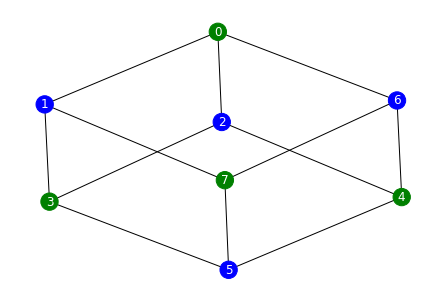

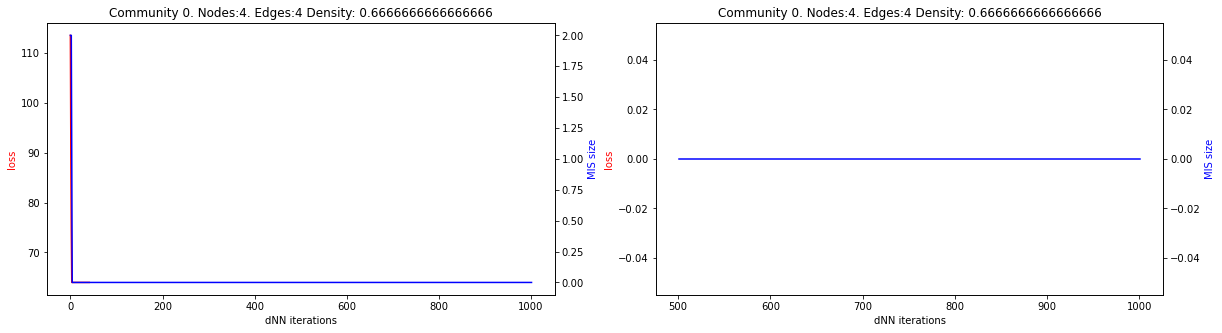

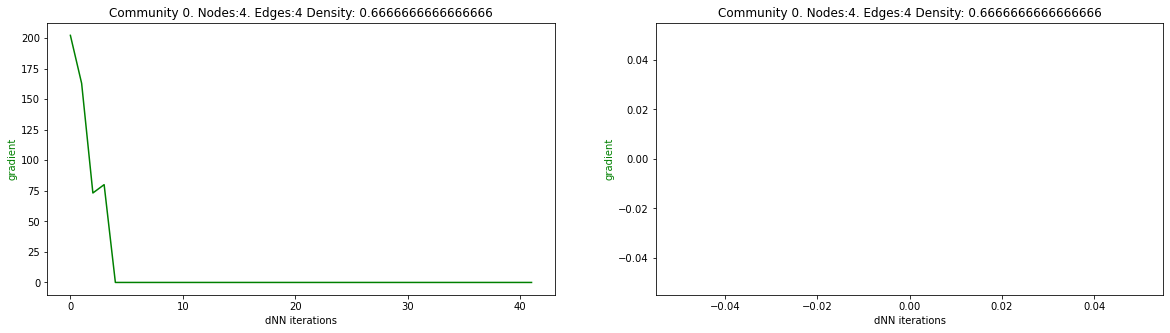

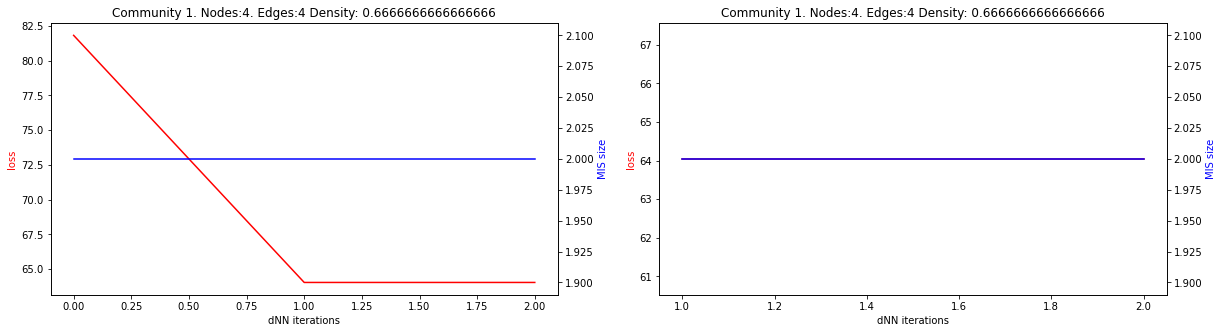

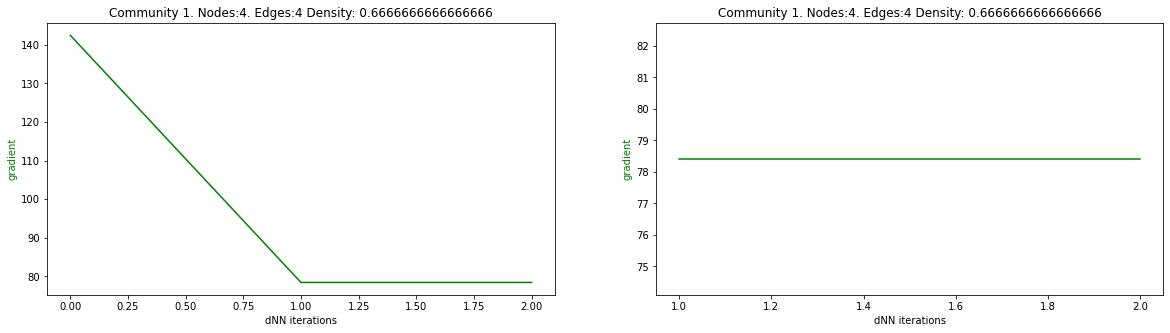

In [61]:
G = build_test_graph1()
dnn_params = DnnParams(alpha = 0.5, clipnorm=1)
calculate_DNN_result(G, calculate_large_G(G, dnn_params), "imgs/test_graph/best", True, "1")

In [62]:
G = nx.graph_atlas(200)
dnn_params = DnnParams(alpha = 0.5, clipnorm=0.0000001)
calculate_DNN_result(G, calculate_large_G(G, dnn_params), "imgs/graph_atlas_200", True, "2.png")

NetworkXError: The node 0 is not in the graph.

{0, 1, 3, 4}
Length = 4


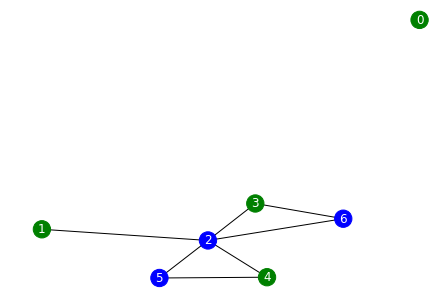

In [65]:
G = nx.graph_atlas(300)
dnn_params = DnnParams(alpha = 0.5, clipnorm=0.0000001)
calculate_DNN_result(G, calculate_large_G(G, dnn_params), True, "3.png")

INFO:root:Optimal solution found. Cardinality = 2. Epoch = 0


{1, 2, 4, 6}
Length = 4


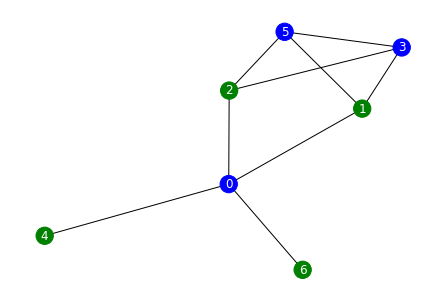

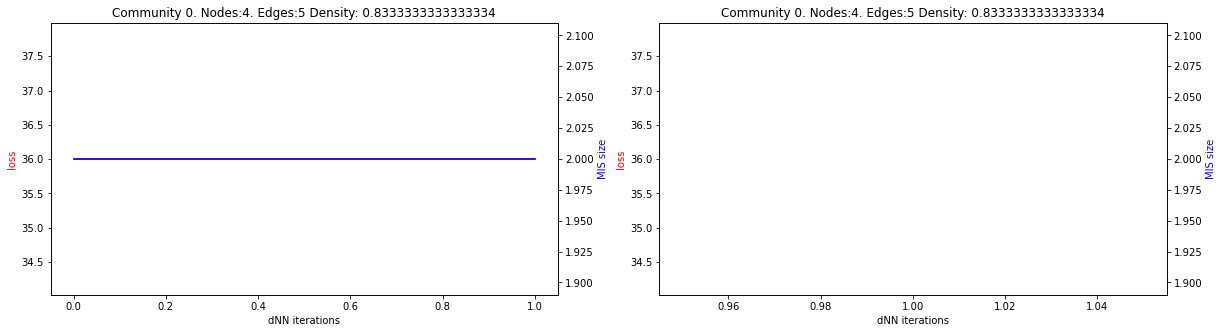

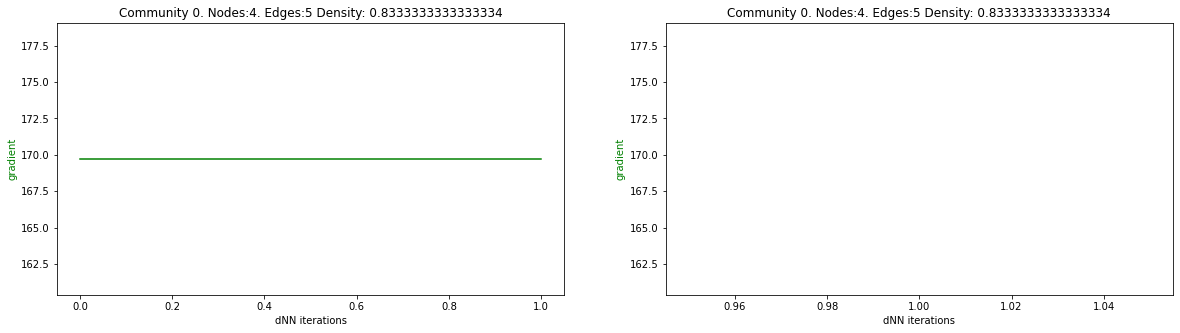

In [69]:
G = nx.graph_atlas(500)
dnn_params = DnnParams(alpha = 0.5, clipnorm=0.00001)
calculate_DNN_result(G, calculate_large_G(G, dnn_params), "imgs/graph_atlas_500", True, "4.png")

{3, 4, 5, 6}
Length = 4


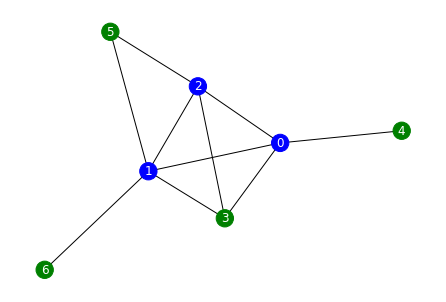

In [70]:
G = nx.graph_atlas(600)
dnn_params = DnnParams(alpha = 0.5, clipnorm=0.00001)
calculate_DNN_result(G, calculate_large_G(G, dnn_params),"imgs/graph_atlas_600", True, "5.png")

INFO:root:Optimal solution found. Cardinality = 2. Epoch = 7


{1, 3, 5}
Length = 3


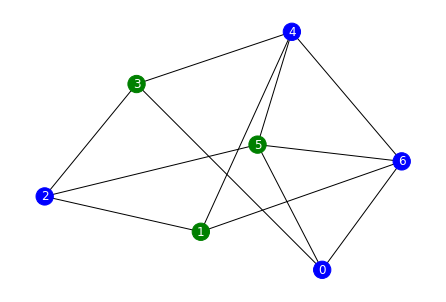

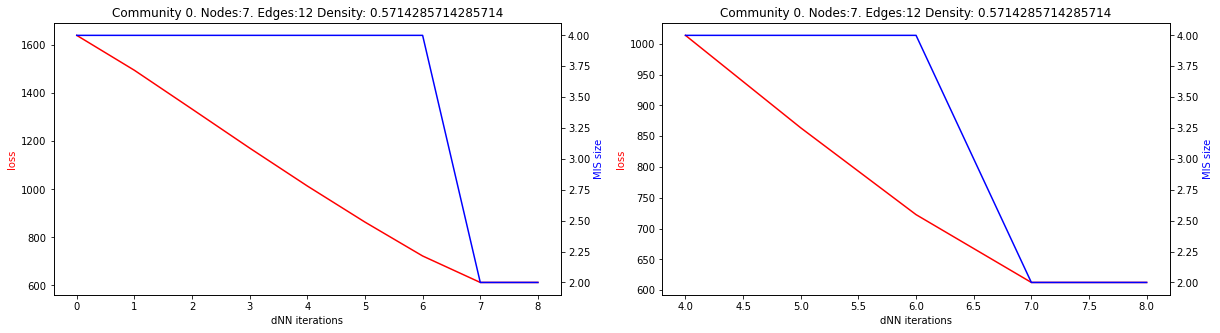

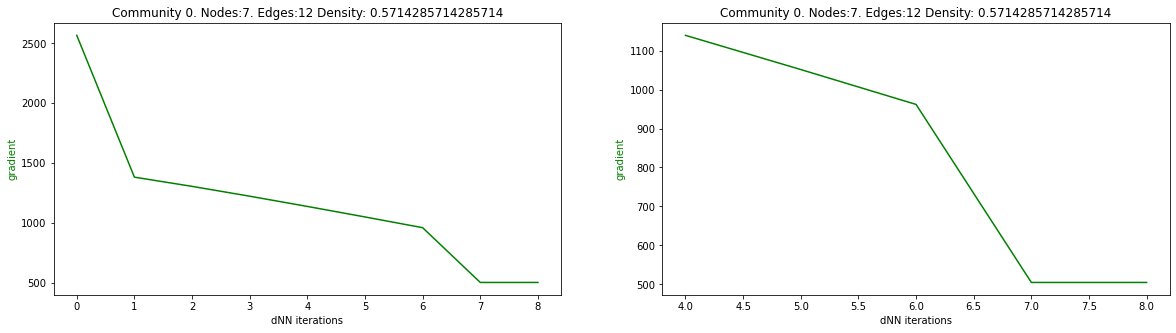

In [71]:
G = nx.graph_atlas(1000)
dnn_params = DnnParams(alpha = 0.5, clipnorm=0.00001)
calculate_DNN_result(G, calculate_large_G(G,dnn_params),"imgs/graph_atlas_1000", True, "6.png")

In [ ]:
networks = build_n_graphs(20, lambda: nx.erdos_renyi_graph(100,0.1), )

In [ ]:
test_network_on_graphs(networks)

In [ ]:
networks = build_n_graphs(10, lambda: nx.erdos_renyi_graph(100,0.2), )

In [ ]:
test_network_on_graphs(networks)

In [ ]:
networks = build_n_graphs(10, lambda: nx.erdos_renyi_graph(200,0.1))

In [ ]:
test_network_on_graphs(networks)

In [ ]:
networks = build_n_graphs(10, lambda: nx.erdos_renyi_graph(200,0.2))

In [ ]:
test_network_on_graphs(networks)

In [ ]:
def build_stochastic_params(s,p,q = 0.05):
    sizes = []
    probs = []
    for i in range(5):
        sizes.append(s)
        prob = []
        for j in range(5):
            if i != j:
                prob.append(q)
            else:
                prob.append(p)
        probs.append(prob)
    return (sizes, probs)

In [ ]:
(sizes, probs) = build_stochastic_params(50,0.1)

In [ ]:
networks = build_n_graphs(10, lambda: nx.stochastic_block_model(sizes,probs))

In [ ]:
test_network_on_graphs(networks)

In [ ]:
(sizes, probs) = build_stochastic_params(50,0.2)
networks = build_n_graphs(10, lambda: nx.stochastic_block_model(sizes,probs))
test_network_on_graphs(networks)

In [ ]:
(sizes, probs) = build_stochastic_params(70,0.1)
networks = build_n_graphs(10, lambda: nx.stochastic_block_model(sizes,probs))
test_network_on_graphs(networks)

In [ ]:
(sizes, probs) = build_stochastic_params(70,0.2)
networks = build_n_graphs(10, lambda: nx.stochastic_block_model(sizes,probs))
test_network_on_graphs(networks)

In [ ]:
networks=build_n_graphs(10, lambda: nx.barabasi_albert_graph(100,45))
test_network_on_graphs(networks)

In [ ]:
networks = build_n_graphs(10, lambda: nx.barabasi_albert_graph(200,100))
networks += build_n_graphs(10, lambda: nx.barabasi_albert_graph(200,90))

In [ ]:
test_network_on_graphs(networks)

In [ ]:
networks = build_n_graphs(10, lambda: nx.powerlaw_cluster_graph(100,30,0.5))

In [ ]:
test_network_on_graphs(networks)

In [ ]:
networks = build_n_graphs(10, lambda: nx.powerlaw_cluster_graph(200,60,0.5))

In [ ]:
test_network_on_graphs(networks)

In [ ]:
measure_time_and_result("datasets/Wiki-Vote.txt","datasets/Wiki_Vote.metis", reindex = True,)

In [ ]:
measure_time_and_result("datasets/c1000_9/C1000-9.mtx","datasets/c1000_9/C1000-9_compl.metis", "imgs/c1000_9/communities", complement = True, reindex = True,)

In [ ]:
measure_time_and_result("datasets/c125-9/C125-9.mtx","datasets/c125-9/C125-9.metis", "imgs/c125-9", complement = True, reindex = True,)


In [ ]:
measure_time_and_result("datasets/C4000-5/C4000-5.mtx","datasets/C4000-5/C4000-5_compl.metis","imgs/c4000-5", complement = True, reindex = True) # Too long to wait

In [ ]:
measure_time_and_result("datasets/Slashdot0811.txt","datasets/Slashdot0811.metis") # Too long to wait

Graph with 200 nodes and 5066 edges


INFO:root:Epoch: 10. Loss: 230248.859375. Gradient norm: 5168.06201171875. Clipnorm: 1e-05. Learning rate:0.1. Mis size: 1
INFO:root:Epoch: 20. Loss: 224771.59375. Gradient norm: 42489.59375. Clipnorm: 1e-05. Learning rate:0.1. Mis size: 4
INFO:root:Optimal solution found. Cardinality = 5. Epoch = 25
INFO:root:Epoch: 10. Loss: 936195.75. Gradient norm: 6418.1474609375. Clipnorm: 1e-05. Learning rate:0.1. Mis size: 1
INFO:root:Epoch: 20. Loss: 918567.5625. Gradient norm: 70559.453125. Clipnorm: 1e-05. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 30. Loss: 909306.4375. Gradient norm: 79255.84375. Clipnorm: 1e-05. Learning rate:0.1. Mis size: 5
INFO:root:Optimal solution found. Cardinality = 7. Epoch = 39
INFO:root:Epoch: 10. Loss: 69871.1484375. Gradient norm: 1495.2847900390625. Clipnorm: 1e-05. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 20. Loss: 67014.765625. Gradient norm: 8892.548828125. Clipnorm: 1e-05. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 30. Loss: 63704.2148437

MIS length:19
Time used: 3.6030688285827637 seconds


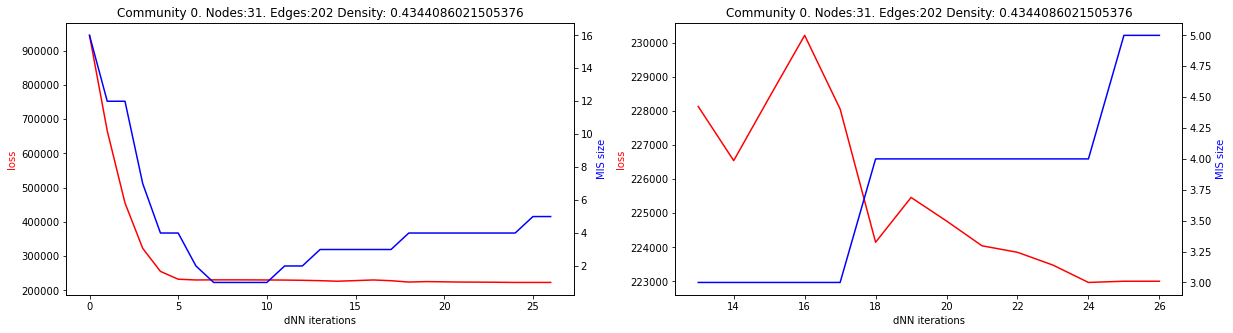

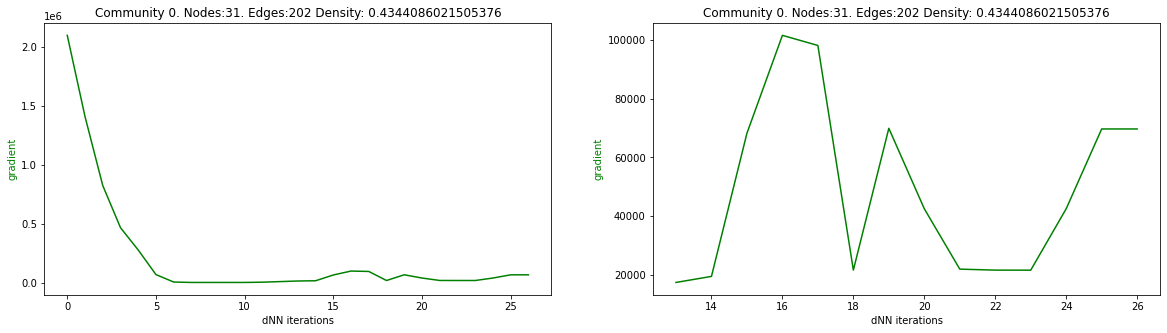

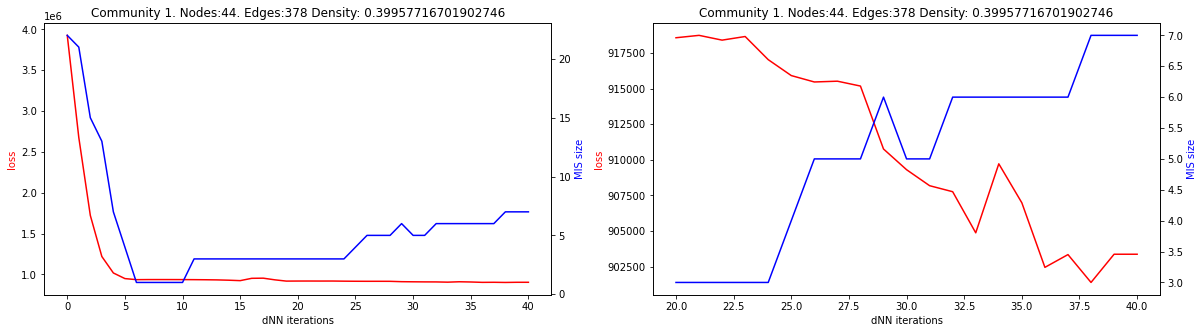

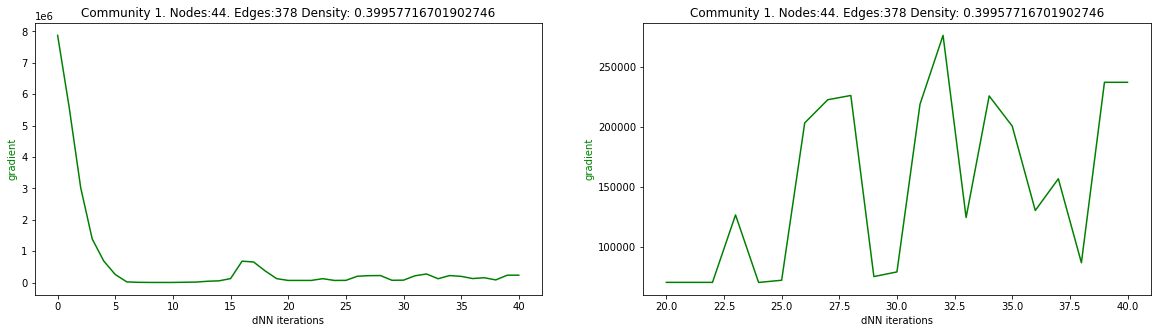

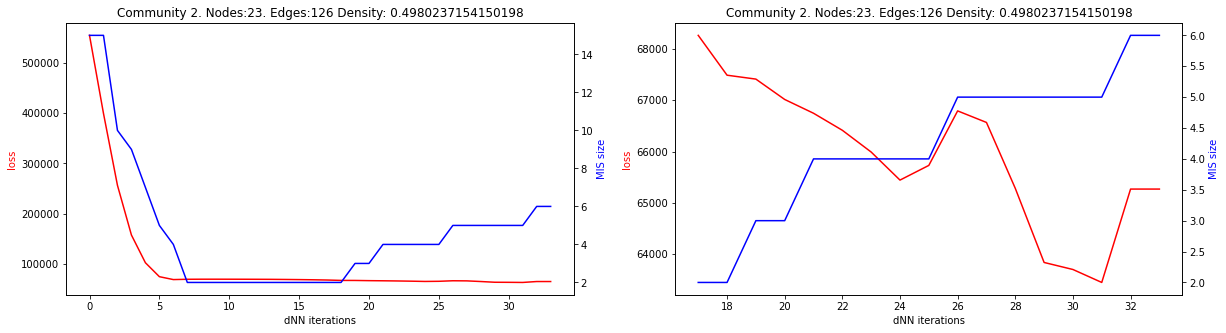

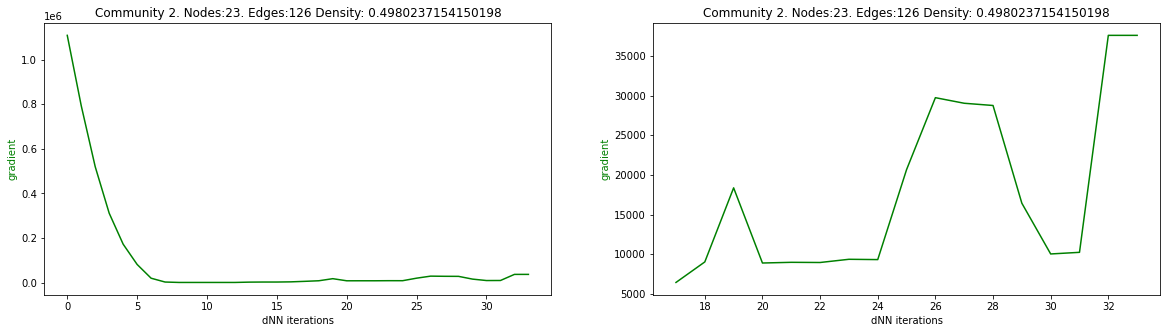

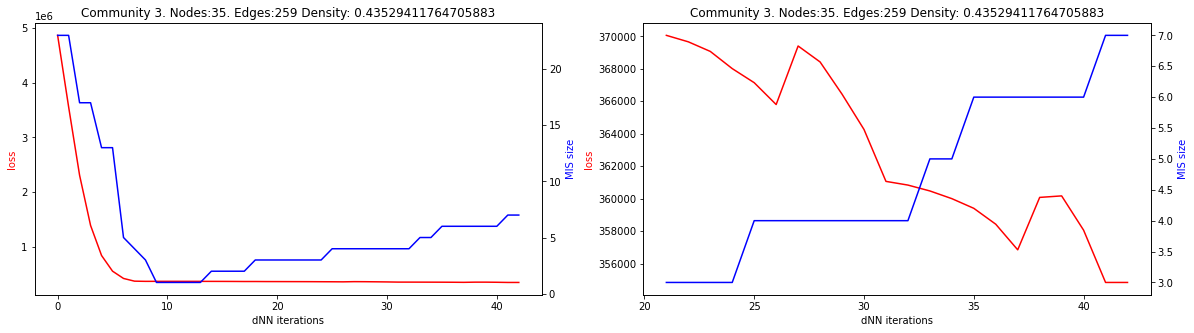

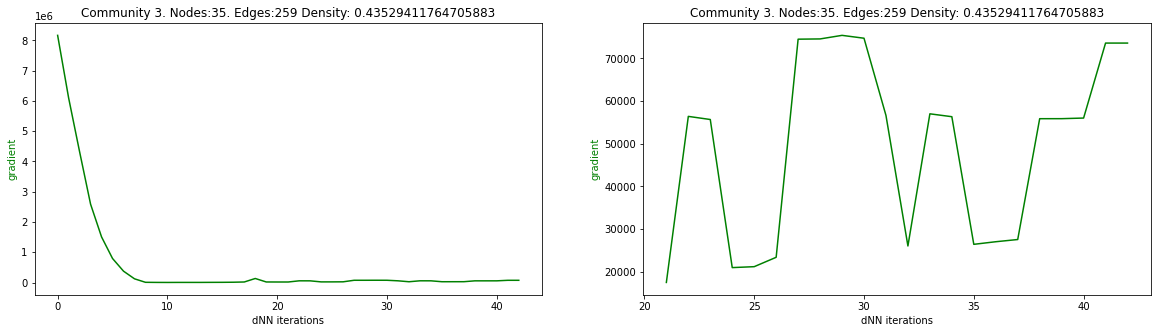

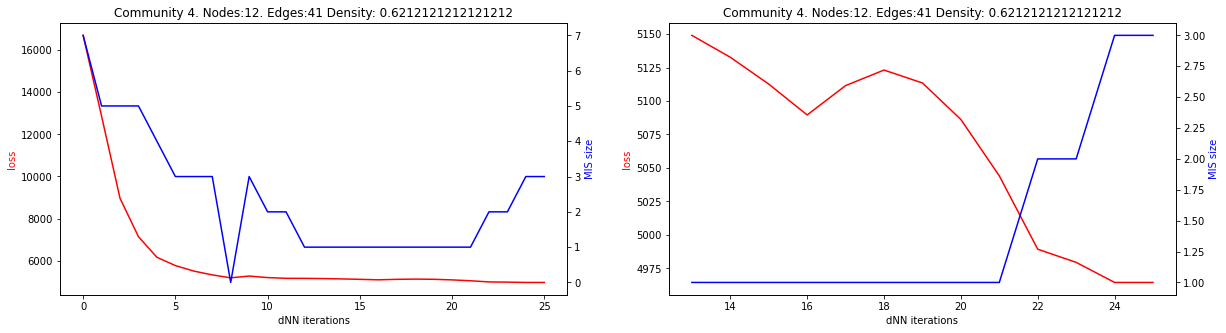

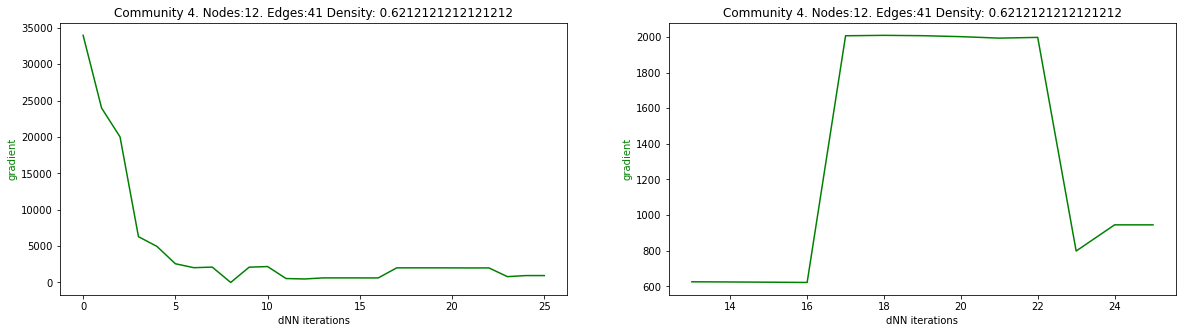

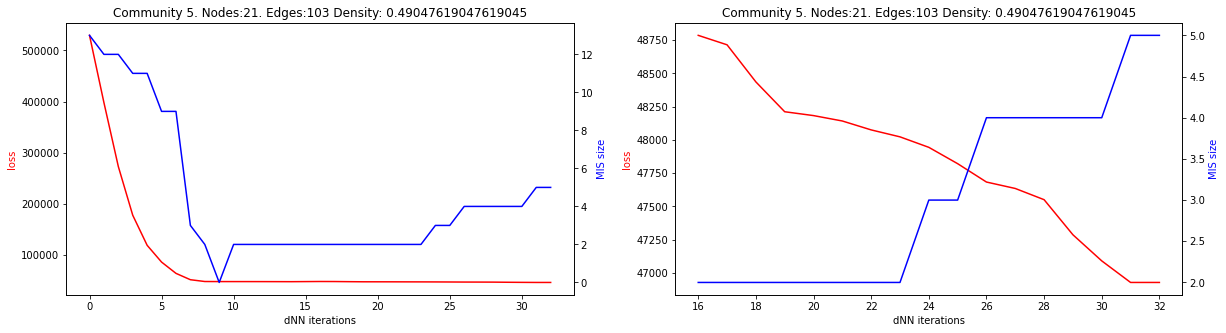

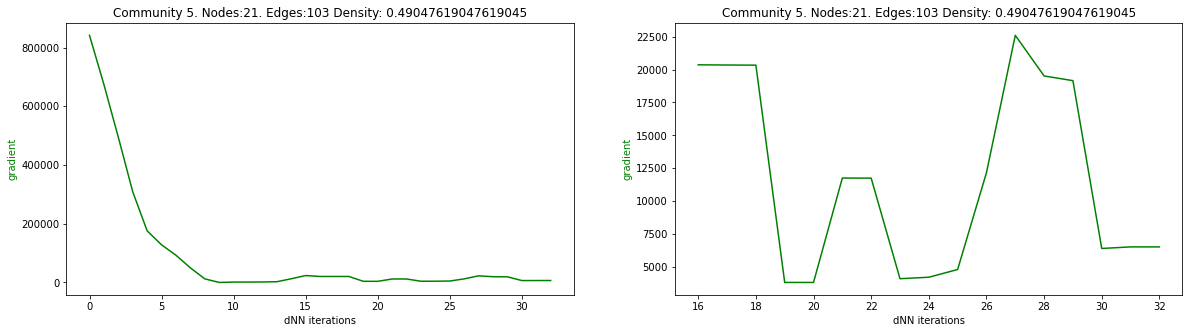

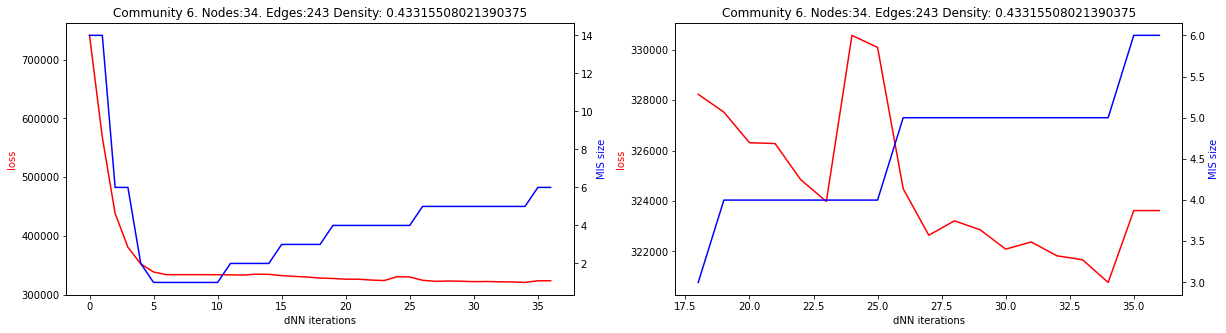

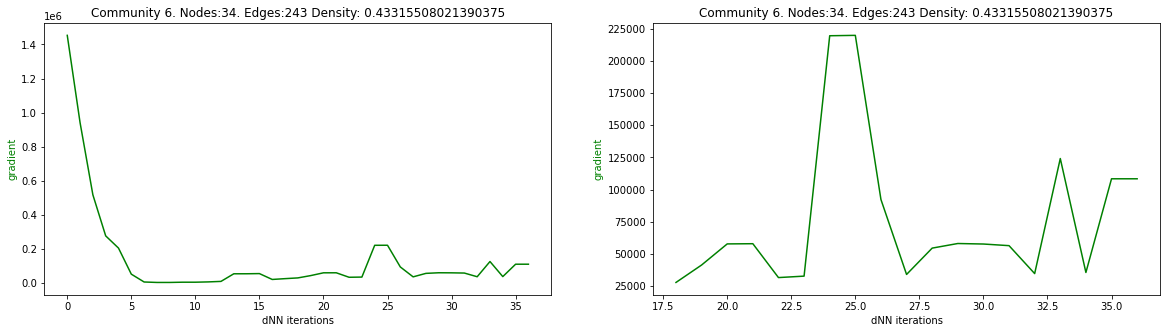

In [67]:
dnn_params = DnnParams(alpha = 0.5, clipnorm=0.00001, max_epochs=4000)
# dnn_params = DnnParams(alpha = 0.5, clipnorm=10000000000000000)
measure_time_and_result("datasets/brock200-1/brock200-1.mtx",
                        "datasets/brock200-1/brock200-1.metis",
                        "imgs/brock200-1/com",
                        dnn_params,
                        complement = True, reindex = True,)

In [112]:
def draw_analysis_plots(results_list, graph_name):
    epochs_list = []
    mis_size_list = []
    loss_list = [] 
    
    for res in results_list:
        mis_size_list.append(res.communities_result[0].mis_size_arr[-1])
        loss_list.append(res.communities_result[0].loss_arr[-1])
        epochs_list.append(len(res.communities_result[0].loss_arr))

    fig = plt.figure()
    ax = fig.add_subplot(2, 1, 1)
    line, = ax.plot(clipnorm_list, mis_size_list, color ="blue")
    ax.set_title("Size of founded MIS dependind on clipnorm")
    ax.set_xlabel("Clipnorm", )
    ax.set_ylabel("MIS size", color="blue")
    ax.set_xscale('log')
    plt.savefig("MIS_size_{}".format(graph_name))
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(2, 1, 1)
    line, = ax.plot(clipnorm_list, loss_list, color ="red")
    ax.set_title("Final loss value depending on clipnorm")
    ax.set_xlabel("Clipnorm", )
    ax.set_ylabel("Loss", color="red")
    ax.set_xscale('log')
    plt.savefig("Loss_{}".format(graph_name))
    plt.show()


    fig = plt.figure()
    ax = fig.add_subplot(2, 1, 1)
    line, = ax.plot(clipnorm_list, epochs_list, color ="green")
    ax.set_title("Epochs quantity depending on clipnorm")
    ax.set_xlabel("Clipnorm", )
    ax.set_ylabel("Epochs", color="green")
    ax.set_xscale('log')
    plt.savefig("Epochs_{}".format(graph_name))
    plt.show()

In [114]:
results_list

ValueError: x and y must have same first dimension, but have shapes (9,) and (1,)

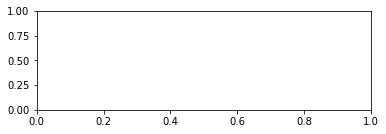

In [113]:
draw_analysis_plots(results_list, "sanr_200_9")

Graph with 200 nodes and 2037 edges


INFO:root:Epoch: 10. Loss: 400100384.0. Gradient norm: 11175086.0. Clipnorm: 1. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 20. Loss: 399489056.0. Gradient norm: 812376.6875. Clipnorm: 1. Learning rate:0.1. Mis size: 5
INFO:root:Epoch: 30. Loss: 399369472.0. Gradient norm: 10976564.0. Clipnorm: 1. Learning rate:0.1. Mis size: 8
INFO:root:Epoch: 40. Loss: 398721024.0. Gradient norm: 903648.5. Clipnorm: 1. Learning rate:0.1. Mis size: 8
INFO:root:dNN solution is not correct. Epoch = 40


MIS length:37
Time used: 1.104527235031128 seconds


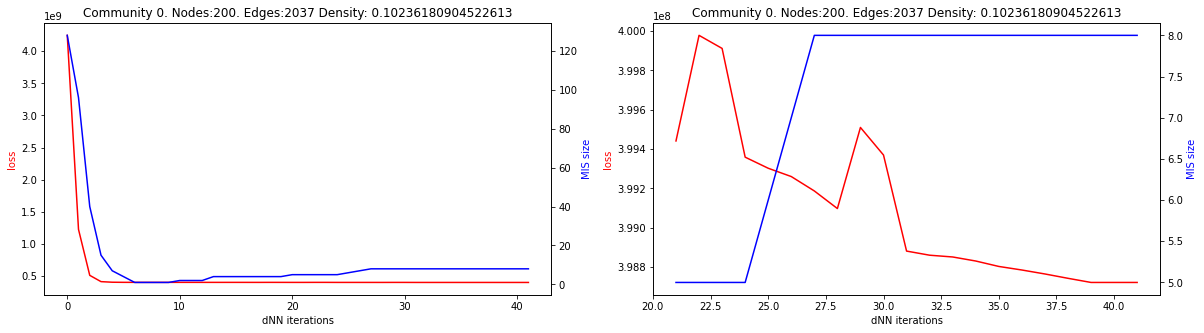

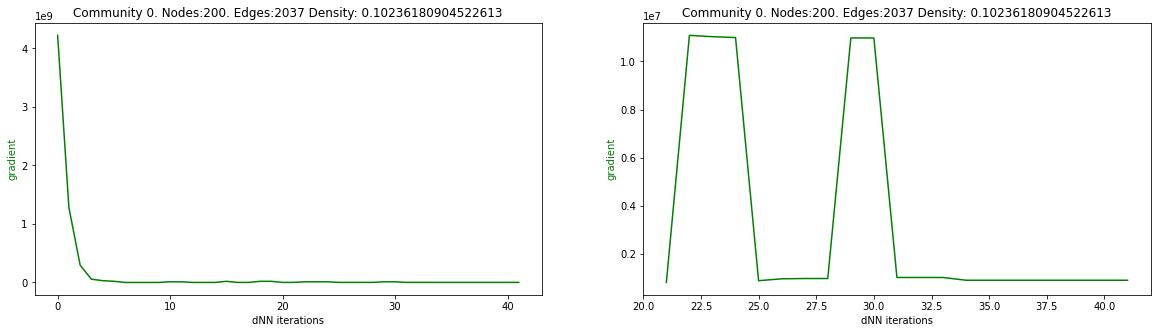

Graph with 200 nodes and 10024 edges


INFO:root:Epoch: 10. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 1. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 20. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 1. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 30. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 1. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 40. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 1. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 50. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 1. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 60. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 1. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 70. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 1. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 80. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 1. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 90. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 1. Learning rate:0.1. Mis size: 0
INFO:root:dNN solution is not correct. Epoch = 93


MIS length:9
Time used: 3.0285427570343018 seconds


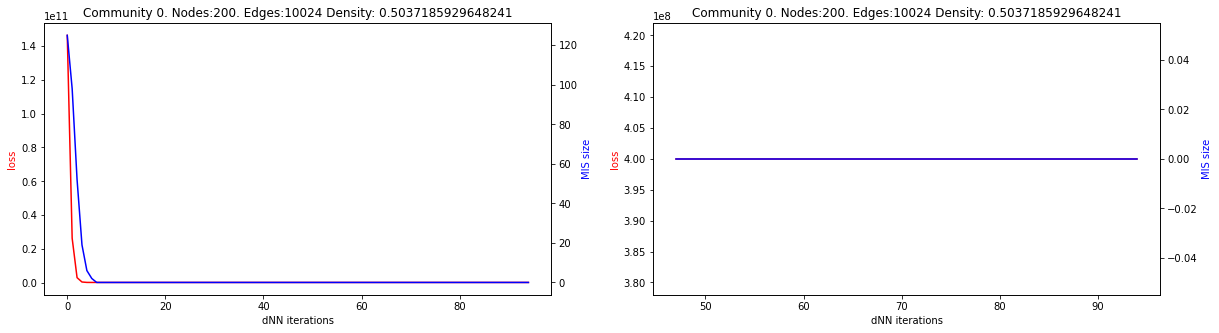

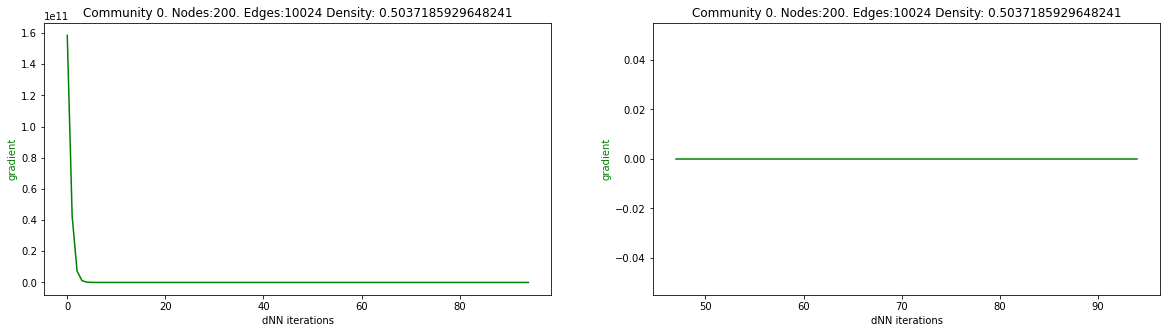

Graph with 171 nodes and 5100 edges


INFO:root:Epoch: 10. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 1. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 20. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 1. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 30. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 1. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 40. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 1. Learning rate:0.1. Mis size: 0
INFO:root:dNN solution is not correct. Epoch = 47


MIS length:11
Time used: 1.3245174884796143 seconds


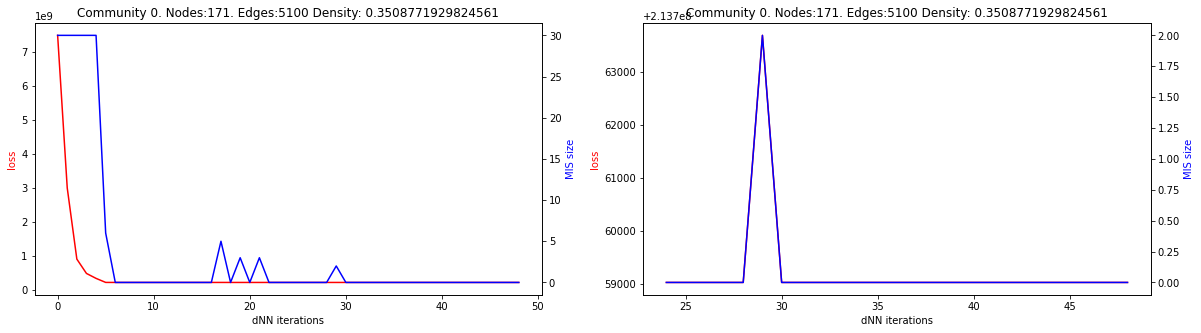

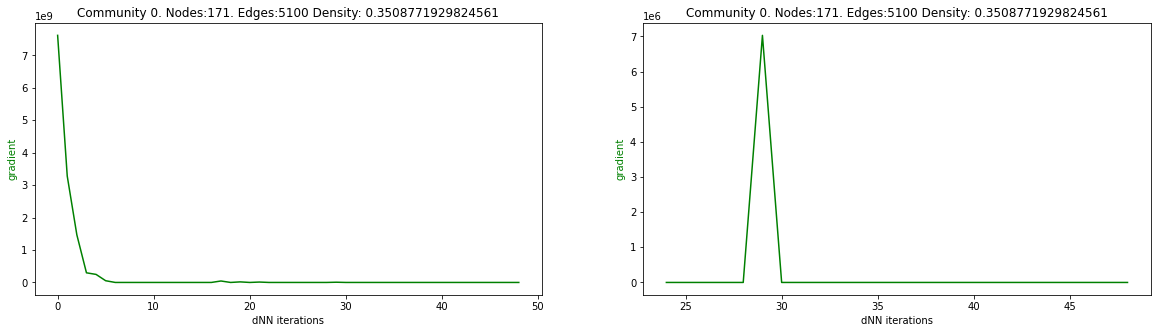

Graph with 300 nodes and 11460 edges


INFO:root:Epoch: 10. Loss: 2025214080.0. Gradient norm: 37507156.0. Clipnorm: 1. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 20. Loss: 2023274496.0. Gradient norm: 2884389.75. Clipnorm: 1. Learning rate:0.1. Mis size: 6
INFO:root:Epoch: 30. Loss: 2016901120.0. Gradient norm: 4916355.0. Clipnorm: 1. Learning rate:0.1. Mis size: 14
INFO:root:dNN solution is not correct. Epoch = 36


MIS length:30
Time used: 2.3784713745117188 seconds


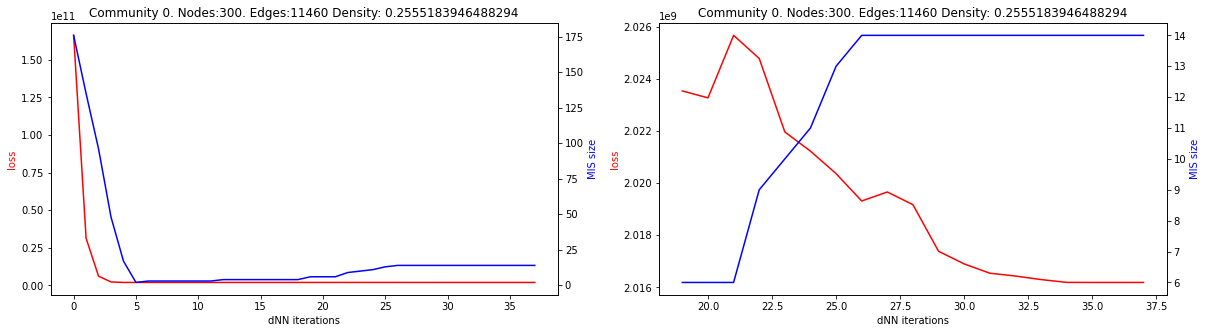

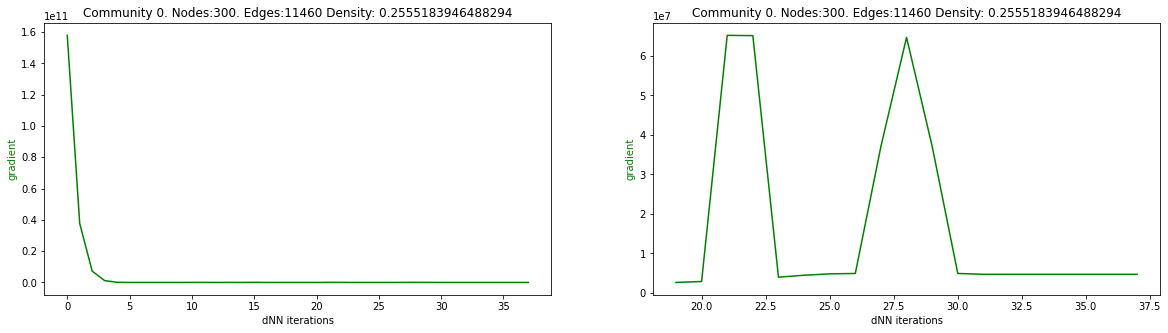

Graph with 200 nodes and 2037 edges


INFO:root:Epoch: 10. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 0.1. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 20. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 0.1. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 30. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 0.1. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 40. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 0.1. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 50. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 0.1. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 60. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 0.1. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 70. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 0.1. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 80. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 0.1. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 90. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 0.1. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 100. Loss: 400000000.0. Gradi

MIS length:33
Time used: 2.4010372161865234 seconds


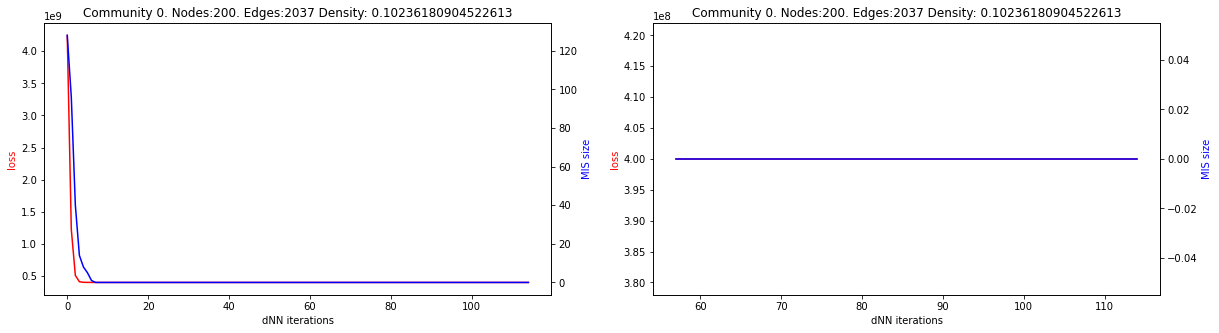

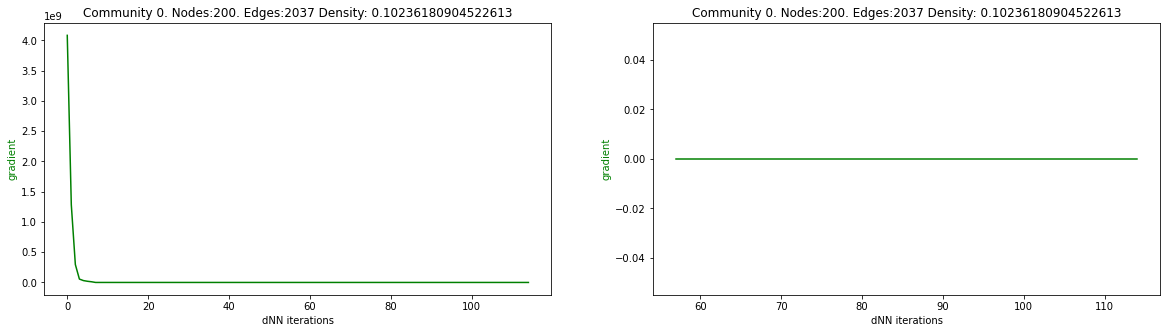

Graph with 200 nodes and 10024 edges


INFO:root:Epoch: 10. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 0.1. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 20. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 0.1. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 30. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 0.1. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 40. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 0.1. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 50. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 0.1. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 60. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 0.1. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 70. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 0.1. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 80. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 0.1. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 90. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 0.1. Learning rate:0.1. Mis size: 0
INFO:root:dNN solution is not correct. Epoch =

MIS length:9
Time used: 3.243065118789673 seconds


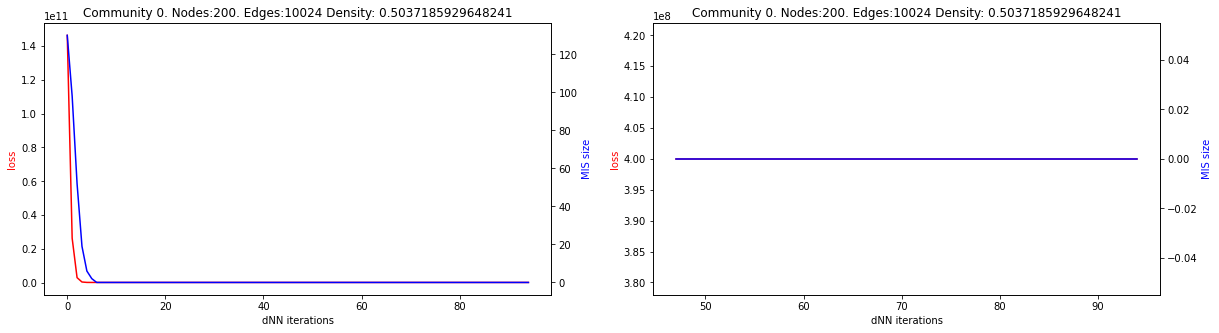

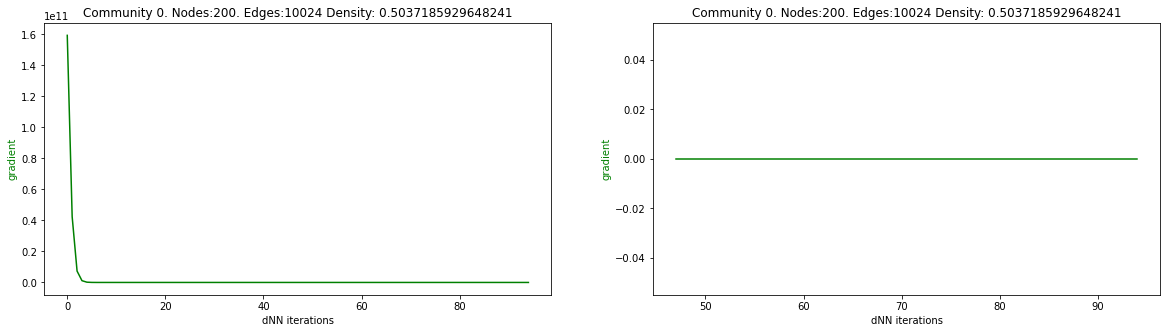

Graph with 171 nodes and 5100 edges


INFO:root:Epoch: 10. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 0.1. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 20. Loss: 213827424.0. Gradient norm: 17273354.0. Clipnorm: 0.1. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 30. Loss: 213920128.0. Gradient norm: 17277150.0. Clipnorm: 0.1. Learning rate:0.1. Mis size: 1
INFO:root:Epoch: 40. Loss: 213703088.0. Gradient norm: 109395.4921875. Clipnorm: 0.1. Learning rate:0.1. Mis size: 2
INFO:root:dNN solution is not correct. Epoch = 44


MIS length:9
Time used: 1.1130390167236328 seconds


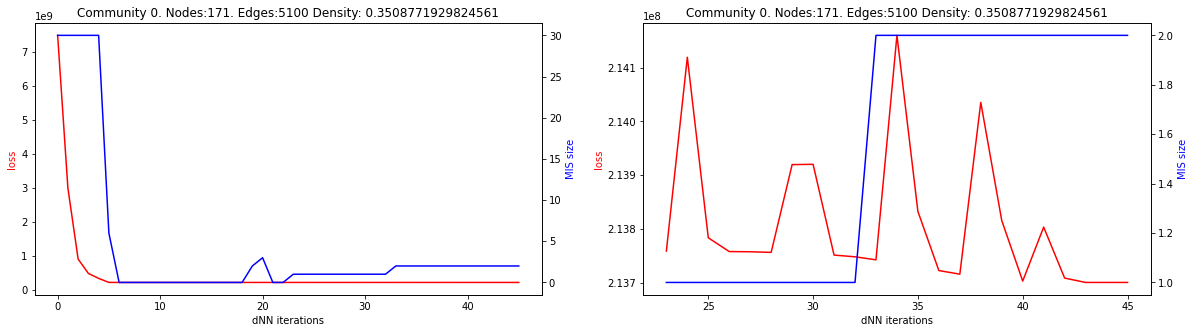

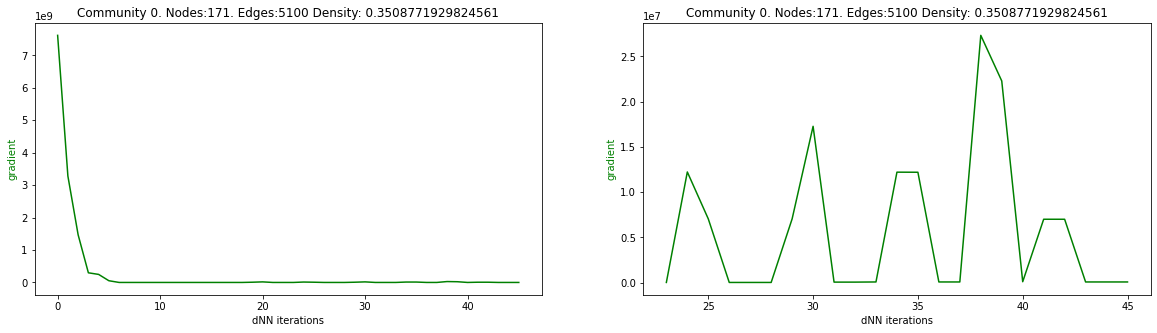

Graph with 300 nodes and 11460 edges


INFO:root:Epoch: 10. Loss: 2024789120.0. Gradient norm: 1068635.125. Clipnorm: 0.1. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 20. Loss: 2025055872.0. Gradient norm: 65194328.0. Clipnorm: 0.1. Learning rate:0.1. Mis size: 8
INFO:root:Epoch: 30. Loss: 2016781824.0. Gradient norm: 36652340.0. Clipnorm: 0.1. Learning rate:0.1. Mis size: 19
INFO:root:Epoch: 40. Loss: 2010615424.0. Gradient norm: 36802812.0. Clipnorm: 0.1. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 50. Loss: 2008212608.0. Gradient norm: 8949612.0. Clipnorm: 0.1. Learning rate:0.1. Mis size: 19
INFO:root:Epoch: 60. Loss: 2007137280.0. Gradient norm: 36478100.0. Clipnorm: 0.1. Learning rate:0.1. Mis size: 20
INFO:root:Epoch: 70. Loss: 2008625792.0. Gradient norm: 36491620.0. Clipnorm: 0.1. Learning rate:0.1. Mis size: 20
INFO:root:Epoch: 80. Loss: 2007328000.0. Gradient norm: 8548378.0. Clipnorm: 0.1. Learning rate:0.1. Mis size: 19
INFO:root:Epoch: 90. Loss: 2007383040.0. Gradient norm: 8548494.0. Clipnorm: 0.1. L

MIS length:30
Time used: 15.142321586608887 seconds


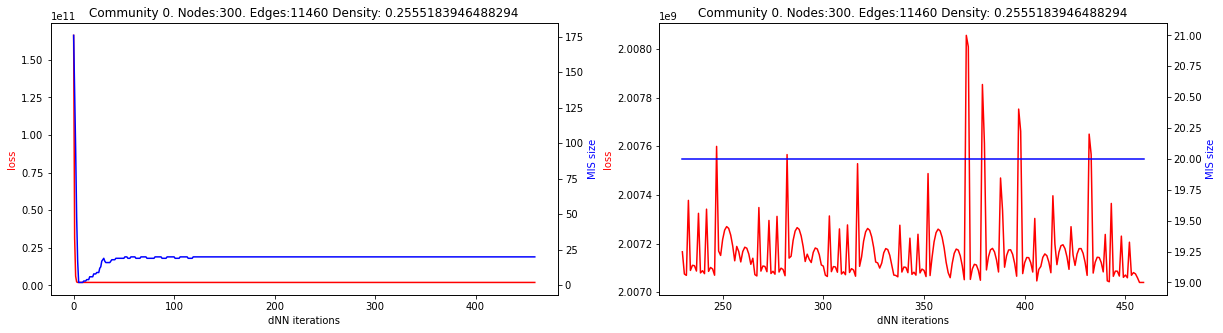

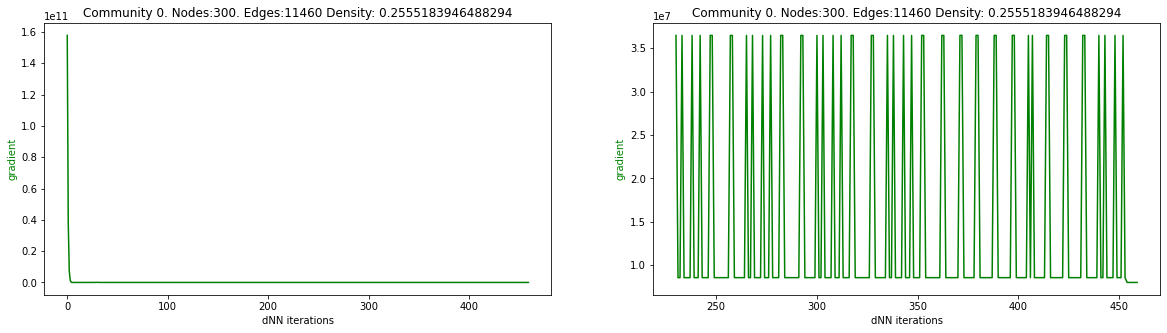

Graph with 200 nodes and 2037 edges


INFO:root:Epoch: 10. Loss: 399842208.0. Gradient norm: 564158.125. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 20. Loss: 399052128.0. Gradient norm: 10795406.0. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 7
INFO:root:Epoch: 30. Loss: 397363104.0. Gradient norm: 15135960.0. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 16
INFO:root:Epoch: 40. Loss: 393957760.0. Gradient norm: 4215712.0. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 16
INFO:root:Epoch: 50. Loss: 393641632.0. Gradient norm: 4172527.25. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 17
INFO:root:Epoch: 60. Loss: 393302496.0. Gradient norm: 4218548.5. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 70. Loss: 393552448.0. Gradient norm: 18039940.0. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 20
INFO:root:Epoch: 80. Loss: 393393984.0. Gradient norm: 18002252.0. Clipnorm: 0.01000000

INFO:root:Epoch: 640. Loss: 392870112.0. Gradient norm: 3511834.0. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 650. Loss: 392847648.0. Gradient norm: 3511734.0. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 660. Loss: 392859264.0. Gradient norm: 3511785.5. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 670. Loss: 392869024.0. Gradient norm: 10690222.0. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 20
INFO:root:Epoch: 680. Loss: 392870016.0. Gradient norm: 10690236.0. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 20
INFO:root:Epoch: 690. Loss: 392973152.0. Gradient norm: 10691642.0. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 20
INFO:root:Epoch: 700. Loss: 392867552.0. Gradient norm: 3511822.75. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 710. Loss: 392864448.0. Gradient norm: 3511808.75. Clipnorm: 0

INFO:root:Epoch: 1270. Loss: 392883968.0. Gradient norm: 3511895.75. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 1280. Loss: 392851296.0. Gradient norm: 3511749.5. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 1290. Loss: 392840544.0. Gradient norm: 3511702.0. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 1300. Loss: 392858336.0. Gradient norm: 10690076.0. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 20
INFO:root:Epoch: 1310. Loss: 392860128.0. Gradient norm: 3511789.5. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 1320. Loss: 392856864.0. Gradient norm: 3511775.25. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 1330. Loss: 392883648.0. Gradient norm: 3511894.75. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 1340. Loss: 392863296.0. Gradient norm: 3511803.75. Cli

INFO:root:Epoch: 1890. Loss: 392856704.0. Gradient norm: 3511774.0. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 1900. Loss: 392845408.0. Gradient norm: 10689904.0. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 20
INFO:root:Epoch: 1910. Loss: 392834560.0. Gradient norm: 3511675.75. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 1920. Loss: 392866784.0. Gradient norm: 3511819.5. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 1930. Loss: 392850208.0. Gradient norm: 3511745.25. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 1940. Loss: 392883104.0. Gradient norm: 3511892.25. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 1950. Loss: 392869952.0. Gradient norm: 3511833.5. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 1960. Loss: 392874048.0. Gradient norm: 3511851.5. Clip

MIS length:37
Time used: 39.85673689842224 seconds


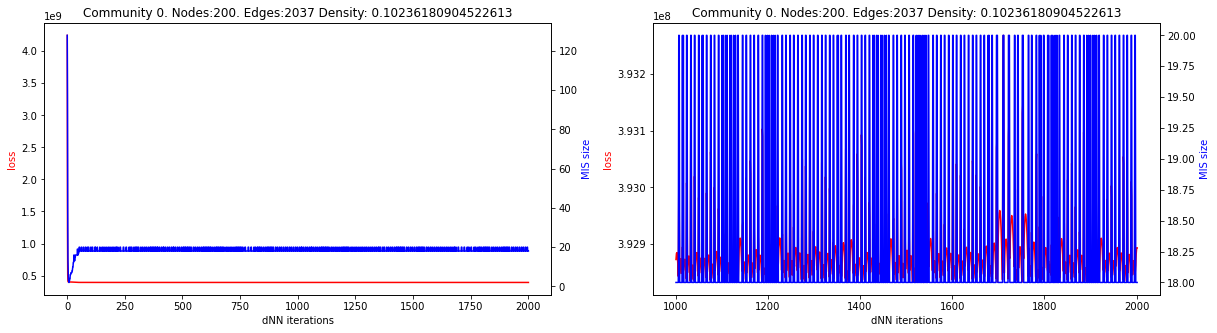

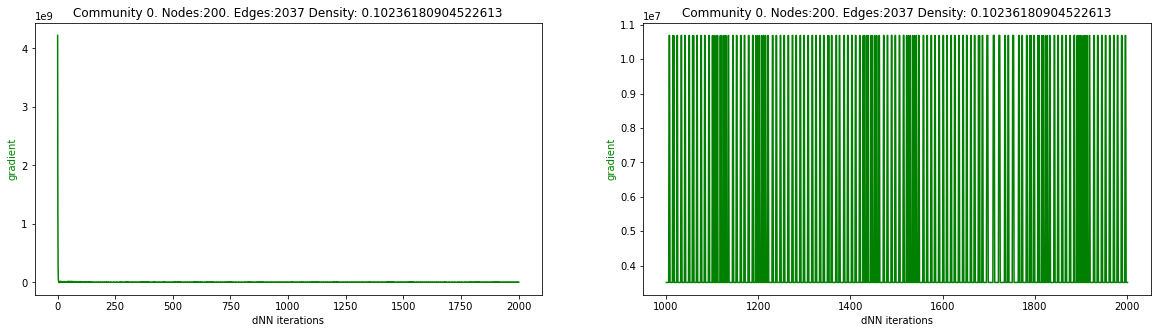

Graph with 200 nodes and 10024 edges


INFO:root:Epoch: 10. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 0
INFO:root:dNN solution is not correct. Epoch = 15


MIS length:8
Time used: 1.4305148124694824 seconds


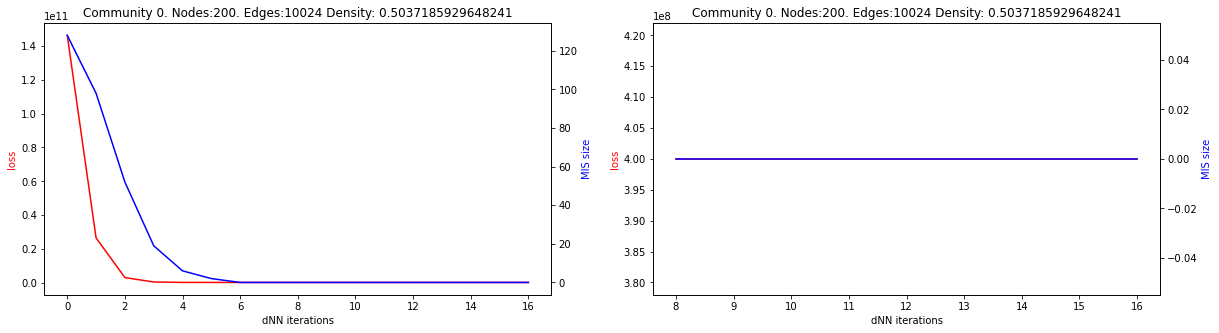

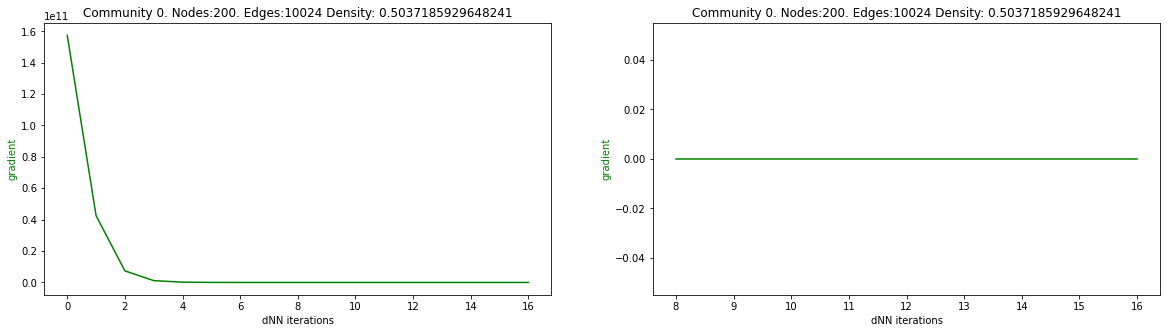

Graph with 171 nodes and 5100 edges


INFO:root:Epoch: 10. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 20. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 30. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 40. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 50. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 60. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 70. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 80. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 0
INFO:root:Epoch:

MIS length:11
Time used: 1.9730308055877686 seconds


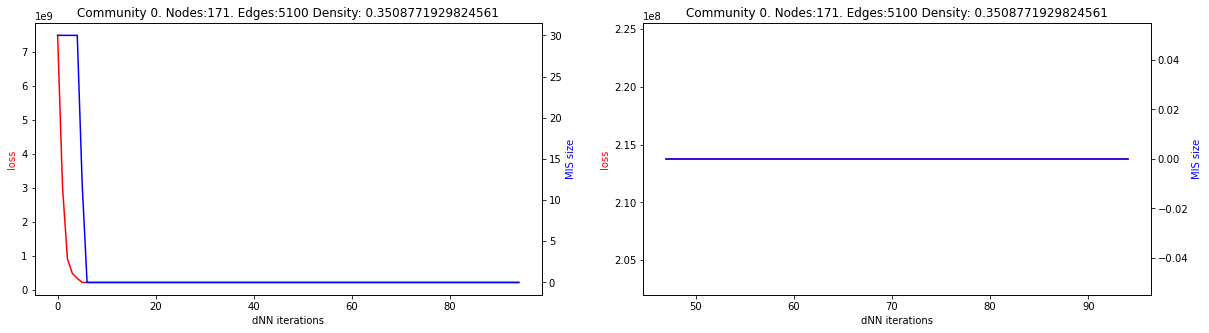

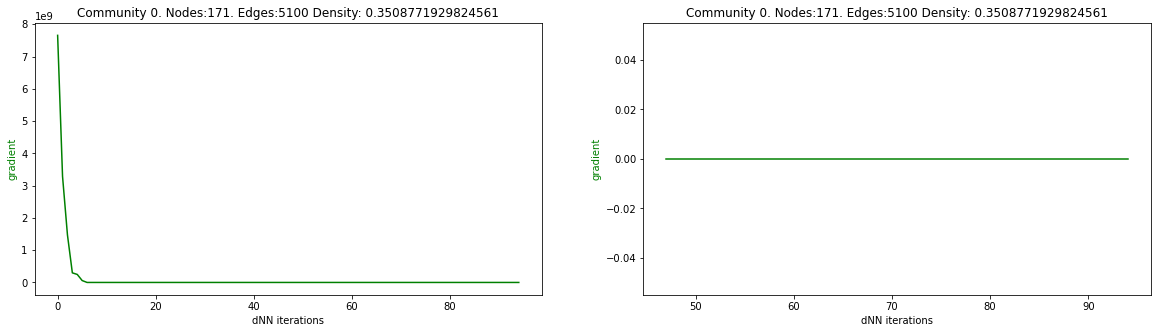

Graph with 300 nodes and 11460 edges


INFO:root:Epoch: 10. Loss: 2024695936.0. Gradient norm: 899932.4375. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 20. Loss: 2025468288.0. Gradient norm: 37470720.0. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 8
INFO:root:Epoch: 30. Loss: 2016421504.0. Gradient norm: 5958620.0. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 14
INFO:root:Epoch: 40. Loss: 2014735872.0. Gradient norm: 6150502.5. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 16
INFO:root:Epoch: 50. Loss: 2013730944.0. Gradient norm: 5743951.5. Clipnorm: 0.010000000000000002. Learning rate:0.1. Mis size: 16
INFO:root:dNN solution is not correct. Epoch = 55


MIS length:22
Time used: 2.7005417346954346 seconds


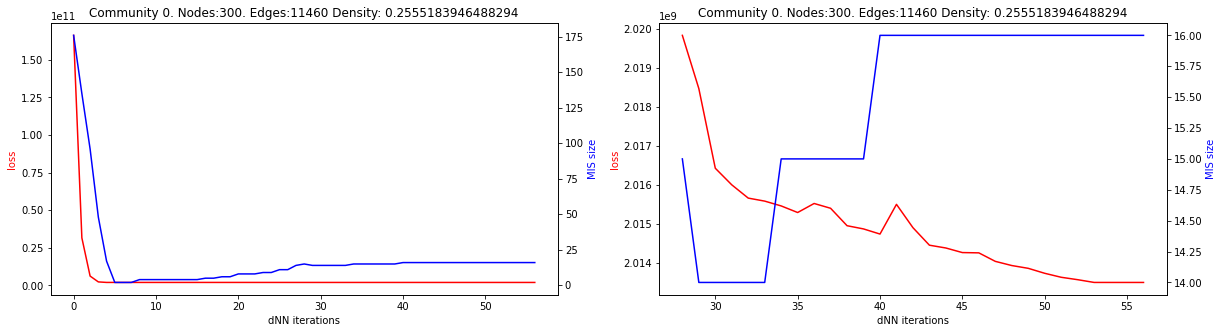

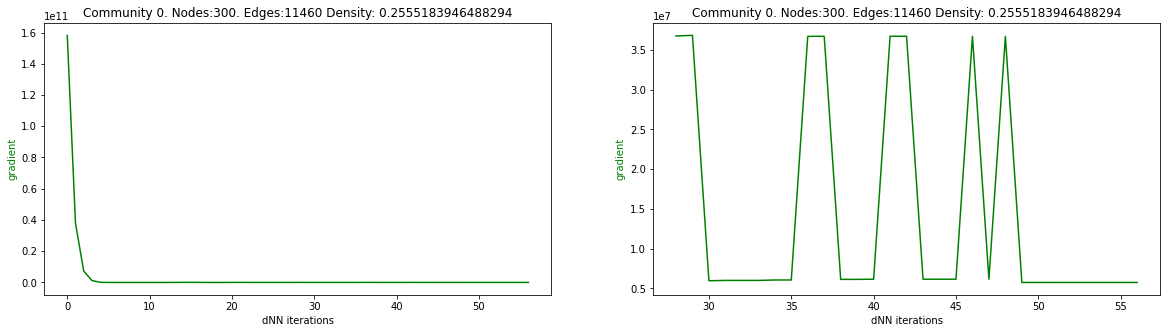

Graph with 200 nodes and 2037 edges


INFO:root:Epoch: 10. Loss: 399855104.0. Gradient norm: 805831.6875. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 20. Loss: 398167488.0. Gradient norm: 3501254.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 9
INFO:root:Epoch: 30. Loss: 395643488.0. Gradient norm: 18260568.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 20
INFO:root:Epoch: 40. Loss: 391265408.0. Gradient norm: 11939058.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 23
INFO:root:Epoch: 50. Loss: 389578848.0. Gradient norm: 15309372.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 24
INFO:root:Epoch: 60. Loss: 388718720.0. Gradient norm: 11664178.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 25
INFO:root:Epoch: 70. Loss: 388411040.0. Gradient norm: 15162058.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 25
INFO:root:Epoch: 80. Loss: 388234752.0. Gradient norm: 18803128.0. Clipnorm: 0

INFO:root:Epoch: 630. Loss: 387568896.0. Gradient norm: 5874975.5. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 24
INFO:root:Epoch: 640. Loss: 387910176.0. Gradient norm: 18645576.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 24
INFO:root:Epoch: 650. Loss: 387758016.0. Gradient norm: 11371301.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 24
INFO:root:Epoch: 660. Loss: 387501376.0. Gradient norm: 11332712.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 24
INFO:root:Epoch: 670. Loss: 387655872.0. Gradient norm: 11325186.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 23
INFO:root:Epoch: 680. Loss: 387627328.0. Gradient norm: 11366178.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 23
INFO:root:Epoch: 690. Loss: 387562208.0. Gradient norm: 5849802.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 24
INFO:root:Epoch: 700. Loss: 387561504.0. Gradient norm: 5874919.5. Clip

INFO:root:Epoch: 1250. Loss: 387722880.0. Gradient norm: 11367579.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 23
INFO:root:Epoch: 1260. Loss: 387622944.0. Gradient norm: 5850262.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 24
INFO:root:Epoch: 1270. Loss: 387623584.0. Gradient norm: 11390173.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 24
INFO:root:Epoch: 1280. Loss: 387545664.0. Gradient norm: 11315907.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 25
INFO:root:Epoch: 1290. Loss: 387584512.0. Gradient norm: 11365549.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 23
INFO:root:Epoch: 1300. Loss: 387780544.0. Gradient norm: 23789480.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 24
INFO:root:Epoch: 1310. Loss: 387585184.0. Gradient norm: 5875099.5. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 24
INFO:root:Epoch: 1320. Loss: 387559520.0. Gradient norm: 5831335

INFO:root:Epoch: 1870. Loss: 387536672.0. Gradient norm: 11388897.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 24
INFO:root:Epoch: 1880. Loss: 387631104.0. Gradient norm: 18636830.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 25
INFO:root:Epoch: 1890. Loss: 387595744.0. Gradient norm: 5850055.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 24
INFO:root:Epoch: 1900. Loss: 387512768.0. Gradient norm: 11336232.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 25
INFO:root:Epoch: 1910. Loss: 387632032.0. Gradient norm: 5850330.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 24
INFO:root:Epoch: 1920. Loss: 387680864.0. Gradient norm: 5826262.5. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 22
INFO:root:Epoch: 1930. Loss: 387533280.0. Gradient norm: 11377886.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 25
INFO:root:Epoch: 1940. Loss: 387588416.0. Gradient norm: 5831552.

MIS length:38
Time used: 40.17819666862488 seconds


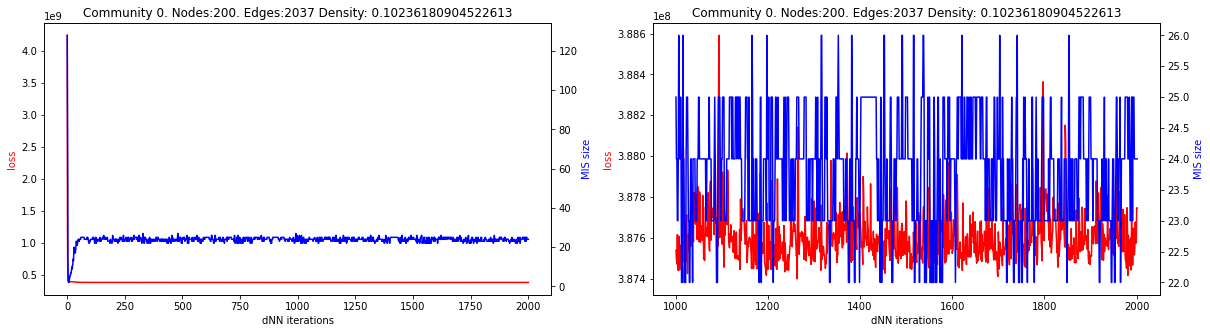

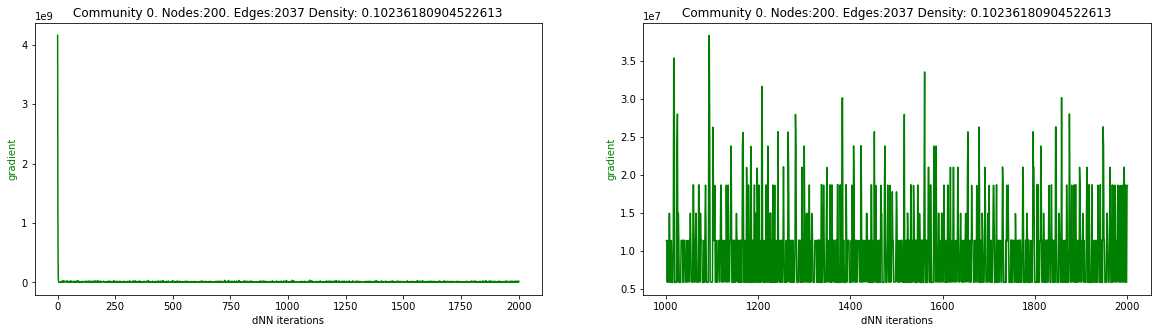

Graph with 200 nodes and 10024 edges


INFO:root:Epoch: 10. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 0
INFO:root:dNN solution is not correct. Epoch = 16


MIS length:9
Time used: 1.1830408573150635 seconds


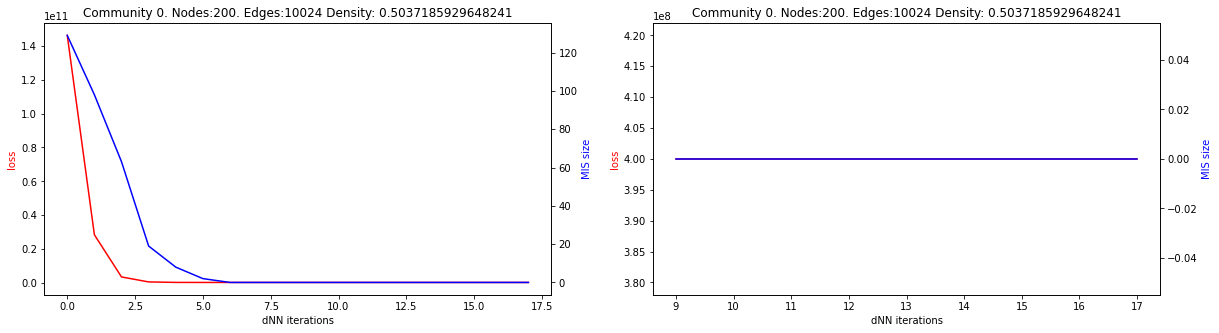

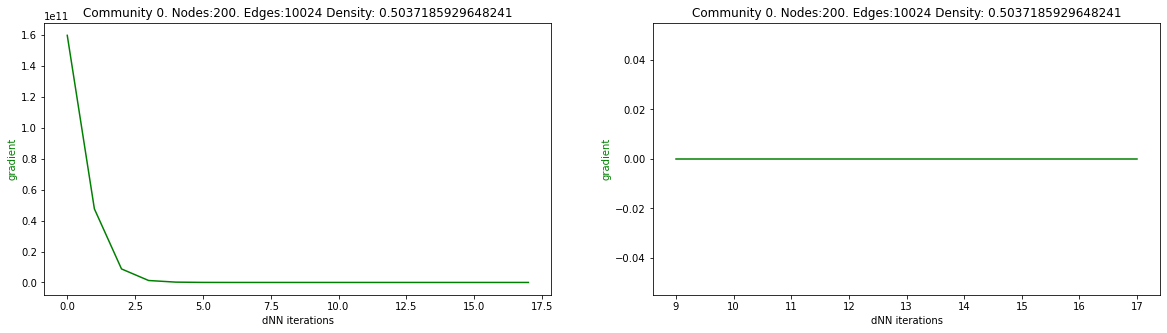

Graph with 171 nodes and 5100 edges


INFO:root:Epoch: 10. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 20. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 30. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 40. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 50. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 60. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 70. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 80. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 0
INFO:roo

MIS length:9
Time used: 1.9350345134735107 seconds


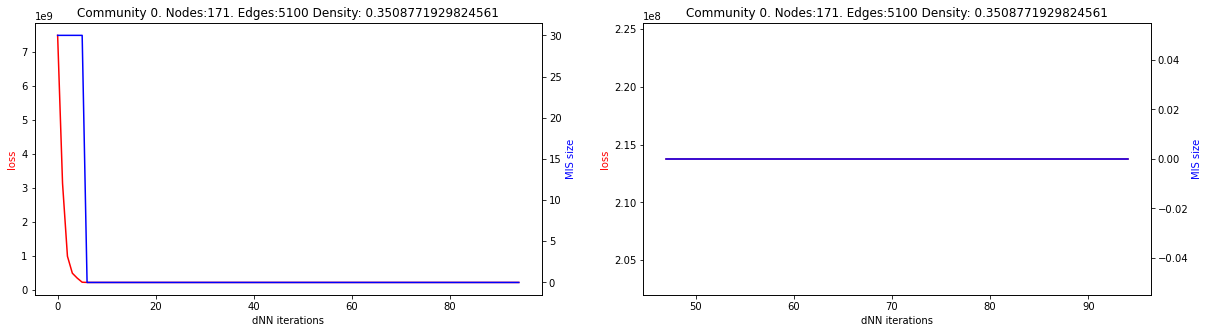

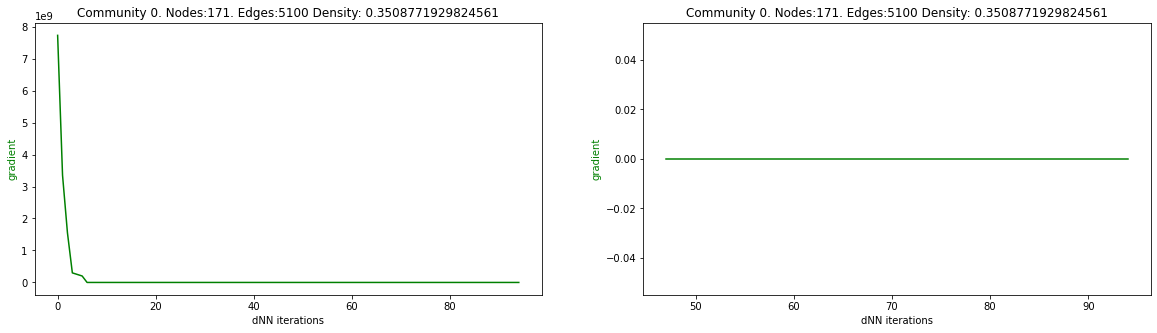

Graph with 300 nodes and 11460 edges


INFO:root:Epoch: 10. Loss: 2024610816.0. Gradient norm: 1370707.375. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 20. Loss: 2022444544.0. Gradient norm: 37460776.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 9
INFO:root:Epoch: 30. Loss: 2009538688.0. Gradient norm: 37110012.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 21
INFO:root:Epoch: 40. Loss: 2005089920.0. Gradient norm: 10766534.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 21
INFO:root:Epoch: 50. Loss: 2005298048.0. Gradient norm: 36657852.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 21
INFO:root:Epoch: 60. Loss: 2005257856.0. Gradient norm: 50803148.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 22
INFO:root:Epoch: 70. Loss: 2003695360.0. Gradient norm: 10336587.0. Clipnorm: 0.0010000000000000002. Learning rate:0.1. Mis size: 21
INFO:root:Epoch: 80. Loss: 2004008704.0. Gradient norm: 36646068.0. Cl

MIS length:31
Time used: 15.991241216659546 seconds


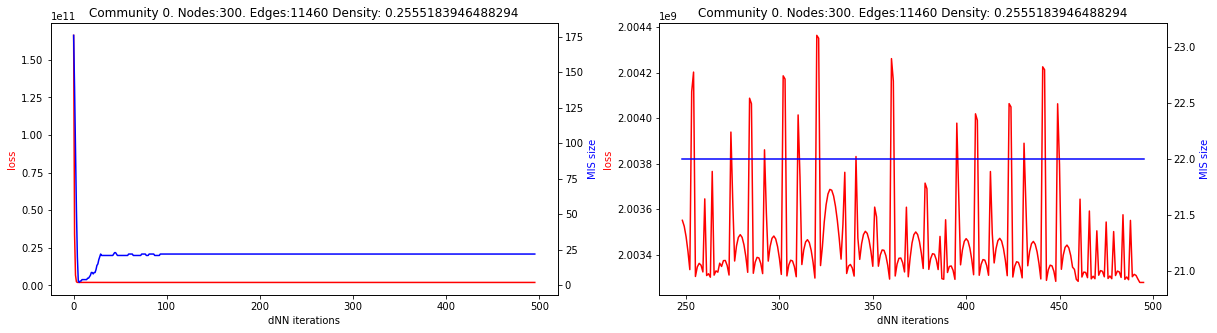

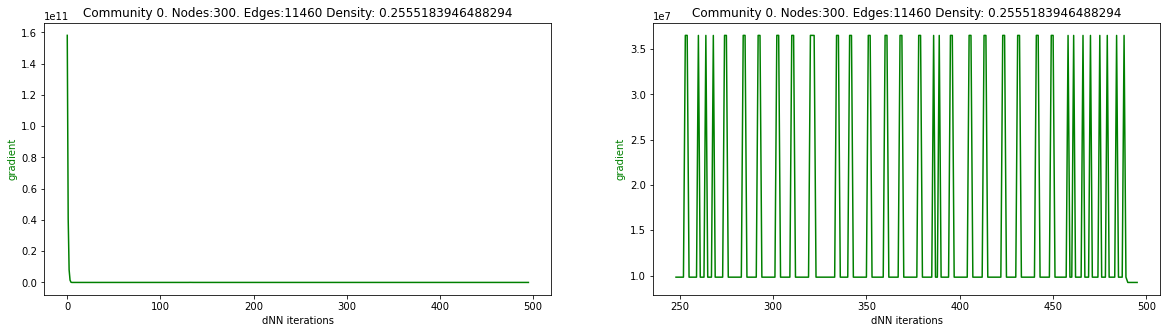

Graph with 200 nodes and 2037 edges


INFO:root:Epoch: 10. Loss: 399975392.0. Gradient norm: 113133.6015625. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 20. Loss: 398641376.0. Gradient norm: 12114612.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 6
INFO:root:Epoch: 30. Loss: 398992576.0. Gradient norm: 27335628.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 6
INFO:root:Epoch: 40. Loss: 400099680.0. Gradient norm: 38109808.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 9
INFO:root:Epoch: 50. Loss: 396498400.0. Gradient norm: 11309116.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 9
INFO:root:Epoch: 60. Loss: 395492544.0. Gradient norm: 35759712.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 20
INFO:root:Epoch: 70. Loss: 390376416.0. Gradient norm: 16636939.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 21
INFO:root:Epoch: 80. Loss: 388516832.0. Gradient norm: 9839634.0. Clip

MIS length:33
Time used: 9.679244041442871 seconds


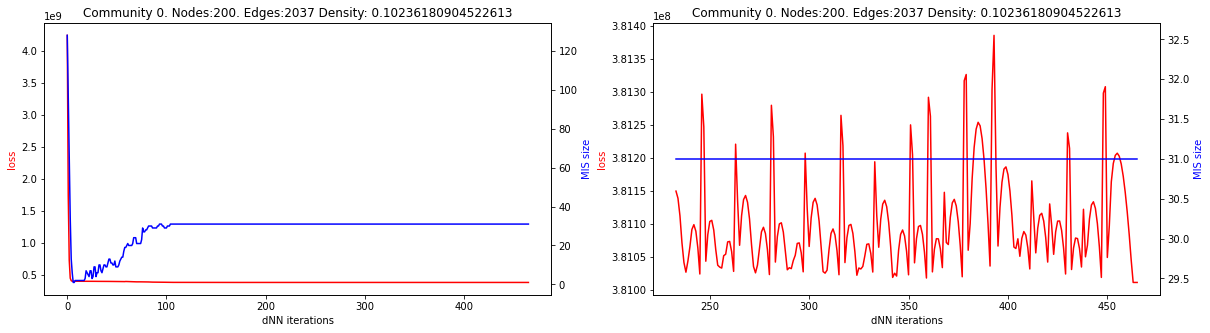

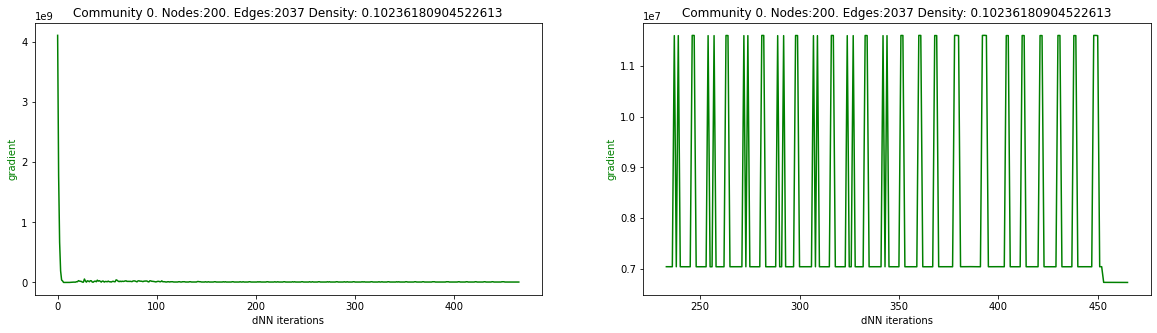

Graph with 200 nodes and 10024 edges


INFO:root:Epoch: 10. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 20. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 30. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 40. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 50. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 60. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 70. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 80. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 0


MIS length:9
Time used: 3.2340736389160156 seconds


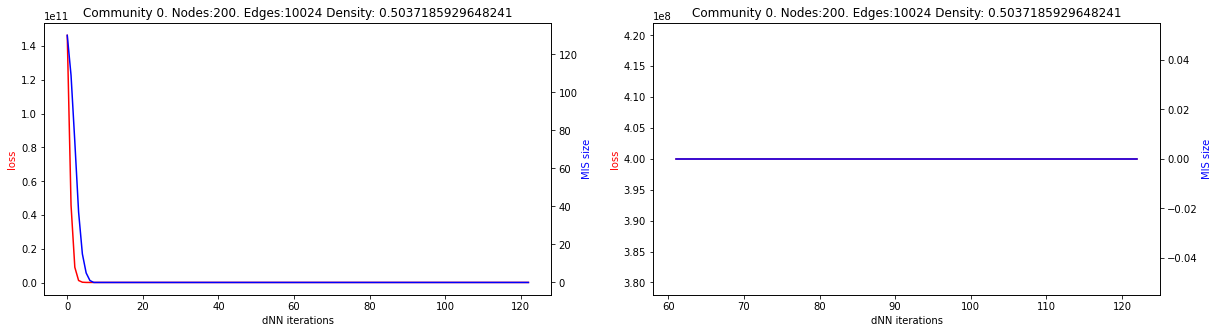

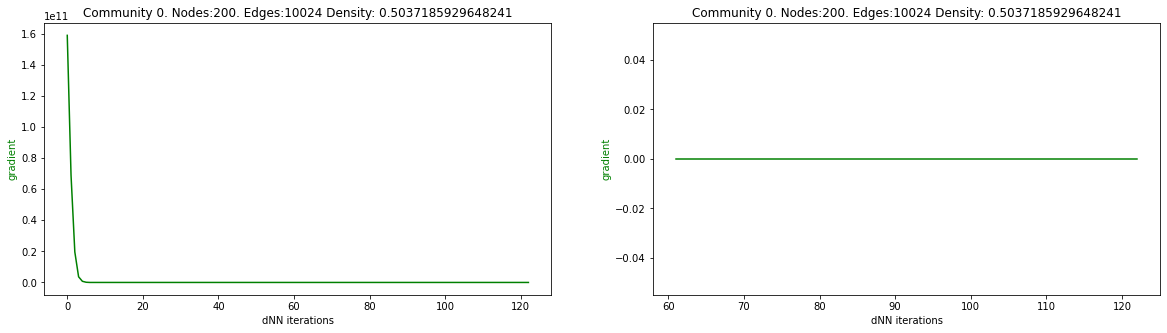

Graph with 171 nodes and 5100 edges


INFO:root:Epoch: 10. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 20. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 30. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 40. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 50. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 60. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 70. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 80. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 0


MIS length:10
Time used: 2.016556978225708 seconds


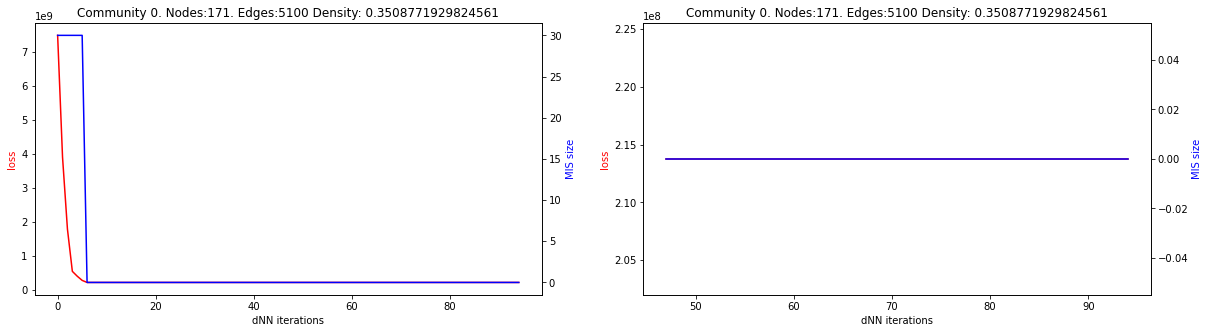

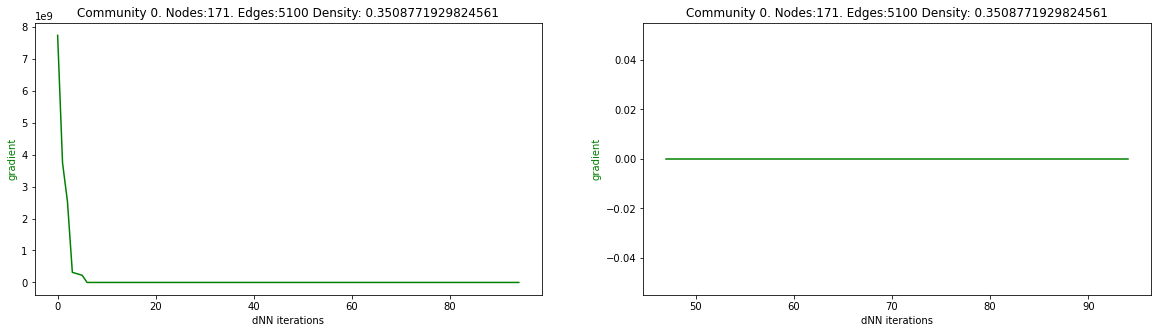

Graph with 300 nodes and 11460 edges


INFO:root:Epoch: 10. Loss: 2024837248.0. Gradient norm: 679457.8125. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 20. Loss: 2024858368.0. Gradient norm: 36988268.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 5
INFO:root:Epoch: 30. Loss: 2023714176.0. Gradient norm: 105186632.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 14
INFO:root:Epoch: 40. Loss: 2011040000.0. Gradient norm: 10567357.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 16
INFO:root:Epoch: 50. Loss: 2010320896.0. Gradient norm: 10493298.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 19
INFO:root:Epoch: 60. Loss: 2010443136.0. Gradient norm: 10175748.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 70. Loss: 2009622400.0. Gradient norm: 9628912.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 80. Loss: 2008951168.0. Gradient norm: 9328866

INFO:root:Epoch: 630. Loss: 2008204672.0. Gradient norm: 8477596.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 19
INFO:root:Epoch: 640. Loss: 2008324352.0. Gradient norm: 36599564.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 19
INFO:root:Epoch: 650. Loss: 2008738944.0. Gradient norm: 36541496.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 20
INFO:root:Epoch: 660. Loss: 2008173056.0. Gradient norm: 8477529.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 19
INFO:root:Epoch: 670. Loss: 2008140928.0. Gradient norm: 8459914.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 680. Loss: 2008120192.0. Gradient norm: 8459871.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 690. Loss: 2008134272.0. Gradient norm: 8459900.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 700. Loss: 2008041472.0. Gradient norm: 847

INFO:root:Epoch: 1240. Loss: 2008251136.0. Gradient norm: 8460145.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 1250. Loss: 2008166784.0. Gradient norm: 36598132.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 19
INFO:root:Epoch: 1260. Loss: 2008339712.0. Gradient norm: 8477881.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 19
INFO:root:Epoch: 1270. Loss: 2008536832.0. Gradient norm: 36601504.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 19
INFO:root:Epoch: 1280. Loss: 2008195456.0. Gradient norm: 8477577.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 19
INFO:root:Epoch: 1290. Loss: 2008157696.0. Gradient norm: 8459950.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 1300. Loss: 2008171648.0. Gradient norm: 8459979.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 1310. Loss: 2008340864.0. Gradient n

INFO:root:Epoch: 1850. Loss: 2008259968.0. Gradient norm: 36598976.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 19
INFO:root:Epoch: 1860. Loss: 2008169216.0. Gradient norm: 8459973.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 1870. Loss: 2008129024.0. Gradient norm: 8477435.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 19
INFO:root:Epoch: 1880. Loss: 2008097536.0. Gradient norm: 8459823.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 1890. Loss: 2008405248.0. Gradient norm: 36538464.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 20
INFO:root:Epoch: 1900. Loss: 2008081024.0. Gradient norm: 8477335.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 19
INFO:root:Epoch: 1910. Loss: 2008964736.0. Gradient norm: 90614080.0. Clipnorm: 0.00010000000000000003. Learning rate:0.1. Mis size: 20
INFO:root:Epoch: 1920. Loss: 2008184320.0. Gradient 

MIS length:28
Time used: 61.12915015220642 seconds


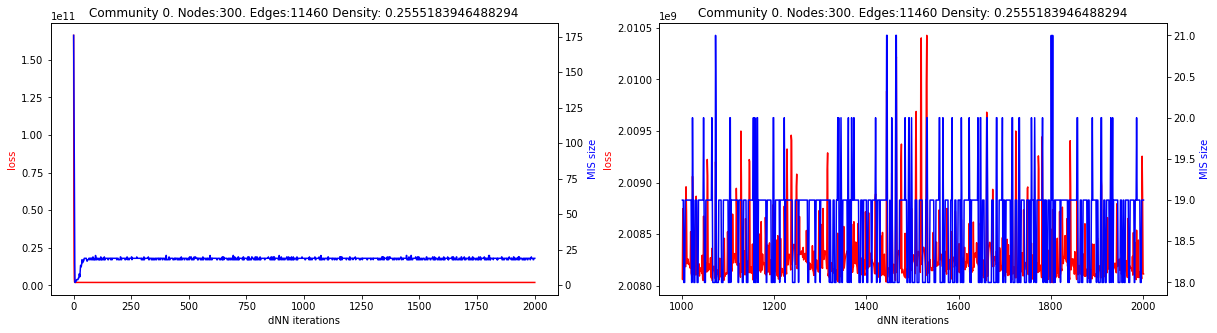

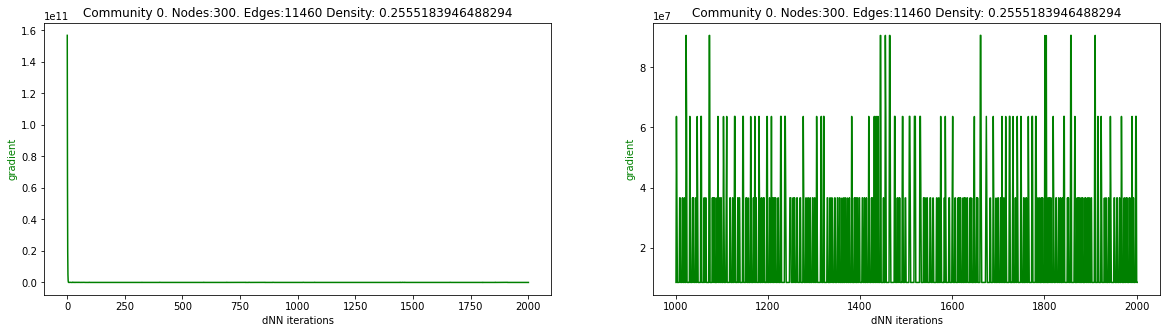

Graph with 200 nodes and 2037 edges


INFO:root:Epoch: 10. Loss: 400003584.0. Gradient norm: 10684916.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 6
INFO:root:Epoch: 20. Loss: 400863424.0. Gradient norm: 53351736.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 30. Loss: 398003200.0. Gradient norm: 9025081.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 40. Loss: 397226144.0. Gradient norm: 28480000.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 6
INFO:root:Epoch: 50. Loss: 396175744.0. Gradient norm: 14302826.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 5
INFO:root:Epoch: 60. Loss: 394905696.0. Gradient norm: 25458126.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 10
INFO:root:Epoch: 70. Loss: 392386880.0. Gradient norm: 19314134.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 9
INFO:root:Epoch: 80. Loss: 390972384.0. Gradient norm: 19197554.0. Clipnorm:

INFO:root:Epoch: 630. Loss: 380761984.0. Gradient norm: 24577714.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 13
INFO:root:Epoch: 640. Loss: 380064384.0. Gradient norm: 23141172.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 16
INFO:root:Epoch: 650. Loss: 380706944.0. Gradient norm: 30889600.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 660. Loss: 381495968.0. Gradient norm: 47141096.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 17
INFO:root:Epoch: 670. Loss: 380921888.0. Gradient norm: 29227288.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 20
INFO:root:Epoch: 680. Loss: 380151360.0. Gradient norm: 17688628.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 17
INFO:root:Epoch: 690. Loss: 381352704.0. Gradient norm: 53101468.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 19
INFO:root:Epoch: 700. Loss: 380775552.0. Gradient norm: 145948

INFO:root:Epoch: 1240. Loss: 380235680.0. Gradient norm: 38621204.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 24
INFO:root:Epoch: 1250. Loss: 380172096.0. Gradient norm: 44630448.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 22
INFO:root:Epoch: 1260. Loss: 379834208.0. Gradient norm: 28561208.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 19
INFO:root:Epoch: 1270. Loss: 380009248.0. Gradient norm: 24747428.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 1280. Loss: 379766752.0. Gradient norm: 26307180.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 19
INFO:root:Epoch: 1290. Loss: 380163936.0. Gradient norm: 19794092.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 16
INFO:root:Epoch: 1300. Loss: 379699104.0. Gradient norm: 19837348.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 20
INFO:root:Epoch: 1310. Loss: 379808096.0. Gradient norm

INFO:root:Epoch: 1850. Loss: 380249376.0. Gradient norm: 17571124.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 16
INFO:root:Epoch: 1860. Loss: 379742784.0. Gradient norm: 17621068.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 16
INFO:root:Epoch: 1870. Loss: 379294272.0. Gradient norm: 24240206.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 16
INFO:root:Epoch: 1880. Loss: 380611232.0. Gradient norm: 34270012.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 17
INFO:root:Epoch: 1890. Loss: 380292512.0. Gradient norm: 32196294.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 1900. Loss: 380149312.0. Gradient norm: 32795886.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 22
INFO:root:Epoch: 1910. Loss: 380880736.0. Gradient norm: 27831146.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 19
INFO:root:Epoch: 1920. Loss: 380453792.0. Gradient norm

MIS length:37
Time used: 40.590248346328735 seconds


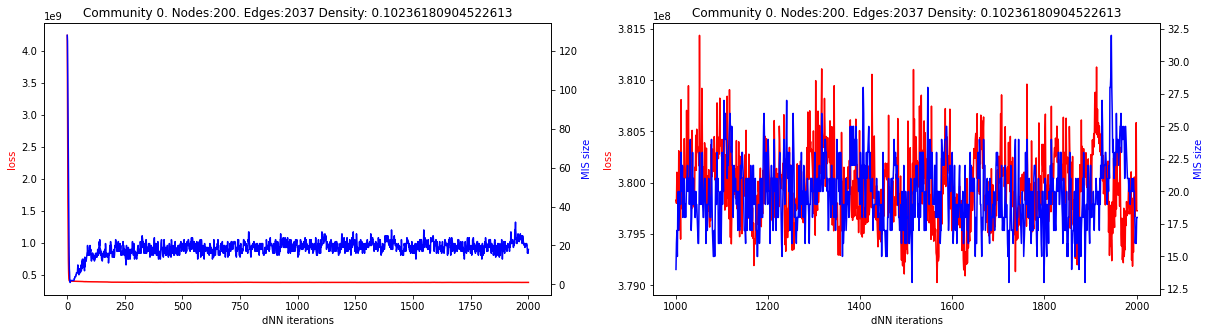

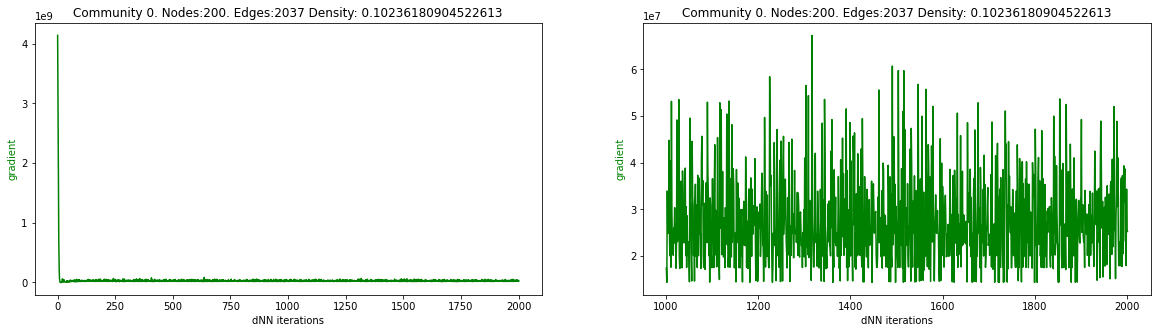

Graph with 200 nodes and 10024 edges


INFO:root:Epoch: 10. Loss: 402692160.0. Gradient norm: 47887348.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 5
INFO:root:Epoch: 20. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 30. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 40. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 50. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 60. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 70. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 80. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis s

MIS length:9
Time used: 3.8105857372283936 seconds


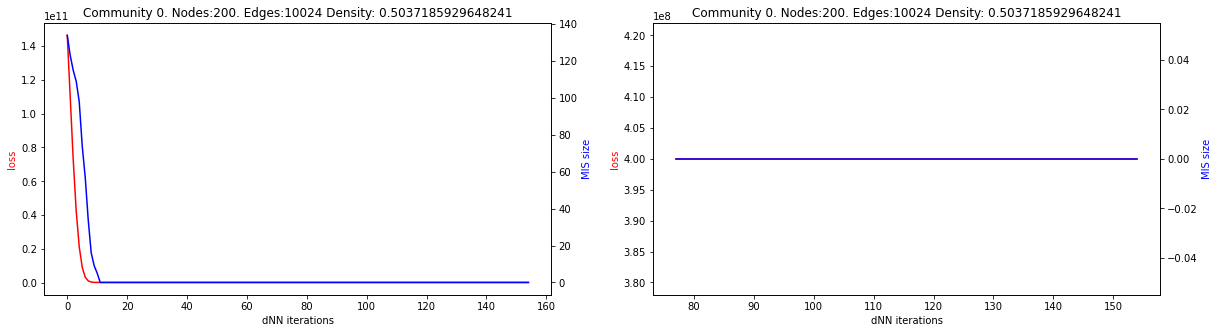

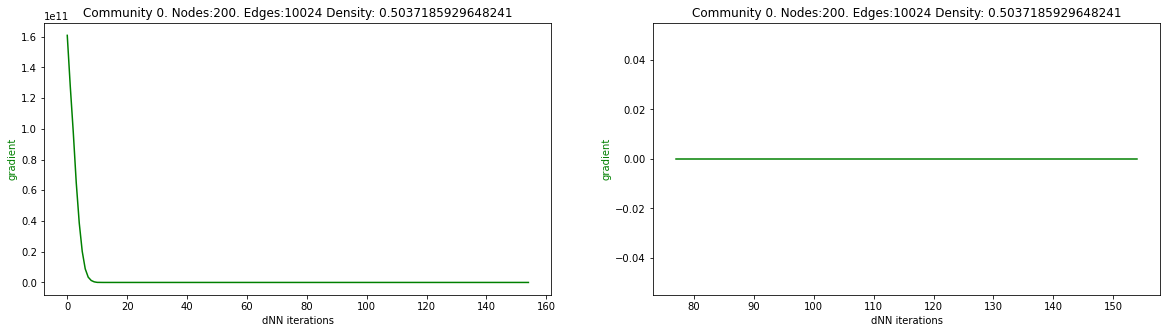

Graph with 171 nodes and 5100 edges


INFO:root:Epoch: 10. Loss: 213755712.0. Gradient norm: 429749.84375. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 6
INFO:root:Epoch: 20. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 30. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 40. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 50. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 60. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 70. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 80. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis

MIS length:9
Time used: 2.612034797668457 seconds


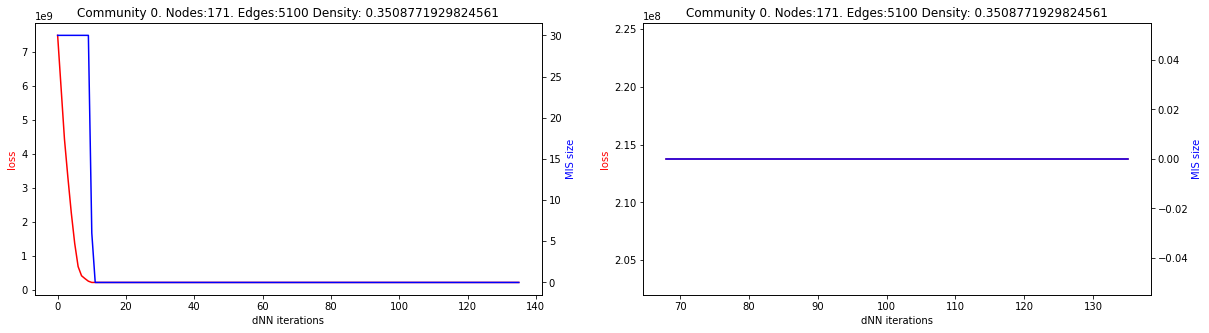

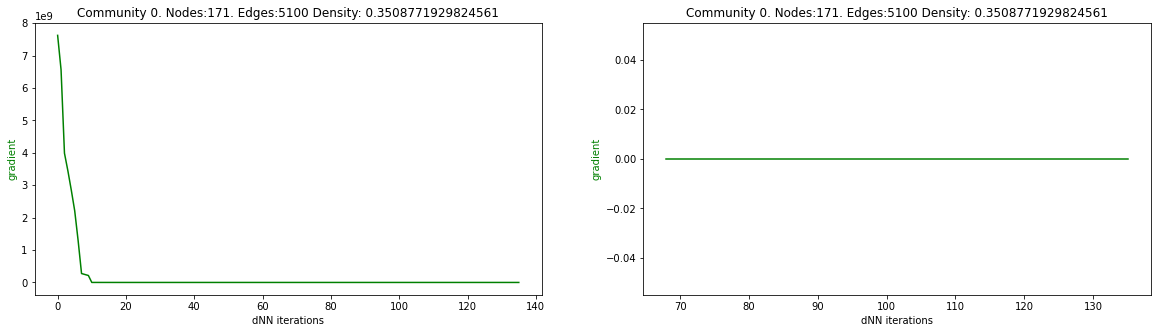

Graph with 300 nodes and 11460 edges


INFO:root:Epoch: 10. Loss: 2087174912.0. Gradient norm: 450072576.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 28
INFO:root:Epoch: 20. Loss: 2031275264.0. Gradient norm: 641737344.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 30. Loss: 2022934784.0. Gradient norm: 67267920.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 7
INFO:root:Epoch: 40. Loss: 2023385216.0. Gradient norm: 244874688.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 7
INFO:root:Epoch: 50. Loss: 2019227264.0. Gradient norm: 58954212.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 9
INFO:root:Epoch: 60. Loss: 2016797568.0. Gradient norm: 35220960.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 13
INFO:root:Epoch: 70. Loss: 2016061568.0. Gradient norm: 34244624.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 11
INFO:root:Epoch: 80. Loss: 2015981184.0. Gradient norm: 8794704

INFO:root:Epoch: 620. Loss: 1989909504.0. Gradient norm: 13884609.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 28
INFO:root:Epoch: 630. Loss: 1990257408.0. Gradient norm: 36920016.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 28
INFO:root:Epoch: 640. Loss: 1990647808.0. Gradient norm: 36923636.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 28
INFO:root:Epoch: 650. Loss: 1990015104.0. Gradient norm: 13218898.0. Clipnorm: 1.0000000000000004e-05. Learning rate:0.1. Mis size: 28
INFO:root:dNN solution is not correct. Epoch = 653


MIS length:29
Time used: 21.099385023117065 seconds


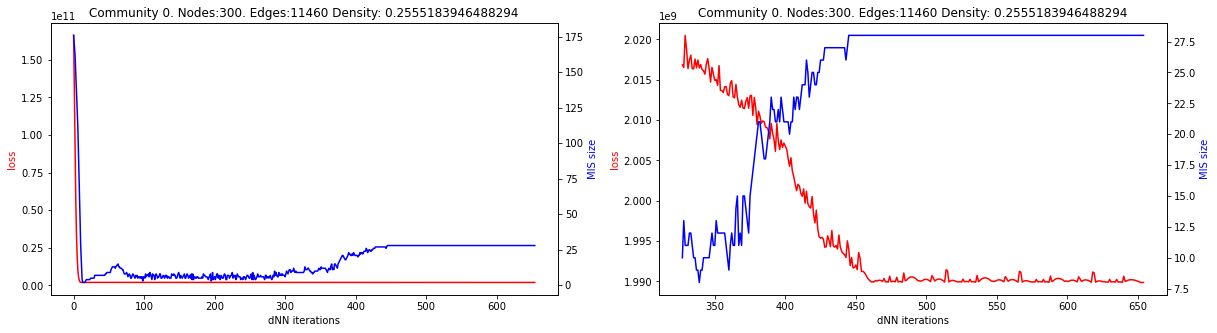

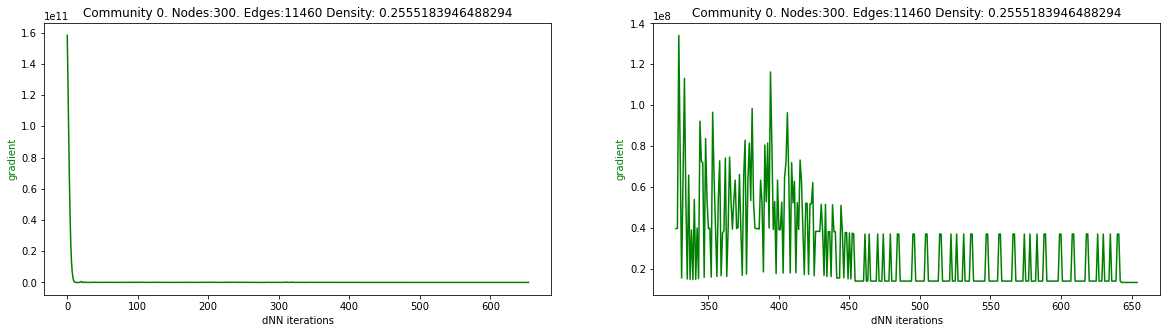

Graph with 200 nodes and 2037 edges


INFO:root:Epoch: 10. Loss: 2181016320.0. Gradient norm: 2332649728.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 110
INFO:root:Epoch: 20. Loss: 718166528.0. Gradient norm: 665529792.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 63
INFO:root:Epoch: 30. Loss: 405541088.0. Gradient norm: 47850688.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 14
INFO:root:Epoch: 40. Loss: 399779168.0. Gradient norm: 15746510.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 6
INFO:root:Epoch: 50. Loss: 399062432.0. Gradient norm: 20018020.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 7
INFO:root:Epoch: 60. Loss: 397324096.0. Gradient norm: 41217392.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 8
INFO:root:Epoch: 70. Loss: 395316224.0. Gradient norm: 21299746.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 11
INFO:root:Epoch: 80. Loss: 392586016.0. Gradient norm: 19722470.0. 

MIS length:38
Time used: 4.956584453582764 seconds


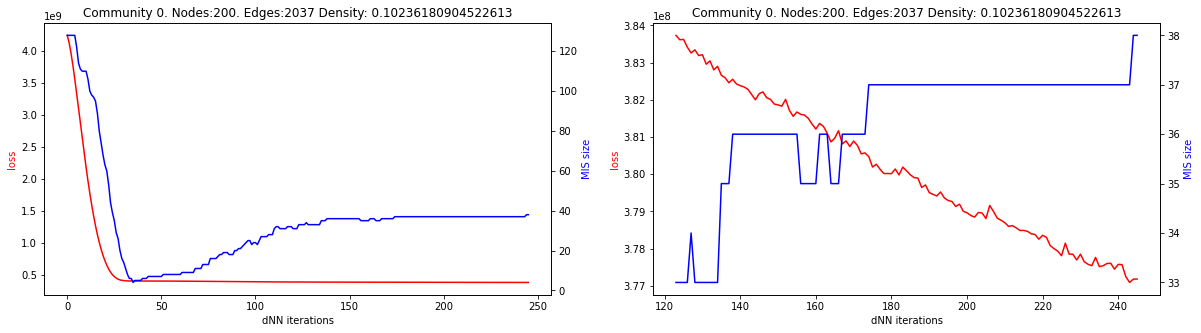

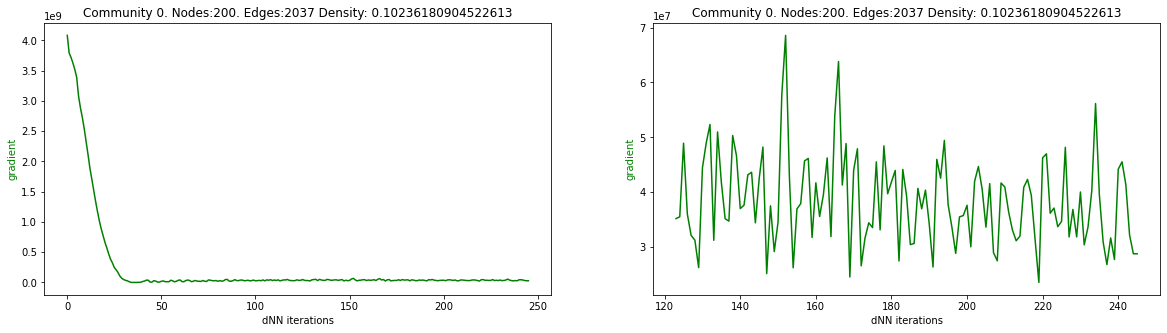

Graph with 200 nodes and 10024 edges


INFO:root:Epoch: 10. Loss: 64563363840.0. Gradient norm: 88532508672.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 115
INFO:root:Epoch: 20. Loss: 9305819136.0. Gradient norm: 20780496896.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 76
INFO:root:Epoch: 30. Loss: 501946208.0. Gradient norm: 857859392.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 12
INFO:root:Epoch: 40. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 50. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 60. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 70. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 80. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 1.0000000000000004e-

MIS length:8
Time used: 3.9620659351348877 seconds


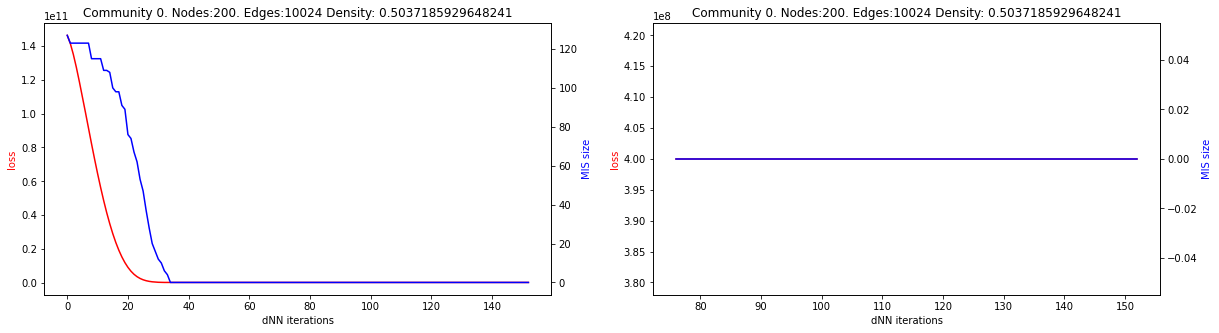

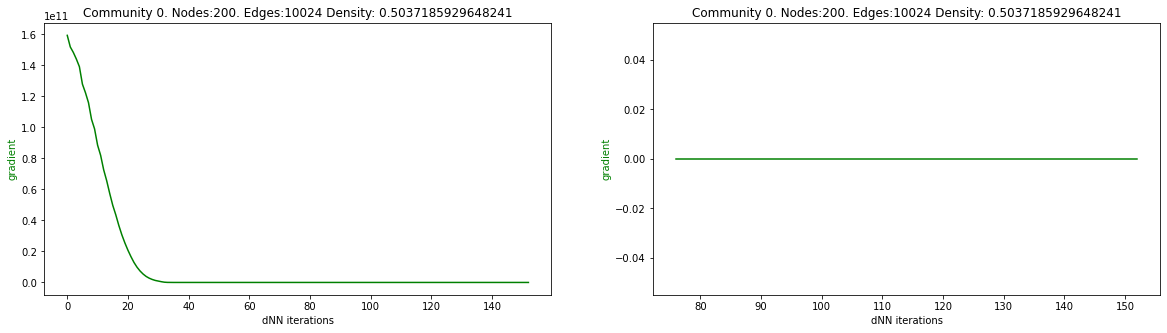

Graph with 171 nodes and 5100 edges


INFO:root:Epoch: 10. Loss: 3879918592.0. Gradient norm: 3734261760.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 30
INFO:root:Epoch: 20. Loss: 981955200.0. Gradient norm: 1878620544.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 30
INFO:root:Epoch: 30. Loss: 230084288.0. Gradient norm: 205932448.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 30
INFO:root:Epoch: 40. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 50. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 60. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 70. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 80. Loss: 213759024.0. Gradient norm: 0.0. Clipnorm: 1.0000000000000004e-06. L

MIS length:9
Time used: 2.591073513031006 seconds


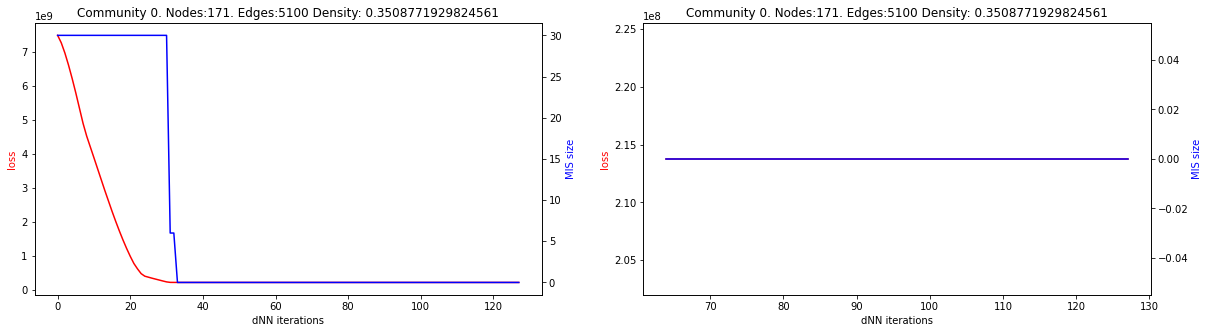

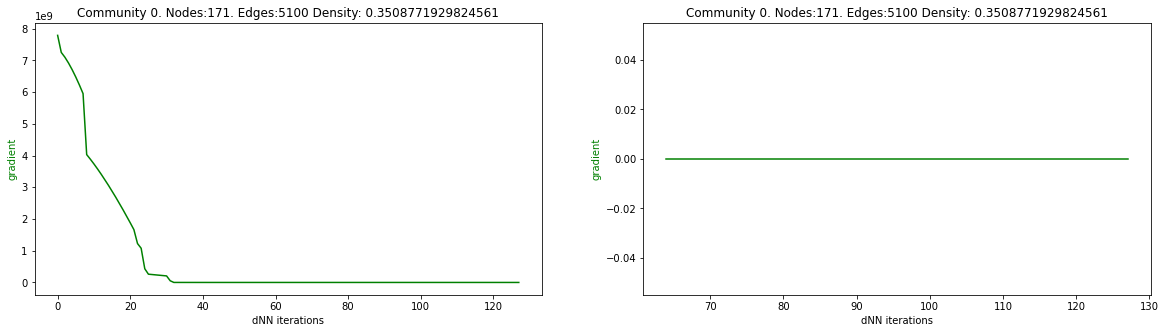

Graph with 300 nodes and 11460 edges


INFO:root:Epoch: 10. Loss: 84336730112.0. Gradient norm: 90767687680.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 159
INFO:root:Epoch: 20. Loss: 21926352896.0. Gradient norm: 28678215680.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 130
INFO:root:Epoch: 30. Loss: 3770815232.0. Gradient norm: 4319777280.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 81
INFO:root:Epoch: 40. Loss: 2024817152.0. Gradient norm: 4135898.25. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 8
INFO:root:Epoch: 50. Loss: 2024289536.0. Gradient norm: 46574896.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 7
INFO:root:Epoch: 60. Loss: 2022753024.0. Gradient norm: 45391372.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 8
INFO:root:Epoch: 70. Loss: 2021018368.0. Gradient norm: 35978412.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 9
INFO:root:Epoch: 80. Loss: 2018743808.0. Gradient norm

INFO:root:Epoch: 620. Loss: 1981530240.0. Gradient norm: 85045128.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 17
INFO:root:Epoch: 630. Loss: 1981192960.0. Gradient norm: 69263688.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 19
INFO:root:Epoch: 640. Loss: 1981069184.0. Gradient norm: 45927632.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 16
INFO:root:Epoch: 650. Loss: 1981012480.0. Gradient norm: 29609674.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 16
INFO:root:Epoch: 660. Loss: 1980726272.0. Gradient norm: 45819852.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 20
INFO:root:Epoch: 670. Loss: 1981240192.0. Gradient norm: 45995904.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 17
INFO:root:Epoch: 680. Loss: 1981582464.0. Gradient norm: 46099724.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 15
INFO:root:Epoch: 690. Loss: 1982967168.0. Gradient norm

INFO:root:Epoch: 1230. Loss: 1982793984.0. Gradient norm: 149714944.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 18
INFO:root:Epoch: 1240. Loss: 1983056896.0. Gradient norm: 150217232.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 16
INFO:root:Epoch: 1250. Loss: 1982194944.0. Gradient norm: 57579400.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 16
INFO:root:Epoch: 1260. Loss: 1981964288.0. Gradient norm: 57855852.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 16
INFO:root:Epoch: 1270. Loss: 1981633920.0. Gradient norm: 99396216.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 21
INFO:root:Epoch: 1280. Loss: 1982545152.0. Gradient norm: 84678712.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 20
INFO:root:Epoch: 1290. Loss: 1981500032.0. Gradient norm: 69570080.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 16
INFO:root:Epoch: 1300. Loss: 1981156096.0. Gra

INFO:root:Epoch: 1840. Loss: 1980043520.0. Gradient norm: 29458136.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 16
INFO:root:Epoch: 1850. Loss: 1980150912.0. Gradient norm: 46106352.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 16
INFO:root:Epoch: 1860. Loss: 1979872128.0. Gradient norm: 77885368.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 19
INFO:root:Epoch: 1870. Loss: 1980647680.0. Gradient norm: 45793100.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 15
INFO:root:Epoch: 1880. Loss: 1980451584.0. Gradient norm: 91261072.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 23
INFO:root:Epoch: 1890. Loss: 1980494080.0. Gradient norm: 29254118.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 17
INFO:root:Epoch: 1900. Loss: 1979583232.0. Gradient norm: 58086016.0. Clipnorm: 1.0000000000000004e-06. Learning rate:0.1. Mis size: 16
INFO:root:Epoch: 1910. Loss: 1980160256.0. Gradi

MIS length:26
Time used: 62.176618814468384 seconds


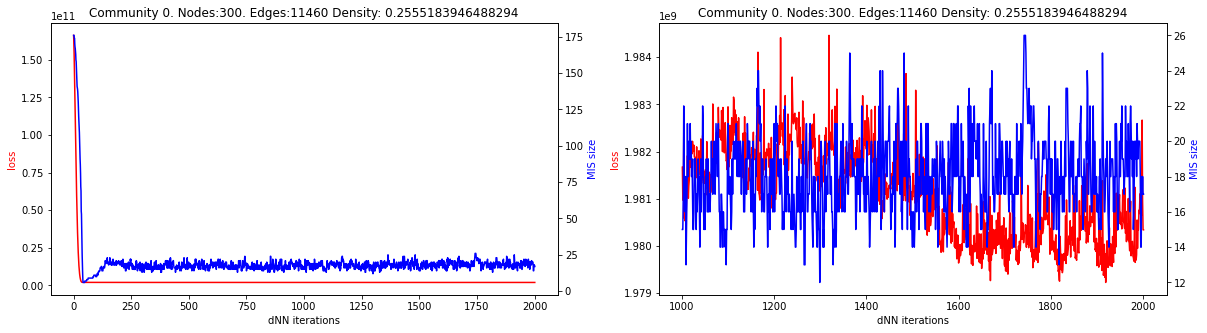

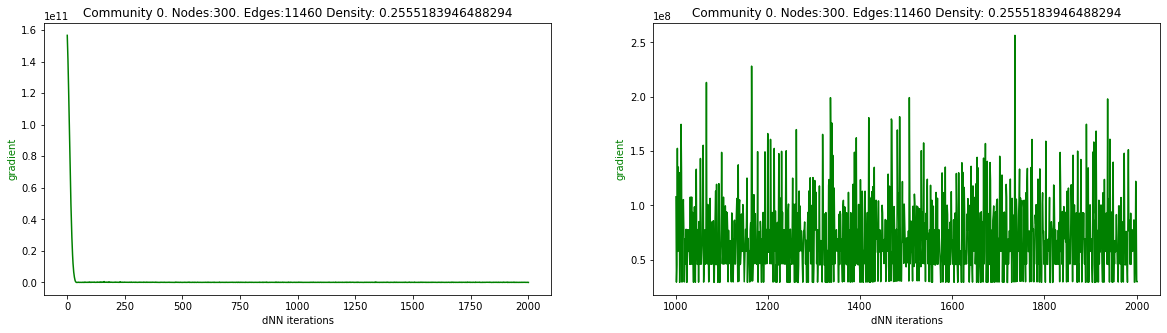

Graph with 200 nodes and 2037 edges


INFO:root:Epoch: 10. Loss: 3981125888.0. Gradient norm: 3722243840.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 128
INFO:root:Epoch: 20. Loss: 3539159552.0. Gradient norm: 3509558528.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 128
INFO:root:Epoch: 30. Loss: 3024831488.0. Gradient norm: 3031329280.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 113
INFO:root:Epoch: 40. Loss: 2508063488.0. Gradient norm: 2640860160.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 110
INFO:root:Epoch: 50. Loss: 2012089856.0. Gradient norm: 2171924224.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 108
INFO:root:Epoch: 60. Loss: 1577061504.0. Gradient norm: 1703617280.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 99
INFO:root:Epoch: 70. Loss: 1211438080.0. Gradient norm: 1302948480.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 93
INFO:root:Epoch: 80. Loss: 922201664.0. Gra

MIS length:40
Time used: 6.5401225090026855 seconds


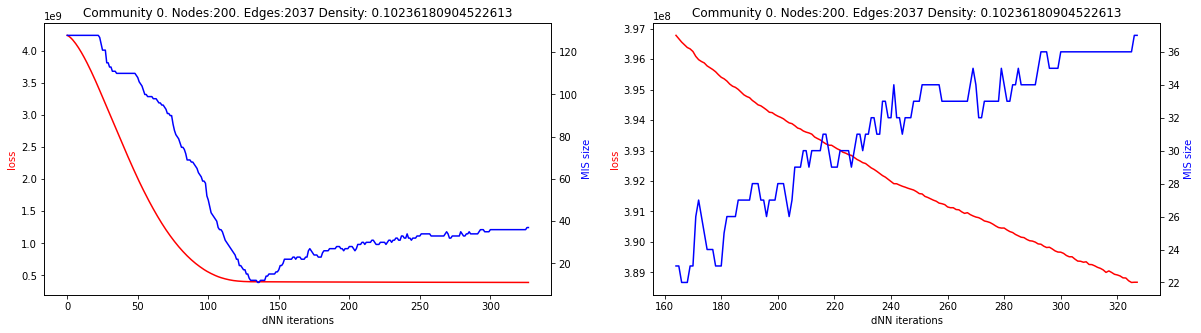

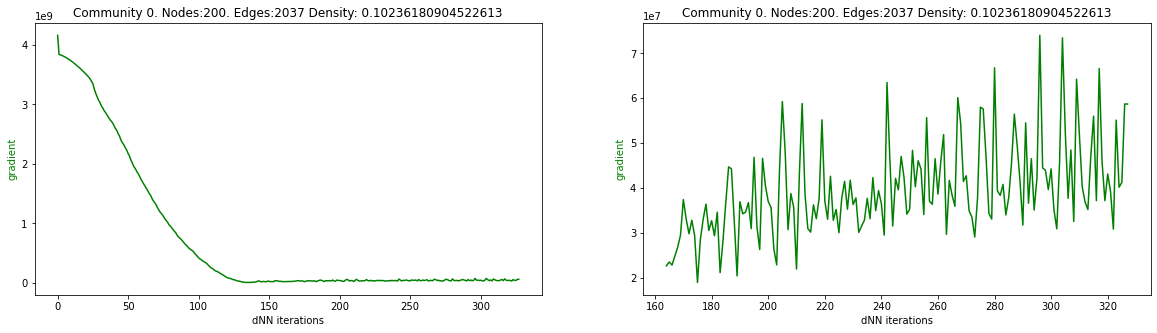

Graph with 200 nodes and 10024 edges


INFO:root:Epoch: 10. Loss: 135409442816.0. Gradient norm: 148657373184.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 123
INFO:root:Epoch: 20. Loss: 117838217216.0. Gradient norm: 138677125120.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 123
INFO:root:Epoch: 30. Loss: 97850646528.0. Gradient norm: 120686583808.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 123
INFO:root:Epoch: 40. Loss: 77456818176.0. Gradient norm: 101947965440.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 115
INFO:root:Epoch: 50. Loss: 58287644672.0. Gradient norm: 83572457472.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 115
INFO:root:Epoch: 60. Loss: 41373777920.0. Gradient norm: 65966915584.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 109
INFO:root:Epoch: 70. Loss: 27465977856.0. Gradient norm: 48118067200.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 101
INFO:root:Epoch: 80. 

MIS length:8
Time used: 5.557103157043457 seconds


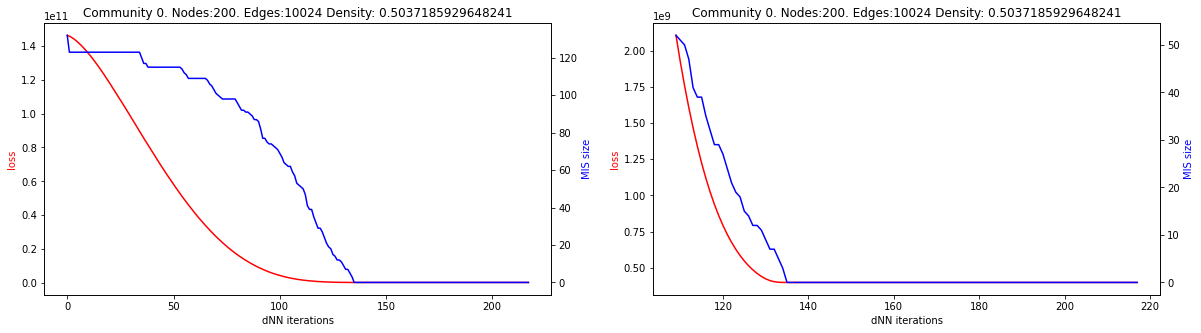

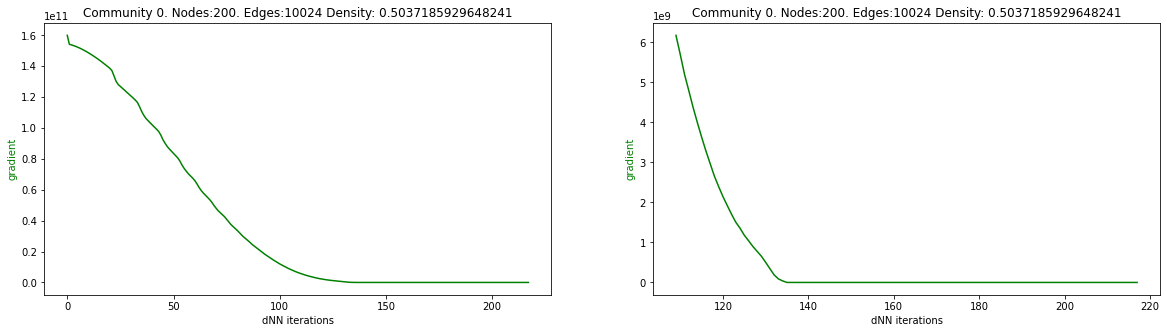

Graph with 171 nodes and 5100 edges


INFO:root:Epoch: 10. Loss: 6972791296.0. Gradient norm: 7104837120.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 30
INFO:root:Epoch: 20. Loss: 6137496064.0. Gradient norm: 6665711616.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 30
INFO:root:Epoch: 30. Loss: 5148732928.0. Gradient norm: 6105217024.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 30
INFO:root:Epoch: 40. Loss: 4283021312.0. Gradient norm: 3923453440.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 30
INFO:root:Epoch: 50. Loss: 3529032448.0. Gradient norm: 3561403392.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 30
INFO:root:Epoch: 60. Loss: 2777671168.0. Gradient norm: 3159612416.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 30
INFO:root:Epoch: 70. Loss: 2063903360.0. Gradient norm: 2723566592.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 30
INFO:root:Epoch: 80. Loss: 1417656064.0. Gradien

INFO:root:Epoch: 630. Loss: 212857840.0. Gradient norm: 124974832.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 5
INFO:root:Epoch: 640. Loss: 212441216.0. Gradient norm: 2923223.25. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 650. Loss: 212657248.0. Gradient norm: 119573144.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 660. Loss: 212513536.0. Gradient norm: 60414508.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 5
INFO:root:Epoch: 670. Loss: 212382128.0. Gradient norm: 7457733.5. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 5
INFO:root:Epoch: 680. Loss: 212345520.0. Gradient norm: 41136528.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 690. Loss: 212319728.0. Gradient norm: 26191462.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 5
INFO:root:Epoch: 700. Loss: 212437024.0. Gradient norm: 70109384.0. 

INFO:root:Epoch: 1250. Loss: 211643904.0. Gradient norm: 3688539.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 1260. Loss: 211943584.0. Gradient norm: 95497344.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 1270. Loss: 211614192.0. Gradient norm: 17426656.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 6
INFO:root:Epoch: 1280. Loss: 211646288.0. Gradient norm: 39669216.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 5
INFO:root:Epoch: 1290. Loss: 211605952.0. Gradient norm: 17442750.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 5
INFO:root:Epoch: 1300. Loss: 211593136.0. Gradient norm: 7762406.5. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 6
INFO:root:Epoch: 1310. Loss: 212091376.0. Gradient norm: 85577144.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 1320. Loss: 211568896.0. Gradient norm: 3687884

INFO:root:Epoch: 1870. Loss: 211467632.0. Gradient norm: 25382674.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 5
INFO:root:Epoch: 1880. Loss: 211467888.0. Gradient norm: 17553026.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 1890. Loss: 211458000.0. Gradient norm: 3686918.25. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 1900. Loss: 211473312.0. Gradient norm: 17372278.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 6
INFO:root:Epoch: 1910. Loss: 211474656.0. Gradient norm: 18126612.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 6
INFO:root:Epoch: 1920. Loss: 211481856.0. Gradient norm: 35825652.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 5
INFO:root:Epoch: 1930. Loss: 211458976.0. Gradient norm: 3686926.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 1940. Loss: 211447840.0. Gradient norm: 370308

MIS length:9
Time used: 36.23360252380371 seconds


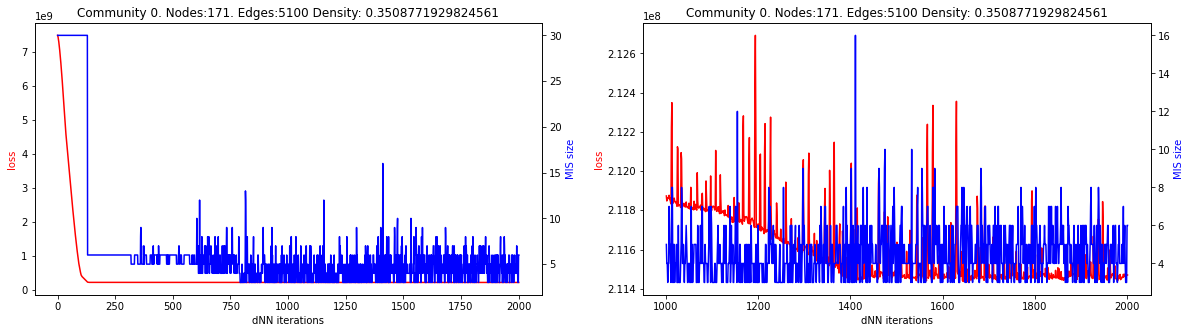

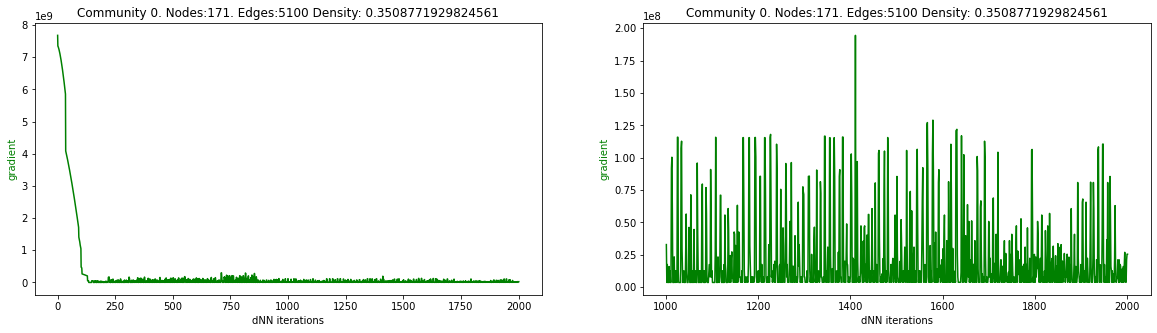

Graph with 300 nodes and 11460 edges


INFO:root:Epoch: 10. Loss: 155554545664.0. Gradient norm: 149292597248.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 176
INFO:root:Epoch: 20. Loss: 138233757696.0. Gradient norm: 134992199680.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 174
INFO:root:Epoch: 30. Loss: 118280642560.0. Gradient norm: 119156678656.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 168
INFO:root:Epoch: 40. Loss: 97892040704.0. Gradient norm: 102508290048.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 163
INFO:root:Epoch: 50. Loss: 78400733184.0. Gradient norm: 85767061504.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 158
INFO:root:Epoch: 60. Loss: 60682555392.0. Gradient norm: 69374443520.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 151
INFO:root:Epoch: 70. Loss: 45450153984.0. Gradient norm: 54563237888.0. Clipnorm: 1.0000000000000005e-07. Learning rate:0.1. Mis size: 142
INFO:root:Epoch: 80.

MIS length:33
Time used: 12.57075309753418 seconds


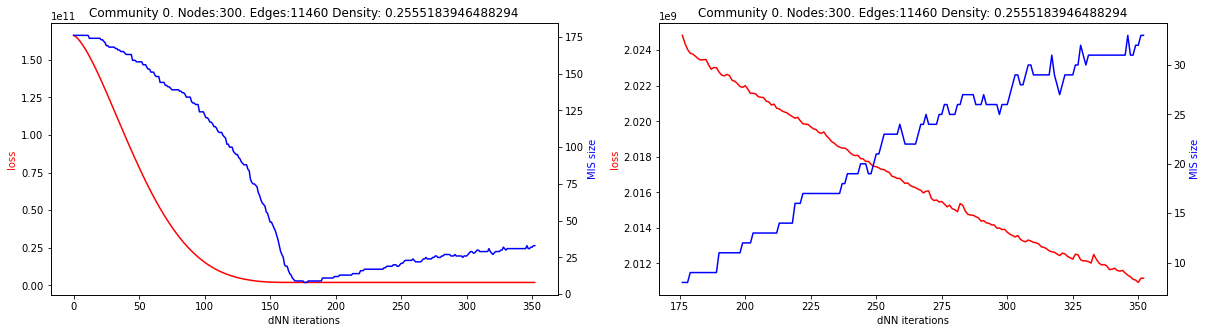

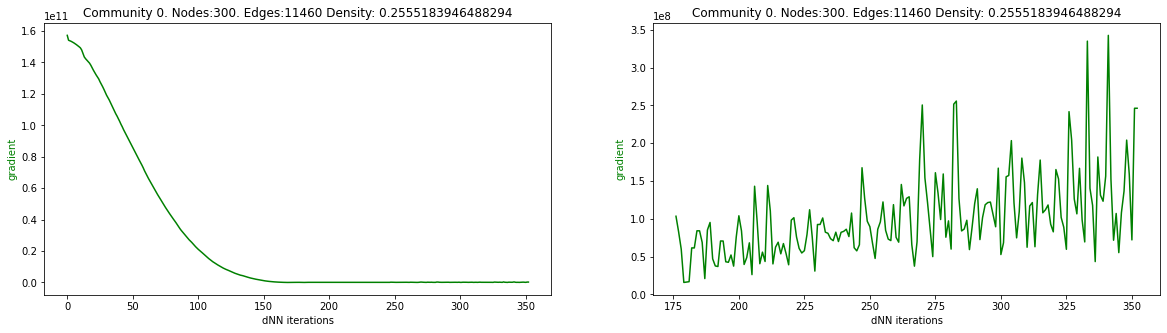

Graph with 200 nodes and 2037 edges


INFO:root:Epoch: 10. Loss: 4220380672.0. Gradient norm: 3832465920.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 128
INFO:root:Epoch: 20. Loss: 4173195776.0. Gradient norm: 3810975744.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 128
INFO:root:Epoch: 30. Loss: 4113179392.0. Gradient norm: 3783480064.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 128
INFO:root:Epoch: 40. Loss: 4042944512.0. Gradient norm: 3751035904.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 128
INFO:root:Epoch: 50. Loss: 3964368384.0. Gradient norm: 3714407168.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 128
INFO:root:Epoch: 60. Loss: 3878704128.0. Gradient norm: 3674057984.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 128
INFO:root:Epoch: 70. Loss: 3786933248.0. Gradient norm: 3630331648.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 128
INFO:root:Epoch: 80. Loss: 3689885696.0. 

INFO:root:Epoch: 620. Loss: 398471456.0. Gradient norm: 18145526.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 25
INFO:root:Epoch: 630. Loss: 398216352.0. Gradient norm: 25423130.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 25
INFO:root:Epoch: 640. Loss: 397919104.0. Gradient norm: 17931650.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 26
INFO:root:Epoch: 650. Loss: 397692960.0. Gradient norm: 20068436.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 26
INFO:root:Epoch: 660. Loss: 397477184.0. Gradient norm: 27926140.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 28
INFO:root:Epoch: 670. Loss: 397283616.0. Gradient norm: 35382528.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 28
INFO:root:Epoch: 680. Loss: 397111168.0. Gradient norm: 33257634.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 29
INFO:root:Epoch: 690. Loss: 396948256.0. Gradient norm: 348250

MIS length:41
Time used: 25.91296672821045 seconds


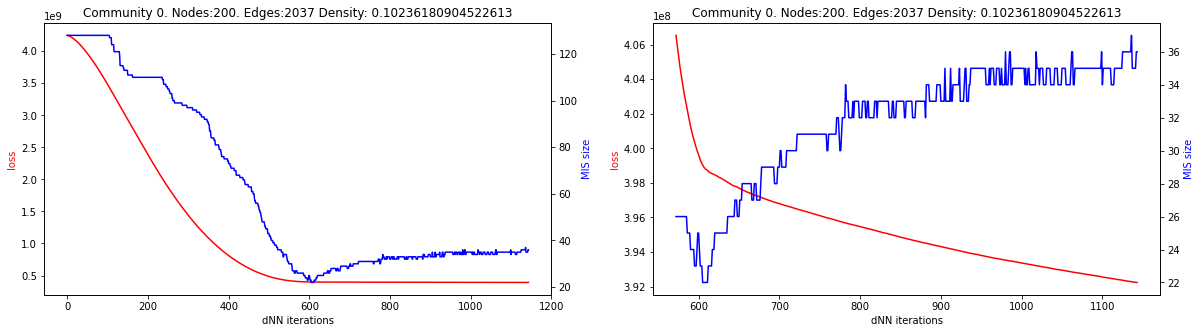

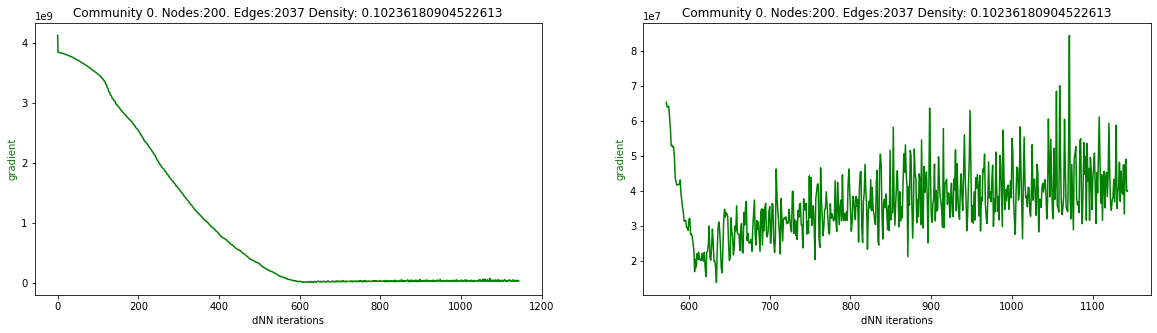

Graph with 200 nodes and 10024 edges


INFO:root:Epoch: 10. Loss: 144984342528.0. Gradient norm: 153823428608.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 123
INFO:root:Epoch: 20. Loss: 143092973568.0. Gradient norm: 152816713728.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 123
INFO:root:Epoch: 30. Loss: 140684623872.0. Gradient norm: 151525326848.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 123
INFO:root:Epoch: 40. Loss: 137874849792.0. Gradient norm: 150004596736.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 123
INFO:root:Epoch: 50. Loss: 134735314944.0. Gradient norm: 148286832640.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 123
INFO:root:Epoch: 60. Loss: 131318587392.0. Gradient norm: 146394578944.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 123
INFO:root:Epoch: 70. Loss: 127665389568.0. Gradient norm: 144343891968.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 123
INFO:root:Epo

INFO:root:Epoch: 600. Loss: 465581600.0. Gradient norm: 856750016.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 13
INFO:root:Epoch: 610. Loss: 421051072.0. Gradient norm: 519457280.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 10
INFO:root:Epoch: 620. Loss: 401360832.0. Gradient norm: 127610920.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 7
INFO:root:Epoch: 630. Loss: 400000000.0. Gradient norm: 0.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 640. Loss: 399999936.0. Gradient norm: 89442.7109375. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 1
INFO:root:Epoch: 650. Loss: 399998752.0. Gradient norm: 187616.328125. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 660. Loss: 400009440.0. Gradient norm: 27406482.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 670. Loss: 400003584.0. Gradient norm: 27237274.

INFO:root:Epoch: 1220. Loss: 399783456.0. Gradient norm: 40621736.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 5
INFO:root:Epoch: 1230. Loss: 399772704.0. Gradient norm: 11556023.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 5
INFO:root:Epoch: 1240. Loss: 399767392.0. Gradient norm: 3313729.75. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 1250. Loss: 399767232.0. Gradient norm: 3312523.25. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 1260. Loss: 399758400.0. Gradient norm: 3377026.5. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 1270. Loss: 399995616.0. Gradient norm: 337292608.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 1280. Loss: 399828544.0. Gradient norm: 289411072.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 1290. Loss: 399750912.0. Gradient norm: 3376

INFO:root:Epoch: 1840. Loss: 399581344.0. Gradient norm: 4073939.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 1850. Loss: 399578848.0. Gradient norm: 4106757.5. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 1860. Loss: 399808384.0. Gradient norm: 186999952.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 5
INFO:root:Epoch: 1870. Loss: 399566592.0. Gradient norm: 4106690.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 1880. Loss: 399853152.0. Gradient norm: 384708608.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 1890. Loss: 399560032.0. Gradient norm: 27726578.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 1900. Loss: 399562624.0. Gradient norm: 296466240.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 1910. Loss: 399550112.0. Gradient norm: 41395

MIS length:9
Time used: 41.855828285217285 seconds


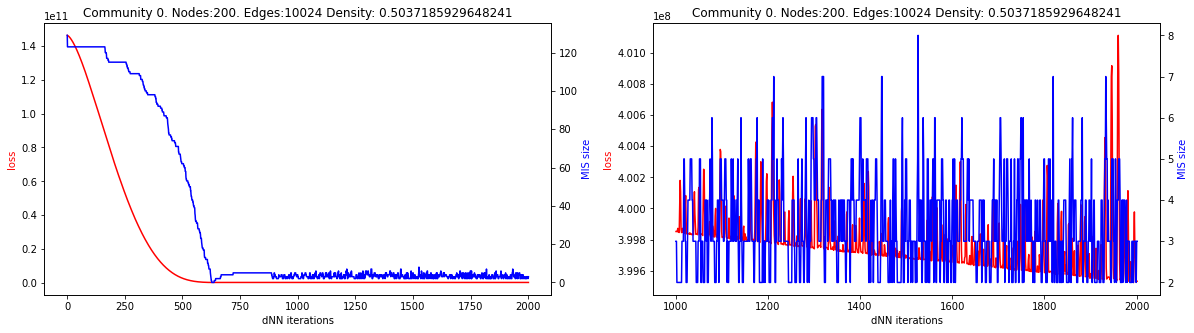

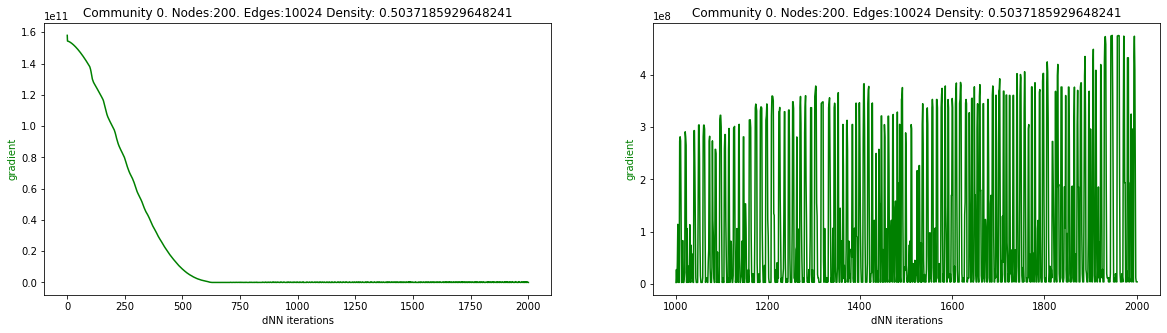

Graph with 171 nodes and 5100 edges


INFO:root:Epoch: 10. Loss: 7428596224.0. Gradient norm: 7333381632.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 30
INFO:root:Epoch: 20. Loss: 7337719808.0. Gradient norm: 7288386048.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 30
INFO:root:Epoch: 30. Loss: 7223175168.0. Gradient norm: 7231276544.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 30
INFO:root:Epoch: 40. Loss: 7089084928.0. Gradient norm: 7163841024.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 30
INFO:root:Epoch: 50. Loss: 6939026432.0. Gradient norm: 7087618048.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 30
INFO:root:Epoch: 60. Loss: 6775783424.0. Gradient norm: 7003753472.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 30
INFO:root:Epoch: 70. Loss: 6602010624.0. Gradient norm: 6913355776.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 30
INFO:root:Epoch: 80. Loss: 6417001472.0. Gradien

INFO:root:Epoch: 620. Loss: 220367072.0. Gradient norm: 53598676.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 6
INFO:root:Epoch: 630. Loss: 217052256.0. Gradient norm: 53194024.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 6
INFO:root:Epoch: 640. Loss: 213735200.0. Gradient norm: 429729.21875. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 6
INFO:root:Epoch: 650. Loss: 213737888.0. Gradient norm: 429731.9375. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 6
INFO:root:Epoch: 660. Loss: 214037408.0. Gradient norm: 52823300.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 6
INFO:root:Epoch: 670. Loss: 213789920.0. Gradient norm: 52792756.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 6
INFO:root:Epoch: 680. Loss: 213767008.0. Gradient norm: 48483120.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 6
INFO:root:Epoch: 690. Loss: 213718480.0. Gradient norm: 511460.062

INFO:root:Epoch: 1240. Loss: 213651552.0. Gradient norm: 114152056.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 7
INFO:root:Epoch: 1250. Loss: 213487536.0. Gradient norm: 2062822.25. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 5
INFO:root:Epoch: 1260. Loss: 213486864.0. Gradient norm: 16922634.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 5
INFO:root:Epoch: 1270. Loss: 213596944.0. Gradient norm: 112855264.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 5
INFO:root:Epoch: 1280. Loss: 213593056.0. Gradient norm: 110932232.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 6
INFO:root:Epoch: 1290. Loss: 213578416.0. Gradient norm: 110725352.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 5
INFO:root:Epoch: 1300. Loss: 213647520.0. Gradient norm: 106413600.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 6
INFO:root:Epoch: 1310. Loss: 213471968.0. Gradient norm: 

INFO:root:Epoch: 1860. Loss: 213241504.0. Gradient norm: 2851697.25. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 6
INFO:root:Epoch: 1870. Loss: 213236112.0. Gradient norm: 2845672.5. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 1880. Loss: 213231872.0. Gradient norm: 7422016.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 5
INFO:root:Epoch: 1890. Loss: 213227504.0. Gradient norm: 2845615.5. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 1900. Loss: 213253344.0. Gradient norm: 100782560.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 5
INFO:root:Epoch: 1910. Loss: 213236000.0. Gradient norm: 75135240.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 1920. Loss: 213219200.0. Gradient norm: 52981864.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 5
INFO:root:Epoch: 1930. Loss: 213211216.0. Gradient norm: 1236060

MIS length:11
Time used: 36.44823169708252 seconds


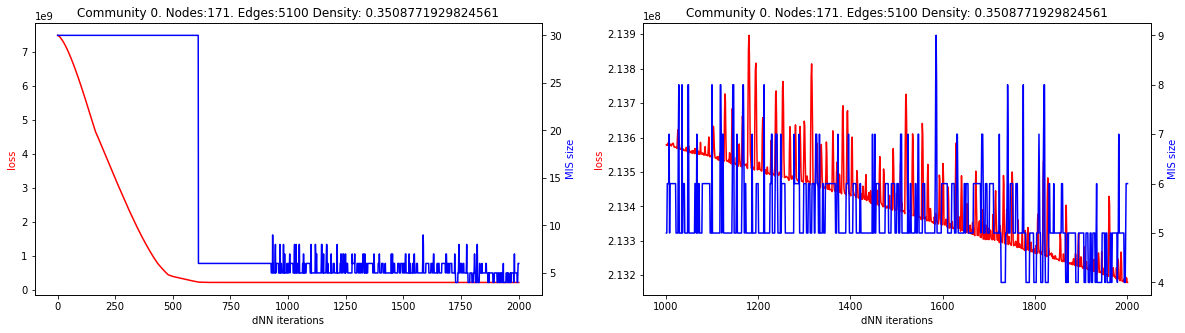

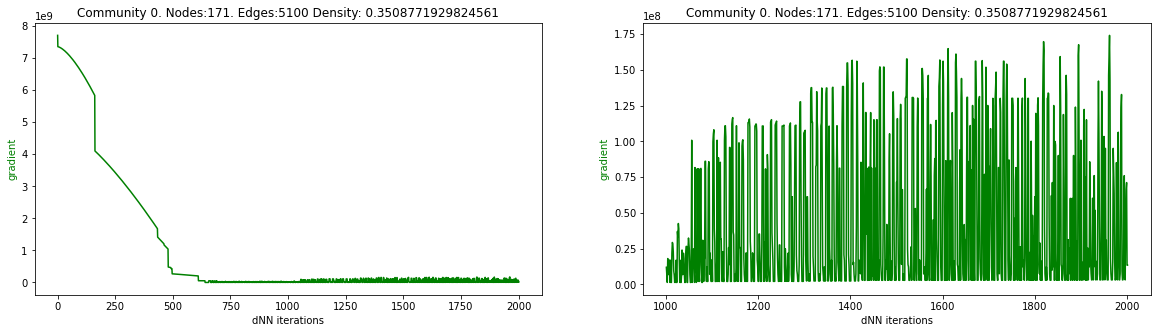

Graph with 300 nodes and 11460 edges


INFO:root:Epoch: 10. Loss: 165180948480.0. Gradient norm: 153842761728.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 176
INFO:root:Epoch: 20. Loss: 163287891968.0. Gradient norm: 152958713856.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 176
INFO:root:Epoch: 30. Loss: 160875364352.0. Gradient norm: 151824515072.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 176
INFO:root:Epoch: 40. Loss: 158057627648.0. Gradient norm: 150489006080.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 176
INFO:root:Epoch: 50. Loss: 154904723456.0. Gradient norm: 148917633024.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 176
INFO:root:Epoch: 60. Loss: 151500914688.0. Gradient norm: 144274178048.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 174
INFO:root:Epoch: 70. Loss: 147912753152.0. Gradient norm: 141673660416.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 174
INFO:root:Epo

INFO:root:Epoch: 600. Loss: 5192600576.0. Gradient norm: 6974926336.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 95
INFO:root:Epoch: 610. Loss: 4752262656.0. Gradient norm: 6209180672.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 94
INFO:root:Epoch: 620. Loss: 4357803008.0. Gradient norm: 5528708096.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 90
INFO:root:Epoch: 630. Loss: 4002674688.0. Gradient norm: 4952754688.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 88
INFO:root:Epoch: 640. Loss: 3683352832.0. Gradient norm: 4478226432.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 85
INFO:root:Epoch: 650. Loss: 3393598720.0. Gradient norm: 4005648128.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 79
INFO:root:Epoch: 660. Loss: 3136536320.0. Gradient norm: 3489954048.0. Clipnorm: 1.0000000000000005e-08. Learning rate:0.1. Mis size: 75
INFO:root:Epoch: 670. Loss: 2915427072.0.

MIS length:32
Time used: 31.294058799743652 seconds


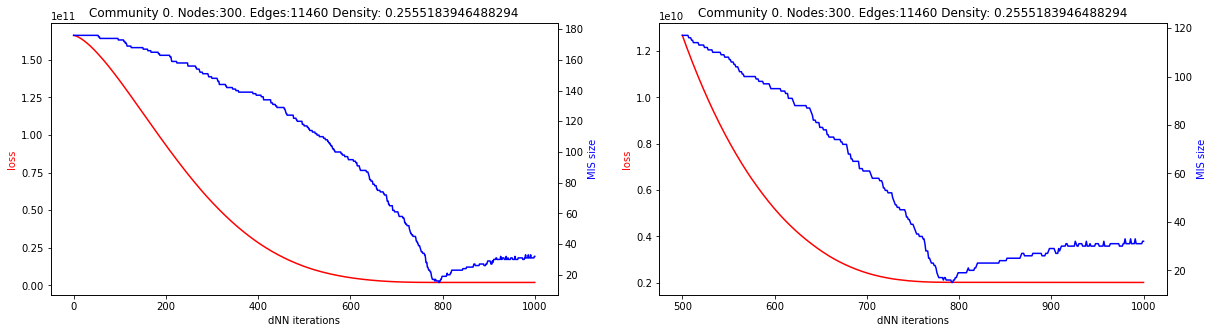

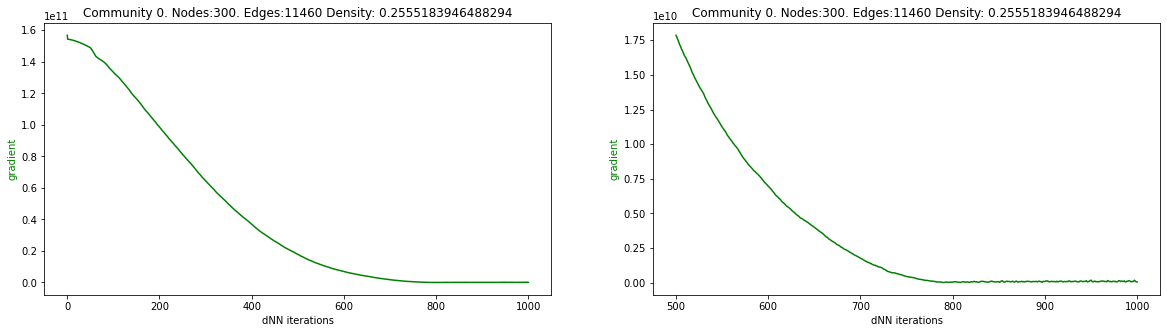

In [115]:
a = 1
clipnorm_list = []
while a >= 0.00000001:
    clipnorm_list.append(a)
    a*=0.1
results_list_sanr = []
results_list_brock = []
results_list_keller = []
results_list_phat = []

for clipnorm in clipnorm_list:
    dnn_params = DnnParams(alpha = 0.5, clipnorm=clipnorm, max_epochs=2000)
    res = measure_time_and_result("datasets/sanr200-0-9/sanr200-0-9.mtx",
                        "datasets/sanr200-0-9/sanr200-0-9.metis",
                        "imgs/sanr200-0-9/clipnorm/{}".format(str(clipnorm).replace(".","_")),
                        dnn_params,
                        complement = True, reindex = True,)
    results_list_sanr.append(res)
    
    res = measure_time_and_result("datasets/brock200-2/brock200-2.mtx",
                        "datasets/brock200-2/brock200-2.metis",
                        "imgs/brock200-2/clipnorm/{}".format(str(clipnorm).replace(".","_")),
                        dnn_params,
                        complement = True, reindex = True,)
    results_list_brock.append(res)
    
    res = measure_time_and_result("datasets/keller4/keller4.mtx",
                        "datasets/keller4/keller4.metis",
                        "imgs/keller4/clipnorm/{}".format(str(clipnorm).replace(".","_")),
                        dnn_params,
                        complement = True, reindex = True,)
    results_list_keller.append(res)

    res = measure_time_and_result("datasets/p-hat300-3/p-hat300-3.mtx",
                        "datasets/p-hat300-3/p-hat300-3.metis",
                        "imgs/p-hat300-3/clipnorm/{}".format(str(clipnorm).replace(".","_")),
                        dnn_params,
                        complement = True, reindex = True,)
    results_list_phat.append(res)


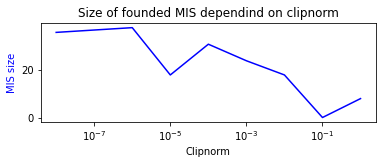

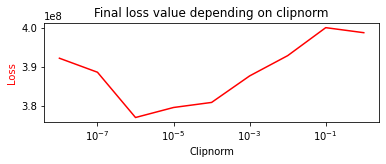

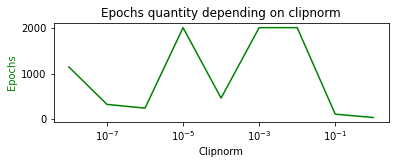

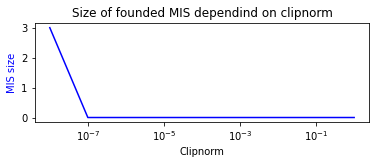

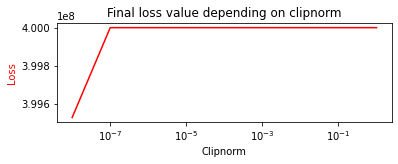

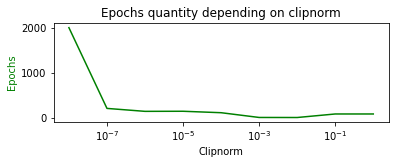

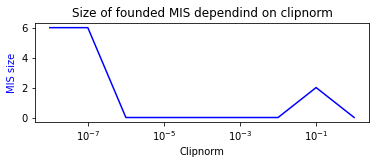

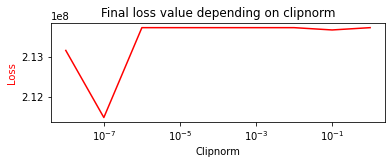

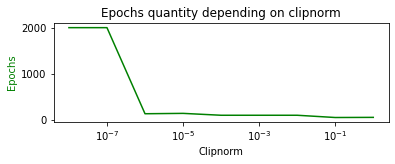

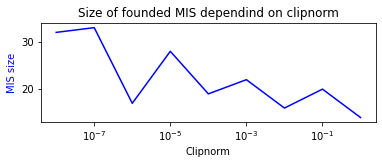

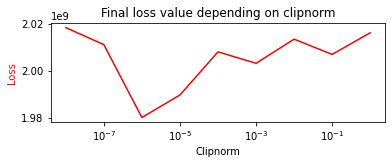

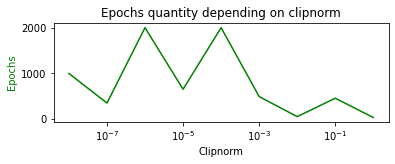

In [117]:
draw_analysis_plots(results_list_sanr, "sanr")
draw_analysis_plots(results_list_brock, "brock")
draw_analysis_plots(results_list_keller, "keller")
draw_analysis_plots(results_list_phat, "phat")

In [284]:
dnn_params = DnnParams(alpha = 0.5, clipnorm=0.00000001, max_epochs = 10000)
measure_time_and_result("datasets/brock200-2/brock200-2.mtx",
                        "datasets/brock200-2/brock200-2.metis",
                        "imgs/brock200-2",
                        dnn_params,
                        complement = True, reindex = True,)

Graph with 200 nodes and 10024 edges


INFO:root:Epoch: 10. Loss: 19.038644790649414. Gradient norm: 10.099542617797852. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 123
INFO:root:Epoch: 20. Loss: 18.91404914855957. Gradient norm: 10.099542617797852. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 123
INFO:root:Epoch: 30. Loss: 18.754207611083984. Gradient norm: 10.099542617797852. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 123
INFO:root:Epoch: 40. Loss: 18.565963745117188. Gradient norm: 10.099542617797852. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 123
INFO:root:Epoch: 50. Loss: 18.353404998779297. Gradient norm: 10.099542617797852. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 123
INFO:root:Epoch: 60. Loss: 18.11915397644043. Gradient norm: 10.099542617797852. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 123
INFO:root:Epoch: 70. Loss: 17.86537742614746. Gradient norm: 10.099542617797852. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 123
INFO:root:Epoch: 80. Loss: 17.593578338623047. Gradient norm: 10.09954261779785

INFO:root:Epoch: 640. Loss: 1.0. Gradient norm: 4.999999873689376e-05. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 1
INFO:root:Epoch: 650. Loss: 0.9999984502792358. Gradient norm: 0.00023452076129615307. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 660. Loss: 1.0000230073928833. Gradient norm: 0.036861903965473175. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 670. Loss: 0.9999898672103882. Gradient norm: 0.001077032764442265. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 680. Loss: 0.999989926815033. Gradient norm: 0.013981415890157223. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 690. Loss: 0.9999793171882629. Gradient norm: 0.013521834276616573. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 700. Loss: 0.9999707937240601. Gradient norm: 0.0019455074798315763. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 710. Loss: 0.9999628663063049. Gradient norm: 0.0022192341275513

INFO:root:Epoch: 1260. Loss: 0.9997228384017944. Gradient norm: 0.0042278822511434555. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 1270. Loss: 0.9997131824493408. Gradient norm: 0.014481107704341412. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 5
INFO:root:Epoch: 1280. Loss: 0.9998070597648621. Gradient norm: 0.3916195333003998. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 1290. Loss: 0.9997065663337708. Gradient norm: 0.004216039087623358. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 1300. Loss: 0.9998297095298767. Gradient norm: 0.33349543809890747. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 5
INFO:root:Epoch: 1310. Loss: 0.9996957778930664. Gradient norm: 0.004301742184907198. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 1320. Loss: 0.9996899366378784. Gradient norm: 0.00427112216129899. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 1330. Loss: 0.9999610185623169. Gradient norm: 0

INFO:root:Epoch: 1880. Loss: 0.9994674921035767. Gradient norm: 0.014799915254116058. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 1890. Loss: 0.9994651079177856. Gradient norm: 0.024827249348163605. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 1900. Loss: 0.9994707107543945. Gradient norm: 0.005099261179566383. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 1910. Loss: 0.9994632601737976. Gradient norm: 0.005140278954058886. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 1920. Loss: 0.9994593858718872. Gradient norm: 0.014879263006150723. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 1930. Loss: 0.9994483590126038. Gradient norm: 0.005137359723448753. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 1940. Loss: 0.9994427561759949. Gradient norm: 0.005178558174520731. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 1950. Loss: 0.9994467496871948. Gradient norm

INFO:root:Epoch: 2500. Loss: 0.9992279410362244. Gradient norm: 0.0056488895788788795. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 2510. Loss: 0.9992438554763794. Gradient norm: 0.005583229940384626. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 2520. Loss: 0.9995167851448059. Gradient norm: 0.6883370876312256. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 2530. Loss: 0.9992201328277588. Gradient norm: 0.014999582432210445. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 2540. Loss: 0.9992108345031738. Gradient norm: 0.0056488895788788795. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 2550. Loss: 0.9992182850837708. Gradient norm: 0.0056488895788788795. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 2560. Loss: 0.9992024302482605. Gradient norm: 0.014946904964745045. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 2570. Loss: 0.9992074966430664. Gradient nor

INFO:root:Epoch: 3120. Loss: 0.9995805621147156. Gradient norm: 0.6999762058258057. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 3130. Loss: 0.9990350604057312. Gradient norm: 0.282056987285614. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 3140. Loss: 0.998995304107666. Gradient norm: 0.006092613562941551. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 3150. Loss: 0.9989961981773376. Gradient norm: 0.006107368040829897. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 3160. Loss: 0.9989974498748779. Gradient norm: 0.006092613562941551. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 3170. Loss: 0.9995049834251404. Gradient norm: 0.7598629593849182. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 3180. Loss: 0.9989808797836304. Gradient norm: 0.024944936856627464. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 3190. Loss: 0.9999550580978394. Gradient norm: 0.7199

INFO:root:Epoch: 3740. Loss: 0.9988261461257935. Gradient norm: 0.006287283729761839. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 3750. Loss: 0.9988145232200623. Gradient norm: 0.02049182541668415. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 3760. Loss: 0.9989838600158691. Gradient norm: 0.3544524610042572. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 3770. Loss: 0.9987991452217102. Gradient norm: 0.006293443962931633. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 3780. Loss: 0.9988130927085876. Gradient norm: 0.006288277916610241. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 3790. Loss: 0.9988082051277161. Gradient norm: 0.006287283729761839. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 3800. Loss: 0.9992518424987793. Gradient norm: 0.7705383896827698. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 3810. Loss: 0.9996298551559448. Gradient norm: 0.7

KeyboardInterrupt: 

In [ ]:
measure_time_and_result("datasets/brock200-3/brock200-3.mtx","datasets/brock200-3/brock200-3.metis", "imgs/brock200-3", complement = True, reindex = True,)

In [ ]:
dnn_params = DnnParams(alpha = 0.5, clipnorm=0.00000001)
measure_time_and_result("datasets/brock200-4/brock200-4.mtx",
                        "datasets/brock200-4/brock200-4.metis",
                        "imgs/brock200-4",
                        dnn_params,
                        complement = True, reindex = True,)

In [127]:
dnn_params = DnnParams(alpha = 0.5, clipnorm=0.000001, max_epochs=10000)
measure_time_and_result("datasets/brock800-2/brock800-2.mtx",
                        "datasets/brock800-2/brock800-2.metis",
                        "imgs/brock800-2/random_init",
                        dnn_params,
                        complement = True, reindex = True,)

Graph with 800 nodes and 111434 edges


INFO:root:Epoch: 10. Loss: 148031315902464.0. Gradient norm: 80254827757568.0. Clipnorm: 1e-06. Learning rate:0.1. Mis size: 375
INFO:root:Epoch: 20. Loss: 73398231236608.0. Gradient norm: 49294631501824.0. Clipnorm: 1e-06. Learning rate:0.1. Mis size: 347
INFO:root:Epoch: 30. Loss: 23171562471424.0. Gradient norm: 21599510069248.0. Clipnorm: 1e-06. Learning rate:0.1. Mis size: 289
INFO:root:Epoch: 40. Loss: 3052536594432.0. Gradient norm: 4899321937920.0. Clipnorm: 1e-06. Learning rate:0.1. Mis size: 212
INFO:root:Epoch: 50. Loss: 107412480000.0. Gradient norm: 86845333504.0. Clipnorm: 1e-06. Learning rate:0.1. Mis size: 45
INFO:root:Epoch: 60. Loss: 102400139264.0. Gradient norm: 721382400.0. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 70. Loss: 102399983616.0. Gradient norm: 8270622.0. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 5
INFO:root:Epoch: 80. Loss: 102400098304.0. Gradient norm: 720069760.0. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 5
INFO:root:Ep

KeyboardInterrupt: 

Graph with 171 nodes and 5100 edges


INFO:root:Epoch: 10. Loss: 509646.78125. Gradient norm: 955748.75. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 20. Loss: 497987.09375. Gradient norm: 944752.75. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 30. Loss: 483246.71875. Gradient norm: 930665.8125. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 40. Loss: 466191.0625. Gradient norm: 914101.875. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 50. Loss: 447314.25. Gradient norm: 895404.0625. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 60. Loss: 426986.78125. Gradient norm: 874822.5625. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 70. Loss: 405509.875. Gradient norm: 852537.0625. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 80. Loss: 383140.6875. Gradient norm: 828689.375. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 90. Loss: 360106.5. Gradient norm: 803393.0. Clipnorm: 1e-08

INFO:root:Epoch: 200. Loss: 333253.5625. Gradient norm: 167522.984375. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 210. Loss: 332998.875. Gradient norm: 52648.671875. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 220. Loss: 332932.03125. Gradient norm: 167442.15625. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 230. Loss: 332864.78125. Gradient norm: 12046.951171875. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 240. Loss: 332811.3125. Gradient norm: 51831.0. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 250. Loss: 332750.53125. Gradient norm: 12044.8837890625. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 260. Loss: 332692.53125. Gradient norm: 11764.35546875. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 270. Loss: 332657.53125. Gradient norm: 91573.0859375. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 4
INFO:root:Epoch: 280. Loss: 332607.90625. Grad

INFO:root:Epoch: 890. Loss: 327072.09375. Gradient norm: 25422.32421875. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 900. Loss: 326963.8125. Gradient norm: 114829.421875. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 910. Loss: 326879.15625. Gradient norm: 152993.984375. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 920. Loss: 326790.53125. Gradient norm: 77323.734375. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 930. Loss: 326686.0. Gradient norm: 25535.568359375. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 940. Loss: 326574.09375. Gradient norm: 25531.19921875. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 950. Loss: 326649.375. Gradient norm: 388223.3125. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 960. Loss: 326546.25. Gradient norm: 384474.875. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 970. Loss: 326321.75. Gradient norm

INFO:root:Epoch: 100. Loss: 6533845.0. Gradient norm: 9450720.0. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 5
INFO:root:Epoch: 110. Loss: 6250732.5. Gradient norm: 8762751.0. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 5
INFO:root:Epoch: 120. Loss: 6037287.0. Gradient norm: 5147374.0. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 5
INFO:root:Epoch: 130. Loss: 5918154.0. Gradient norm: 3506268.75. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 5
INFO:root:Epoch: 140. Loss: 5806137.5. Gradient norm: 3290226.5. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 3
INFO:root:Epoch: 150. Loss: 5694665.5. Gradient norm: 3258433.25. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 1
INFO:root:Epoch: 160. Loss: 5576334.0. Gradient norm: 3233374.5. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 1
INFO:root:Epoch: 170. Loss: 5454446.0. Gradient norm: 3197841.75. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 1
INFO:root:Epoch: 180. Loss: 5330262.5. Gradient norm: 3161228.5. Clipnorm: 1e-08. Learning ra

INFO:root:Epoch: 240. Loss: 2091375.0. Gradient norm: 4569330.5. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 6
INFO:root:Epoch: 250. Loss: 1886269.5. Gradient norm: 4342403.0. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 6
INFO:root:Epoch: 260. Loss: 1688342.375. Gradient norm: 4108265.5. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 6
INFO:root:Epoch: 270. Loss: 1498366.375. Gradient norm: 3870234.25. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 6
INFO:root:Epoch: 280. Loss: 1316972.25. Gradient norm: 3628412.0. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 6
INFO:root:Epoch: 290. Loss: 1190298.875. Gradient norm: 2452751.5. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 6
INFO:root:Epoch: 300. Loss: 1074091.875. Gradient norm: 2329948.25. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 6
INFO:root:Epoch: 310. Loss: 962055.1875. Gradient norm: 2145244.25. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 6
INFO:root:Epoch: 320. Loss: 856130.9375. Gradient norm: 2031627.5. Clipnorm: 1e-08

INFO:root:Epoch: 150. Loss: 74560.4609375. Gradient norm: 207244.078125. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 7
INFO:root:Epoch: 160. Loss: 67191.484375. Gradient norm: 185778.296875. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 7
INFO:root:Epoch: 170. Loss: 60343.05078125. Gradient norm: 169803.140625. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 7
INFO:root:Epoch: 180. Loss: 54017.19140625. Gradient norm: 151209.078125. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 7
INFO:root:Epoch: 190. Loss: 48063.5234375. Gradient norm: 142632.875. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 7
INFO:root:Epoch: 200. Loss: 42443.859375. Gradient norm: 125367.3125. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 7
INFO:root:Epoch: 210. Loss: 37467.45703125. Gradient norm: 109307.2421875. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 7
INFO:root:Epoch: 220. Loss: 32986.58203125. Gradient norm: 97161.53125. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 7
INFO:root:Epoch: 230. Loss: 28940.77

MIS length:9
Time used: 54.95957350730896 seconds


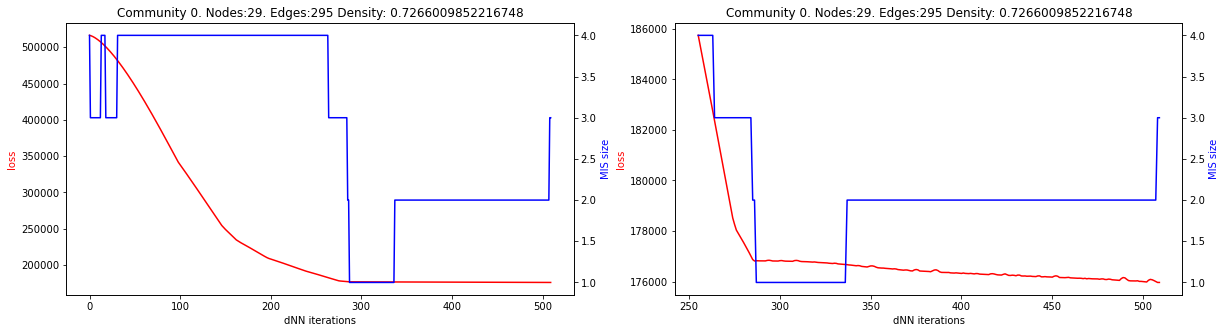

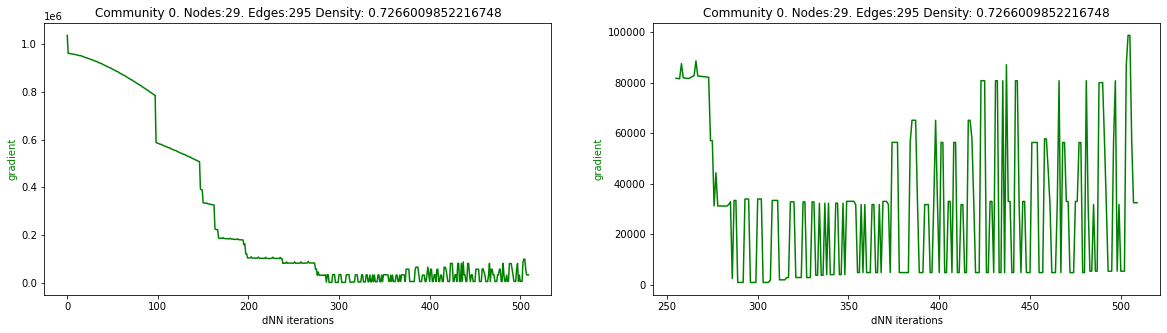

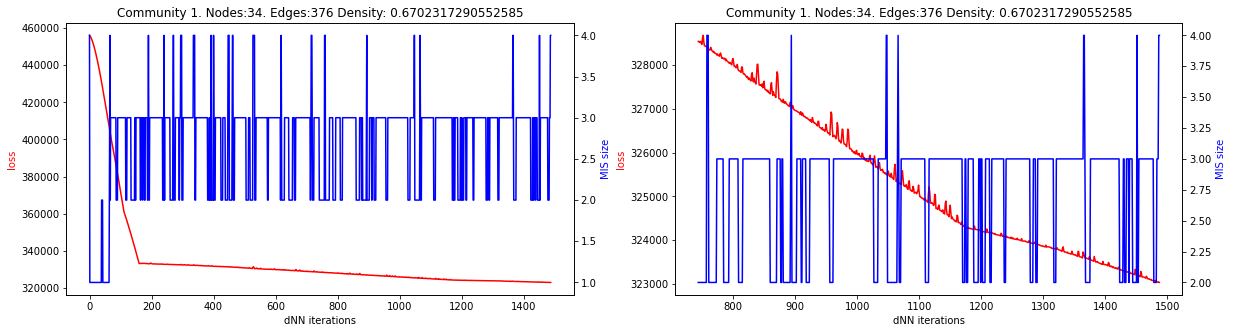

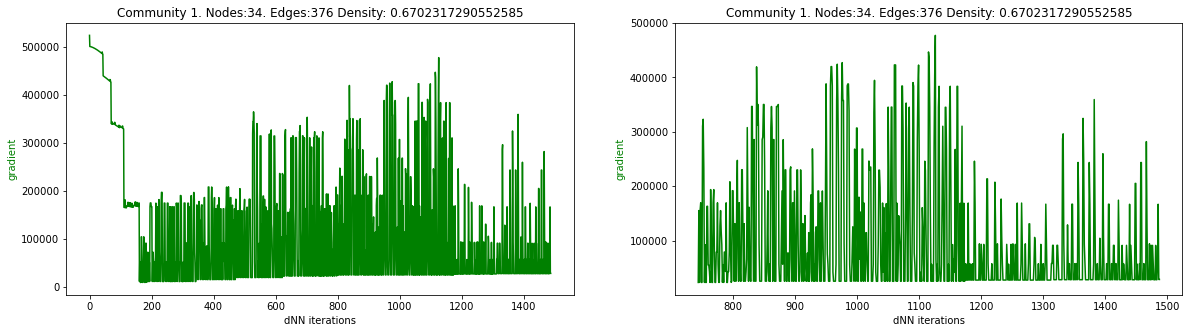

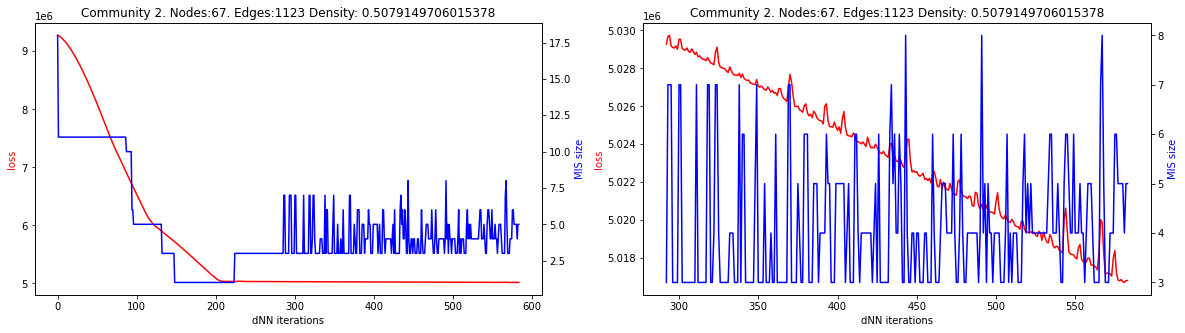

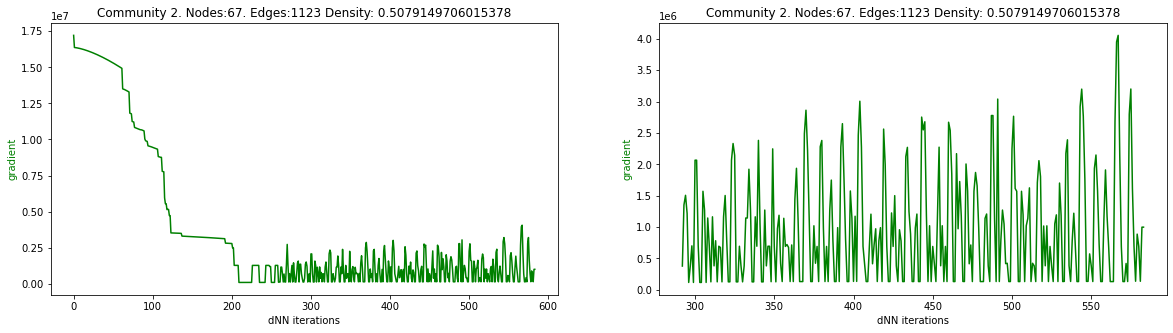

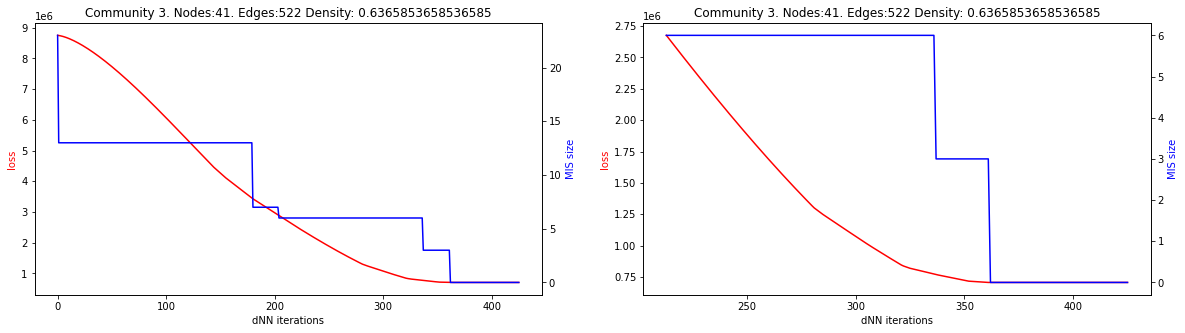

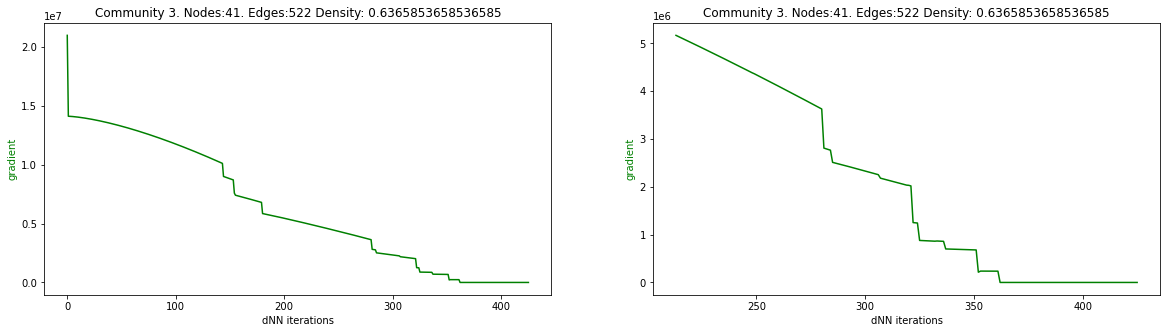

In [78]:
dnn_params = DnnParams(alpha = 0.5, clipnorm=0.00000001, max_epochs = 2000)
measure_time_and_result("datasets/keller4/keller4.mtx",
                        "datasets/keller4/keller4.metis",
                        "imgs/keller4/com",
                        dnn_params,
                        complement = True, reindex = True,)

In [128]:
dnn_params = DnnParams(alpha = 0.5, clipnorm=0.00000001, max_epochs = 10000)
measure_time_and_result("datasets/MANN-a27/MANN-a27.mtx",
                        "datasets/MANN-a27/MANN-a27.metis",
                        "imgs/MANN-a27/random_init",
                        dnn_params,
                        complement = True, reindex = True,)

Graph with 378 nodes and 702 edges


INFO:root:Epoch: 10. Loss: 10113273856.0. Gradient norm: 3148955904.0. Clipnorm: 1e-09. Learning rate:0.1. Mis size: 187
INFO:root:Epoch: 20. Loss: 10109390848.0. Gradient norm: 3148485120.0. Clipnorm: 1e-09. Learning rate:0.1. Mis size: 187
INFO:root:Epoch: 30. Loss: 10104375296.0. Gradient norm: 3148107008.0. Clipnorm: 1e-09. Learning rate:0.1. Mis size: 187
INFO:root:Epoch: 40. Loss: 10098524160.0. Gradient norm: 3147261696.0. Clipnorm: 1e-09. Learning rate:0.1. Mis size: 187
INFO:root:Epoch: 50. Loss: 10091919360.0. Gradient norm: 3146298624.0. Clipnorm: 1e-09. Learning rate:0.1. Mis size: 187
INFO:root:Epoch: 60. Loss: 10084634624.0. Gradient norm: 3145277952.0. Clipnorm: 1e-09. Learning rate:0.1. Mis size: 187
INFO:root:Epoch: 70. Loss: 10076691456.0. Gradient norm: 3144302336.0. Clipnorm: 1e-09. Learning rate:0.1. Mis size: 187
INFO:root:Epoch: 80. Loss: 10068238336.0. Gradient norm: 3143179008.0. Clipnorm: 1e-09. Learning rate:0.1. Mis size: 187
INFO:root:Epoch: 90. Loss: 10059

INFO:root:Epoch: 690. Loss: 9093957632.0. Gradient norm: 2731645440.0. Clipnorm: 1e-09. Learning rate:0.1. Mis size: 180
INFO:root:Epoch: 700. Loss: 9074652160.0. Gradient norm: 2729103104.0. Clipnorm: 1e-09. Learning rate:0.1. Mis size: 180
INFO:root:Epoch: 710. Loss: 9055315968.0. Gradient norm: 2718928128.0. Clipnorm: 1e-09. Learning rate:0.1. Mis size: 180
INFO:root:Epoch: 720. Loss: 9035965440.0. Gradient norm: 2705108736.0. Clipnorm: 1e-09. Learning rate:0.1. Mis size: 180
INFO:root:Epoch: 730. Loss: 9016570880.0. Gradient norm: 2700879104.0. Clipnorm: 1e-09. Learning rate:0.1. Mis size: 180
INFO:root:Epoch: 740. Loss: 8997223424.0. Gradient norm: 2679102208.0. Clipnorm: 1e-09. Learning rate:0.1. Mis size: 180
INFO:root:Epoch: 750. Loss: 8977846272.0. Gradient norm: 2672904704.0. Clipnorm: 1e-09. Learning rate:0.1. Mis size: 180
INFO:root:Epoch: 760. Loss: 8958434304.0. Gradient norm: 2670599168.0. Clipnorm: 1e-09. Learning rate:0.1. Mis size: 180
INFO:root:Epoch: 770. Loss: 8938

KeyboardInterrupt: 

Graph with 300 nodes and 11460 edges


INFO:root:Epoch: 10. Loss: 493643333632.0. Gradient norm: 356139008000.0. Clipnorm: 1e-07. Learning rate:0.1. Mis size: 163
INFO:root:Epoch: 20. Loss: 451382771712.0. Gradient norm: 335136653312.0. Clipnorm: 1e-07. Learning rate:0.1. Mis size: 162
INFO:root:Epoch: 30. Loss: 401041424384.0. Gradient norm: 308952924160.0. Clipnorm: 1e-07. Learning rate:0.1. Mis size: 161
INFO:root:Epoch: 40. Loss: 346974388224.0. Gradient norm: 279250042880.0. Clipnorm: 1e-07. Learning rate:0.1. Mis size: 157
INFO:root:Epoch: 50. Loss: 292319723520.0. Gradient norm: 248184422400.0. Clipnorm: 1e-07. Learning rate:0.1. Mis size: 154
INFO:root:Epoch: 60. Loss: 239417278464.0. Gradient norm: 216600723456.0. Clipnorm: 1e-07. Learning rate:0.1. Mis size: 149
INFO:root:Epoch: 70. Loss: 190063624192.0. Gradient norm: 184118853632.0. Clipnorm: 1e-07. Learning rate:0.1. Mis size: 146
INFO:root:Epoch: 80. Loss: 145854054400.0. Gradient norm: 152609161216.0. Clipnorm: 1e-07. Learning rate:0.1. Mis size: 140
INFO:roo

INFO:root:Epoch: 700. Loss: 2010788096.0. Gradient norm: 179085392.0. Clipnorm: 1e-07. Learning rate:0.1. Mis size: 24
INFO:root:Epoch: 710. Loss: 2010063360.0. Gradient norm: 355807776.0. Clipnorm: 1e-07. Learning rate:0.1. Mis size: 24
INFO:root:Epoch: 720. Loss: 2009590528.0. Gradient norm: 103107320.0. Clipnorm: 1e-07. Learning rate:0.1. Mis size: 22
INFO:root:Epoch: 730. Loss: 2009334144.0. Gradient norm: 146744768.0. Clipnorm: 1e-07. Learning rate:0.1. Mis size: 23
INFO:root:Epoch: 740. Loss: 2009300608.0. Gradient norm: 398759904.0. Clipnorm: 1e-07. Learning rate:0.1. Mis size: 24
INFO:root:Epoch: 750. Loss: 2009098880.0. Gradient norm: 311702944.0. Clipnorm: 1e-07. Learning rate:0.1. Mis size: 26
INFO:root:Epoch: 760. Loss: 2009221760.0. Gradient norm: 248509008.0. Clipnorm: 1e-07. Learning rate:0.1. Mis size: 21
INFO:root:Epoch: 770. Loss: 2009133184.0. Gradient norm: 312843712.0. Clipnorm: 1e-07. Learning rate:0.1. Mis size: 22
INFO:root:Epoch: 780. Loss: 2008399616.0. Gradie

INFO:root:Epoch: 1390. Loss: 1992351872.0. Gradient norm: 116224776.0. Clipnorm: 1e-07. Learning rate:0.1. Mis size: 32
INFO:root:Epoch: 1400. Loss: 1991987584.0. Gradient norm: 95491616.0. Clipnorm: 1e-07. Learning rate:0.1. Mis size: 32
INFO:root:Epoch: 1410. Loss: 1992044032.0. Gradient norm: 296699040.0. Clipnorm: 1e-07. Learning rate:0.1. Mis size: 32
INFO:root:Epoch: 1420. Loss: 1991480960.0. Gradient norm: 65094652.0. Clipnorm: 1e-07. Learning rate:0.1. Mis size: 32
INFO:root:Epoch: 1430. Loss: 1991026688.0. Gradient norm: 102616872.0. Clipnorm: 1e-07. Learning rate:0.1. Mis size: 32
INFO:root:Epoch: 1440. Loss: 1991259520.0. Gradient norm: 100923792.0. Clipnorm: 1e-07. Learning rate:0.1. Mis size: 32
INFO:root:Epoch: 1450. Loss: 1990980352.0. Gradient norm: 181162176.0. Clipnorm: 1e-07. Learning rate:0.1. Mis size: 32
INFO:root:Epoch: 1460. Loss: 1990808064.0. Gradient norm: 138335984.0. Clipnorm: 1e-07. Learning rate:0.1. Mis size: 32
INFO:root:Epoch: 1470. Loss: 1990603520.0.

MIS length:36
Time used: 53.037792444229126 seconds


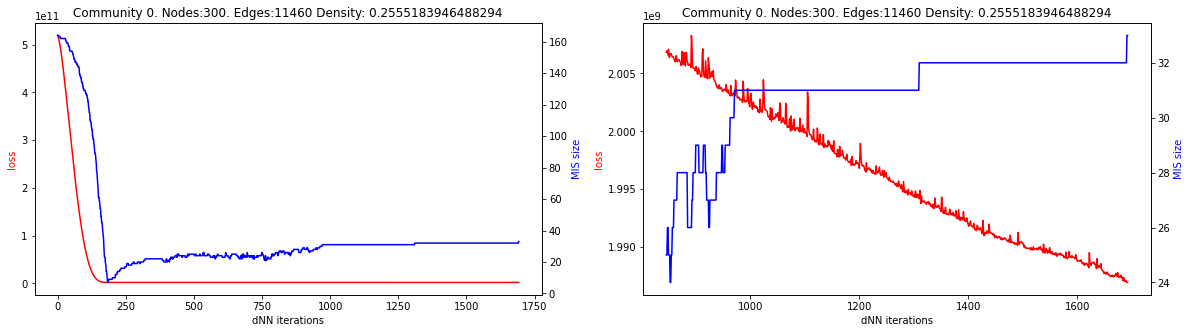

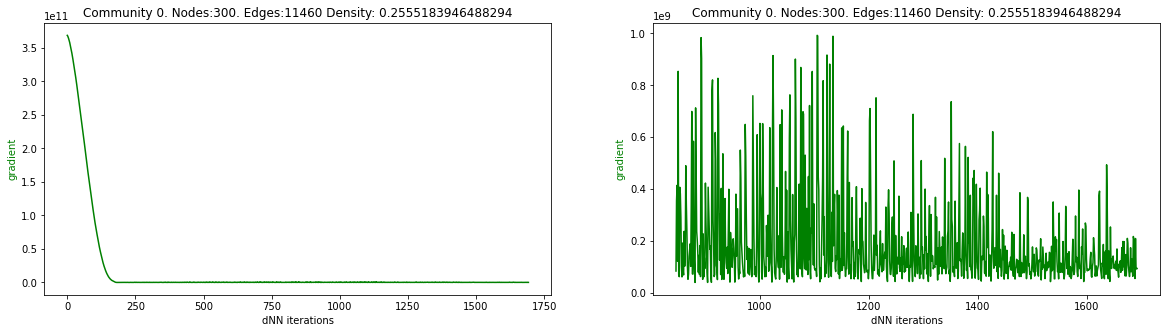

In [123]:
dnn_params = DnnParams(alpha = 0.5, clipnorm=0.0000001, max_epochs = 10000)
# dnn_params = DnnParams(alpha = 0.5, clipnorm=10000000000)
measure_time_and_result("datasets/p-hat300-3/p-hat300-3.mtx",
                        "datasets/p-hat300-3/p-hat300-3.metis",
                        "imgs/p-hat300-3/random_init",
                        dnn_params,
                        complement = True, reindex = True,)

Graph with 200 nodes and 6032 edges


INFO:root:Epoch: 10. Loss: 40375201792.0. Gradient norm: 37492633600.0. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 97
INFO:root:Epoch: 20. Loss: 39914459136.0. Gradient norm: 37227274240.0. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 97
INFO:root:Epoch: 30. Loss: 39328616448.0. Gradient norm: 36835729408.0. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 97
INFO:root:Epoch: 40. Loss: 38647304192.0. Gradient norm: 36339527680.0. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 97
INFO:root:Epoch: 50. Loss: 37888344064.0. Gradient norm: 35801657344.0. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 96
INFO:root:Epoch: 60. Loss: 37064679424.0. Gradient norm: 35227385856.0. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 96
INFO:root:Epoch: 70. Loss: 36186648576.0. Gradient norm: 34664017920.0. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 96
INFO:root:Epoch: 80. Loss: 35262103552.0. Gradient norm: 34073554944.0. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 96
INFO:root:Epoch: 90. Loss: 34297

INFO:root:Epoch: 690. Loss: 400036960.0. Gradient norm: 42328700.0. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 1
INFO:root:Epoch: 700. Loss: 400040928.0. Gradient norm: 82232944.0. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 1
INFO:root:Epoch: 710. Loss: 400095328.0. Gradient norm: 106759232.0. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 720. Loss: 399951264.0. Gradient norm: 10075734.0. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 730. Loss: 399945088.0. Gradient norm: 1940588.375. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 740. Loss: 399940768.0. Gradient norm: 1979348.375. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 1
INFO:root:Epoch: 750. Loss: 399932032.0. Gradient norm: 2059339.625. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 1
INFO:root:Epoch: 760. Loss: 399976576.0. Gradient norm: 81922032.0. Clipnorm: 1e-08. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 770. Loss: 400093056.0. Gradient norm: 121898544.0.

MIS length:13
Time used: 24.909022569656372 seconds


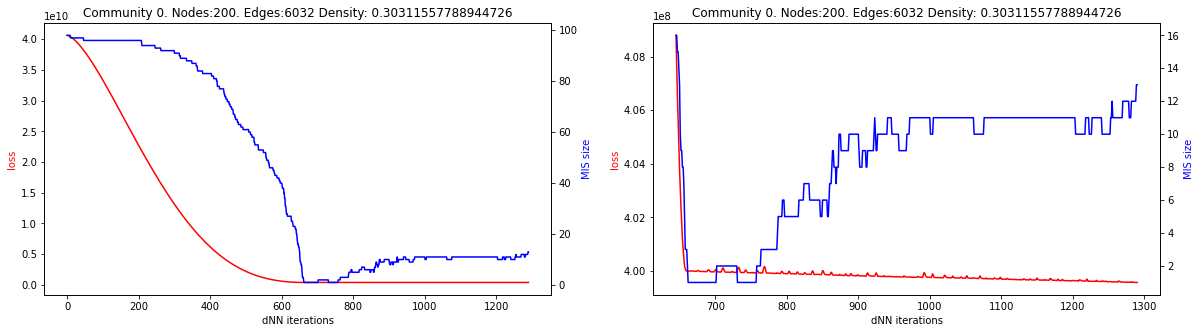

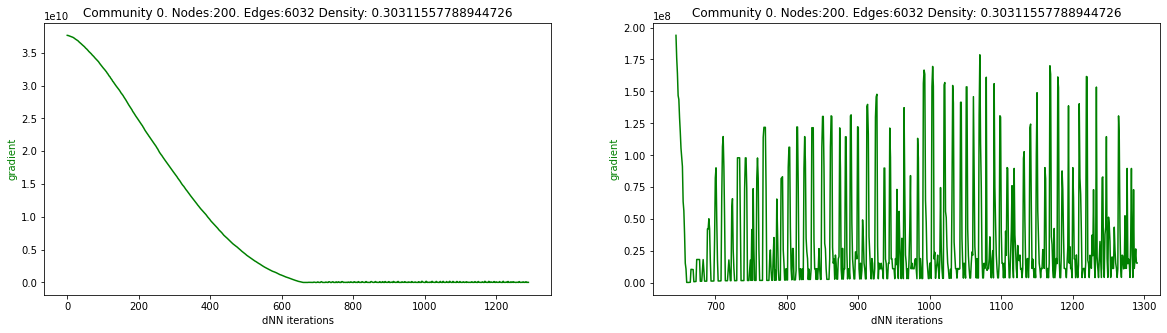

In [121]:
dnn_params = DnnParams(alpha = 0.5, clipnorm=0.00000001, max_epochs=10000)
# dnn_params = DnnParams(alpha = 0.5, clipnorm=100000000000)
measure_time_and_result("datasets/sanr200-0-7/sanr200-0-7.mtx",
                        "datasets/sanr200-0-7/sanr200-0-7.metis",
                        "imgs/sanr200-0-7/random_init",
                        dnn_params,
                        complement = True, reindex = True,)

Graph with 200 nodes and 2037 edges


INFO:root:Epoch: 10. Loss: 4896612352.0. Gradient norm: 4378895872.0. Clipnorm: 1e-06. Learning rate:0.1. Mis size: 2
INFO:root:Epoch: 20. Loss: 1646462464.0. Gradient norm: 1810525184.0. Clipnorm: 1e-06. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 30. Loss: 476103712.0. Gradient norm: 320154336.0. Clipnorm: 1e-06. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 40. Loss: 399984224.0. Gradient norm: 493143.40625. Clipnorm: 1e-06. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 50. Loss: 399890464.0. Gradient norm: 25627692.0. Clipnorm: 1e-06. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 60. Loss: 399456576.0. Gradient norm: 55177980.0. Clipnorm: 1e-06. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 70. Loss: 398318560.0. Gradient norm: 14883364.0. Clipnorm: 1e-06. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 80. Loss: 397388576.0. Gradient norm: 9871153.0. Clipnorm: 1e-06. Learning rate:0.1. Mis size: 0
INFO:root:Epoch: 90. Loss: 396284672.0. Gradient norm: 57998808.0. Clipn

INFO:root:Epoch: 720. Loss: 373156992.0. Gradient norm: 12545761.0. Clipnorm: 1e-06. Learning rate:0.1. Mis size: 36
INFO:root:Epoch: 730. Loss: 373225888.0. Gradient norm: 12546921.0. Clipnorm: 1e-06. Learning rate:0.1. Mis size: 36
INFO:root:Epoch: 740. Loss: 373116672.0. Gradient norm: 9031158.0. Clipnorm: 1e-06. Learning rate:0.1. Mis size: 36
INFO:root:Epoch: 750. Loss: 373184128.0. Gradient norm: 9031974.0. Clipnorm: 1e-06. Learning rate:0.1. Mis size: 36
INFO:root:Epoch: 760. Loss: 373145344.0. Gradient norm: 9031505.0. Clipnorm: 1e-06. Learning rate:0.1. Mis size: 36
INFO:root:Epoch: 770. Loss: 373170560.0. Gradient norm: 12545991.0. Clipnorm: 1e-06. Learning rate:0.1. Mis size: 36
INFO:root:Epoch: 780. Loss: 373103040.0. Gradient norm: 9030993.0. Clipnorm: 1e-06. Learning rate:0.1. Mis size: 36
INFO:root:Epoch: 790. Loss: 373140224.0. Gradient norm: 9031443.0. Clipnorm: 1e-06. Learning rate:0.1. Mis size: 36
INFO:root:Epoch: 800. Loss: 373160736.0. Gradient norm: 9031692.0. Cl

MIS length:39
Time used: 19.642531394958496 seconds


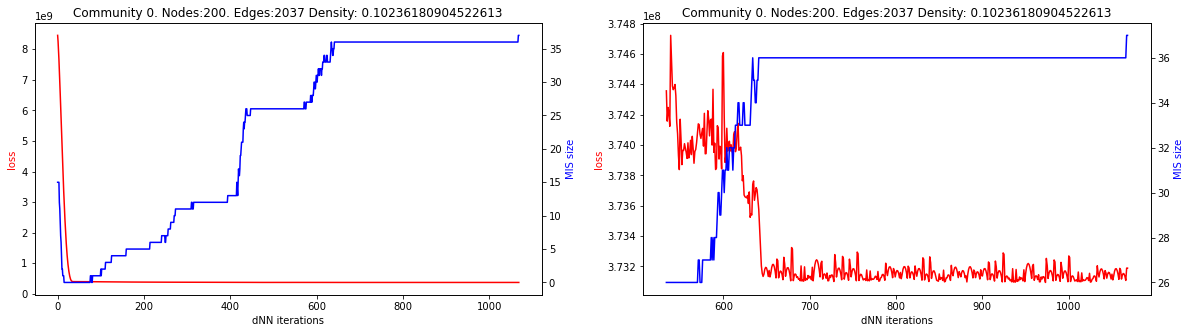

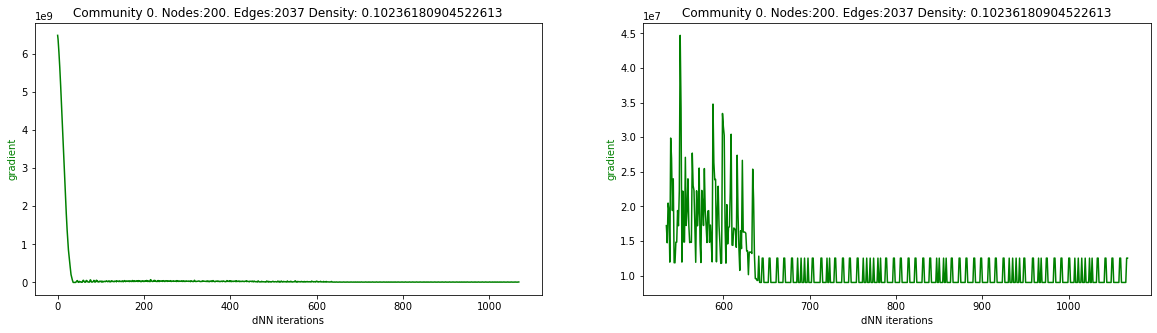

In [116]:
dnn_params = DnnParams(alpha = 0.9, clipnorm=0.000001, max_epochs = 5000)
measure_time_and_result("datasets/sanr200-0-9/sanr200-0-9.mtx",
                        "datasets/sanr200-0-9/sanr200-0-9.metis",
                        "imgs/sanr200-0-9/random_init", 
                        dnn_params,
                        complement = True, reindex = True)